
# Projet 10 Détectez des faux billets avec R ou Python

# Contexte

    ONCFM: une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros.
    
    ONCFM a observé des différences de dimensions entre les vrais et les faux billets.Ces différences sont difficilement notables à l’œil nu.
    
    Il souhaite mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets


# OBJECTIF

    Mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets à partir certaines dimensions du billet et des éléments qui le composent

    
# Les données

     -un fichier d’exemple contenant 1 500 billets, dont 1 000 sont vrais et 500 sont faux
     
     -une colonne a été ajoutée pour vous préciser la nature du billet (faux ou vrais)
     
     -six informations géométriques sur un billet:
         length : la longueur du billet (en mm)
         height_left : la hauteur du billet (mesurée sur le côté gauche, enmm)
         height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
         margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
         margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
         diagonal : la diagonale du billet (en mm).

    

        
# Critère technique:

    
    1. L’algorithme peut être écrit soit en Python, soit en R
    
    2. L’algorithme est capable de prendre en entrée un fichier contenant les dimensions de plusieurs billets,et de déterminer le type de chacun d’entre eux à partir des seules dimensions
    
    3. L’algorithme sera censé fonctionner, au sein d’un fichier nommé billets_production.csv
    
    4. L’algorithme doit être le plus performant possible pour identifier un maximum de faux billets
    
    5. une analyse descriptive des données:
        -la répartition des dimensions des billets
        -le nombre de vrais / faux billets etc
    6. Mettre en concurrence deux méthodes de prédiction :
        -une régression logistique classique ;
        -un k-means, duquel seront utilisés les centroïdes pour réaliser la prédiction.
    
    7. Une analyse des nombres de faux positifs et faux négatifs via une matrice de confusion pour l'évaluation optimale des modèles
    
    
    
# Livrable:

    un notebook Python ou R. Il devra être fonctionnel avec le format de données ne comportant que les dimensions géométriques.
    
# Délais:

    Le délai prévu pour l’expérimentation et la production de l’algorithme est d’un mois.
    

    


# 1. Import Librairies Python

In [1]:
#importer les outils python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Eviter l'affichage des messages erreurs
import warnings
warnings.filterwarnings('ignore')

#Affichier toutes les colonnes dans jupyter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



# 2. Comprendre les données

## 2.1 Il y a  7 colonnes qui sont :
    'is_genuine', 
    'diagonal', 
    'height_left', 
    'height_right', 
    'margin_low', 
    'margin_up', 
    'length'

In [3]:
billets=pd.read_csv('C:/Users/PF/Desktop/openclassroom/P10/billets.csv',sep=';')
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [4]:
print('Il y a ',len(billets.columns.tolist()),'colonnes qui sont :\n',
billets.columns.tolist())

Il y a  7 colonnes qui sont :
 ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']


## 2.2 Le fichier contient 1500 lignes de données X 7 colonnes:
    Colonne margin_low contient 1463 lignes de données
    Il y a 37 valeurs manquantes dans cette colonne.

In [5]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## 2.3 37 valeurs manquantes dans colonne margin_low

In [6]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

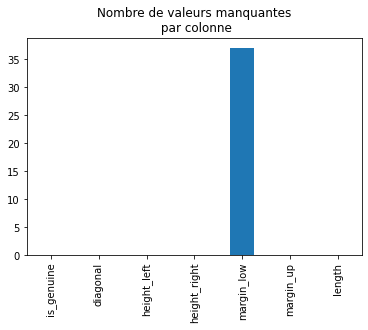

In [7]:
billets.isna().sum().plot.bar()
plt.title('Nombre de valeurs manquantes\n par colonne')
plt.show()

### 37 valeurs manquantes de margin_low concernent 29 VRAIS BILLETS (78%) et 8 FAUX BILLETS (21%)

True     29
False     8
Name: is_genuine, dtype: int64


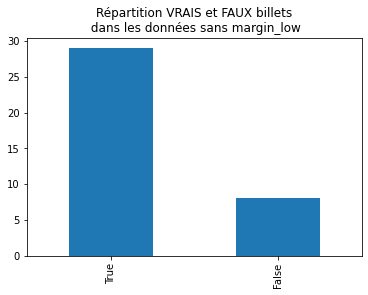

In [8]:
print(billets[billets.margin_low.isna()==True]['is_genuine'].value_counts())

billets[billets.margin_low.isna()==True]['is_genuine'].value_counts().plot.bar()

plt.title('Répartition VRAIS et FAUX billets\n dans les données sans margin_low')
plt.show()

True     0.783784
False    0.216216
Name: is_genuine, dtype: float64


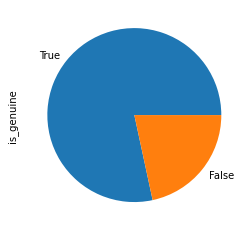

In [9]:
print(billets[billets.margin_low.isna()==True]['is_genuine'].value_counts(normalize=True))
billets[billets.margin_low.isna()==True]['is_genuine'].value_counts(normalize=True).plot.pie()
plt.show()

## 2.4 Valeur Unique des Colonnes

In [10]:
ValeurUnique=billets.nunique().reset_index().rename(columns=
                                                    {'index':'Nom de Colonne',0:'Nombre de valeur unique'})
ValeurUnique

Nom de Colonne  Nombre de valeur unique
0     is_genuine                        2
1       diagonal                      159
2    height_left                      155
3   height_right                      170
4     margin_low                      285
5      margin_up                      123
6         length                      336

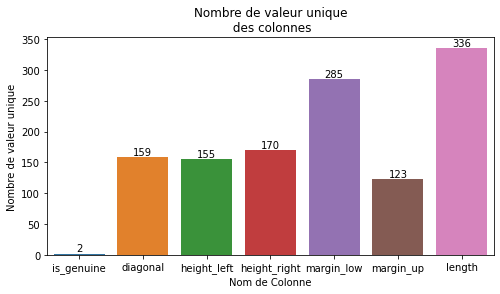

In [11]:
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(x='Nom de Colonne',y='Nombre de valeur unique',data=ValeurUnique,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.title('Nombre de valeur unique\n des colonnes')
plt.show()

### Colonne is_genuine en format boolean indique le billet est vrais ou faux

In [12]:
print('valeur de colonne is_genuine est :',billets.is_genuine.unique())
print('Type de donnée de colonne is_genuine est :',billets.is_genuine.dtype)

valeur de colonne is_genuine est : [ True False]
Type de donnée de colonne is_genuine est : bool


## 2.5 Il y a 1000 vrais billets (66%) et 500 faux billets (33%) dans les échantillions.

    L'échantillon n'est pas équilibré, nous ne pouvons pas utiliser accurency score pour mesurer la performance.

In [13]:
display(billets['is_genuine'].value_counts().reset_index(
).rename(columns={'index':'is_genuine','is_genuine':'Nombre de billets'}))

print('------------------------------------')


display(billets['is_genuine'].value_counts(normalize=True).reset_index(
).rename(columns={'index':'is_genuine','is_genuine':'Pourcentage'}))

is_genuine  Nombre de billets
0        True               1000
1       False                500

------------------------------------


is_genuine  Pourcentage
0        True     0.666667
1       False     0.333333

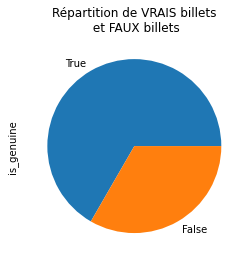

In [14]:
plt.figure(figsize=(4,4))
billets['is_genuine'].value_counts(normalize=True).plot.pie()
plt.title('Répartition de VRAIS billets\n et FAUX billets')
plt.show()


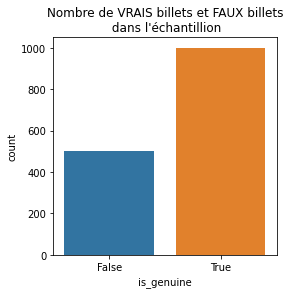

In [15]:
plt.figure(figsize=(4,4))
sns.countplot(x='is_genuine',data=billets)
plt.title('Nombre de VRAIS billets et FAUX billets\n dans l\'échantillion')
plt.show()

## 2.6 Déscription de données des colonnes

### 2.6.1 Déscription des donées globales
    Les données de Margin_low et length ont plus grande std que les autres variables dans les données globales

In [16]:
billets.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

### 2.6.2 Déscription des données par classement de VRAIS et FAUX Billets 
    
    Concernant 'diagonal':
        La valeur de VRAIS billets  est lèregement plus grande que la valeur de FAUX billets, mais la différence n'est pas suffisant grande pour distinguer les VRAIS et FAUX billets.
    
    Concernant 'height_left', 'height_right', 'margin_low' et 'margin_up':
        Les données de VRAIS Billets sont plus petites que les données de FAUX billets.La différence est suffisant pour différencier les VRAIS et FAUX billets.
    
    Concernant  'length'
        Les FAUX billets sont plus court que les VRAIS billets.La différence est suffisant pour différencier les VRAIS et FAUX billets.

In [17]:
billets_true=billets[billets['is_genuine']==True]
billets_false=billets[billets['is_genuine']==False]
print('Description des données de VRAIS billets')
display(billets_true.describe())
print('----------------------------------------------------')
print('Description des données de FAUX billets')
display(billets_false.describe())


Description des données de VRAIS billets


diagonal  height_left  height_right  margin_low   margin_up  \
count  1000.000000  1000.000000    1000.00000  971.000000  1000.00000   
mean    171.987080   103.949130     103.80865    4.116097     3.05213   
std       0.300441     0.300231       0.29157    0.319124     0.18634   
min     171.040000   103.140000     102.82000    2.980000     2.27000   
25%     171.790000   103.740000     103.61000    3.905000     2.93000   
50%     171.990000   103.950000     103.81000    4.110000     3.05000   
75%     172.200000   104.140000     104.00000    4.340000     3.18000   
max     172.920000   104.860000     104.95000    5.040000     3.74000   

            length  
count  1000.000000  
mean    113.202430  
std       0.359552  
min     111.760000  
25%     112.950000  
50%     113.205000  
75%     113.460000  
max     114.440000

----------------------------------------------------
Description des données de FAUX billets


diagonal  height_left  height_right  margin_low   margin_up  \
count  500.000000   500.000000    500.000000  492.000000  500.000000   
mean   171.901160   104.190340    104.143620    5.215935    3.350160   
std      0.306861     0.223758      0.270878    0.553531    0.180498   
min    171.040000   103.510000    103.430000    3.820000    2.920000   
25%    171.690000   104.040000    103.950000    4.840000    3.220000   
50%    171.910000   104.180000    104.160000    5.190000    3.350000   
75%    172.092500   104.332500    104.320000    5.592500    3.472500   
max    173.010000   104.880000    104.950000    6.900000    3.910000   

           length  
count  500.000000  
mean   111.630640  
std      0.615543  
min    109.490000  
25%    111.200000  
50%    111.630000  
75%    112.030000  
max    113.850000

### 2.6.3 Visualiser la différence entre VRAIS et FAUX billet selon les variables

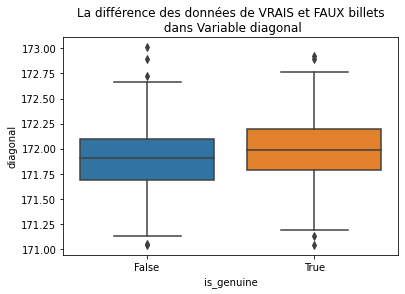

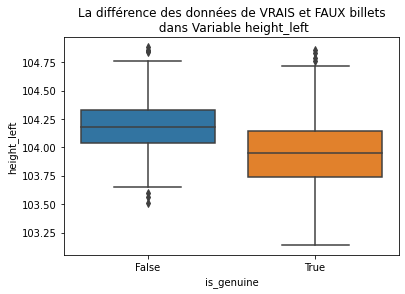

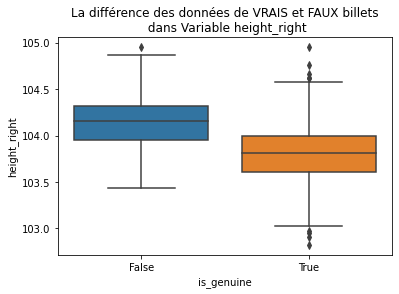

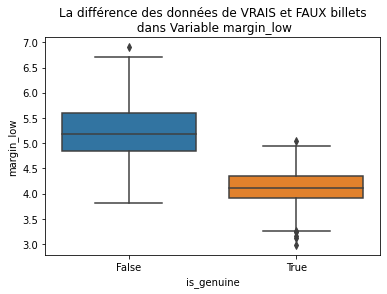

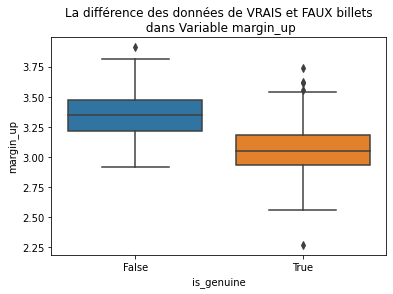

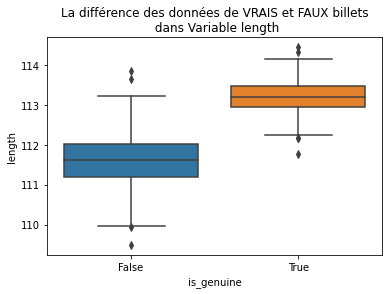

In [18]:
for i in range(len(billets.columns)-1):
    sns.boxplot(x='is_genuine', y=billets.columns[i+1],data=billets)
    plt.title('La différence des données de VRAIS et FAUX billets\n dans Variable '+billets.columns[i+1])
    plt.show()

## 2.7 Vérifier la corrélation entre les variables
    Les 3 variables ci dessous sont corrélé fortement avec is_genuine
        length  0.849285
        margin_low -0.783032
        margin_up -0.606262

### 2.7.1 Heatmap
    
    Is_genuine :
    -corrélé négativement avec margin_low, margin_up, height_left, height_right
    -corrélé positivement avec diagonal et  length
    -corrélé fortement avec margin_low et length

    Magin_low :
    -corrélé négativement avec  is_genuine,  diagnoal, length
    -corrélé positivement avec  margin_up, height_left, height_right
    -corrélé fortement avec is_genuine, length


In [19]:
billets_x=billets.iloc[:,1:6]
billets_x.head()

diagonal  height_left  height_right  margin_low  margin_up
0    171.81       104.86        104.95        4.52       2.89
1    171.46       103.36        103.66        3.77       2.99
2    172.69       104.48        103.50        4.40       2.94
3    171.36       103.91        103.94        3.62       3.01
4    171.73       104.28        103.46        4.04       3.48

is_genuine  diagonal  height_left  height_right  margin_low  \
is_genuine      1.000000  0.132756    -0.379833     -0.485092   -0.783032   
diagonal        0.132756  1.000000     0.019472     -0.024492   -0.111534   
height_left    -0.379833  0.019472     1.000000      0.242279    0.302643   
height_right   -0.485092 -0.024492     0.242279      1.000000    0.391085   
margin_low     -0.783032 -0.111534     0.302643      0.391085    1.000000   
margin_up      -0.606262 -0.055649     0.246522      0.307005    0.431606   
length          0.849285  0.097587    -0.320863     -0.401751   -0.666753   

              margin_up    length  
is_genuine    -0.606262  0.849285  
diagonal      -0.055649  0.097587  
height_left    0.246522 -0.320863  
height_right   0.307005 -0.401751  
margin_low     0.431606 -0.666753  
margin_up      1.000000 -0.520575  
length        -0.520575  1.000000

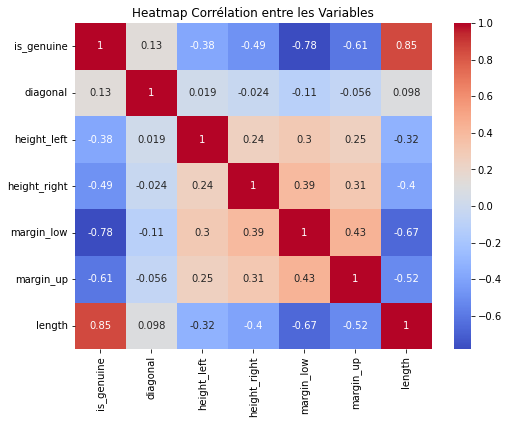

In [20]:
heatmap_data=billets.corr()
display(heatmap_data)
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data,annot=True,cmap='coolwarm')
plt.title('Heatmap Corrélation entre les Variables')
plt.show()

### 2.7.2 Pair plot
    Length et Margin_low sont 2 caractères les plus performantes pour distinguer les VRAIS et FAUX billets
    Diagonal est la caractère la moins performante pour distinguer les VRAIS et FAUX billets

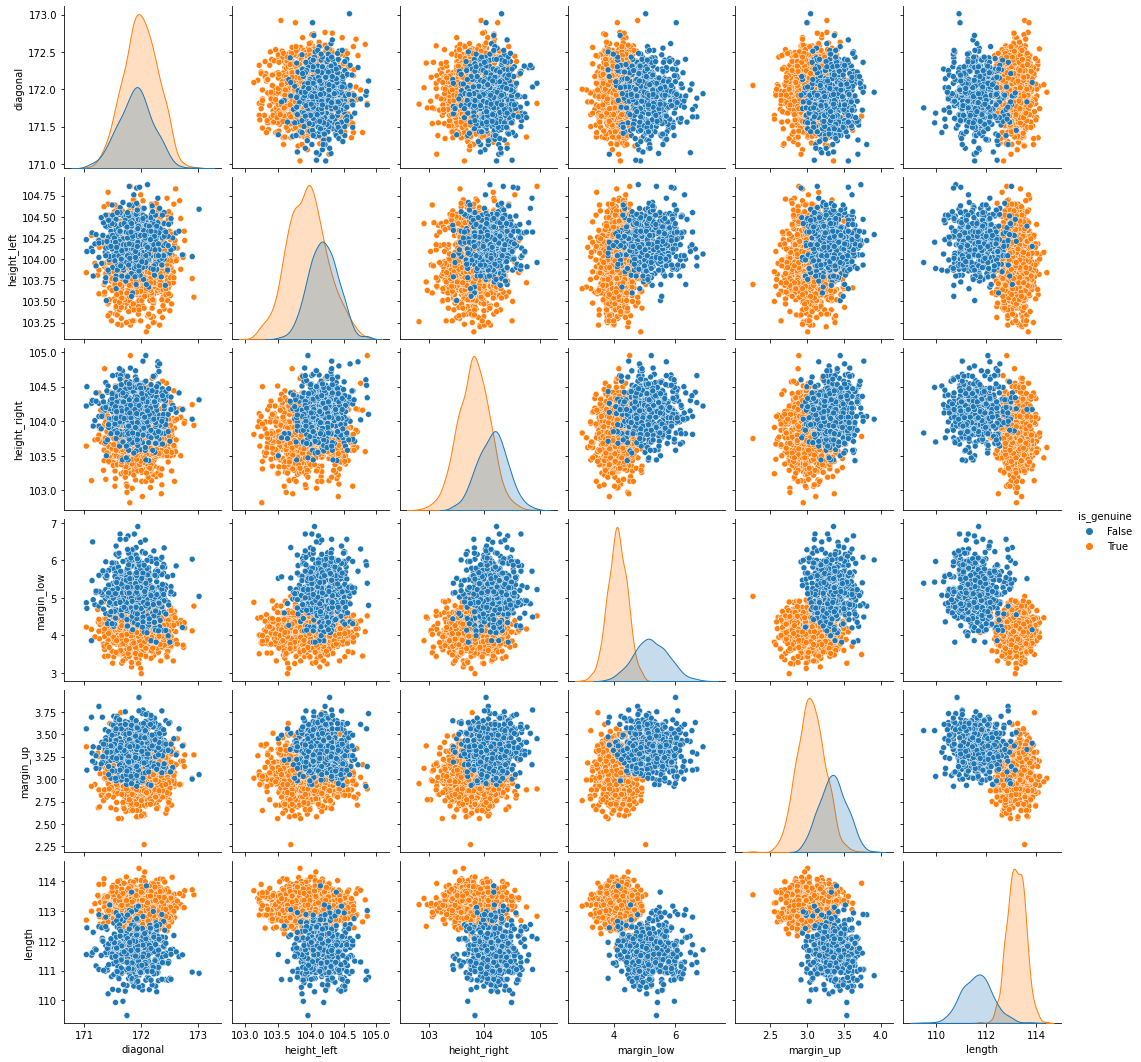

In [21]:
sns.pairplot(billets,hue='is_genuine')
plt.show()

### 2.7.3 Tester ANNOVA pour la corrélation entre is_genuine et les autres variables.

#### Levene Test entre is_genuine et ('diagonal', 'height_left', 'height_right','margin_up', 'length')

##### Tester équalité des variances
    H0: Il y a une équalité de variance entre les VRAIS et FAUX billets
    H1: Les variances entre les VRAIS et FAUX billets sont différent

In [22]:
import scipy.stats as stats

LevenePvalue=[]
LeveneStatistic=[]
LeveneResult=[]
LeveneHypo=[]

LesVariables=['diagonal', 'height_left', 'height_right','margin_up', 'length']

for i in LesVariables:
    
    print('Test Annova entre is_genuine et ',i)
    LeveneRes=stats.levene(
                billets[billets['is_genuine']==True][i],
                billets[billets['is_genuine']==False][i],
                center='mean')
    LeveneStatistic.append(LeveneRes[0])
    LevenePvalue.append(LeveneRes[1])
    print('le p_value de colonne',i,'est:',LeveneRes[1])
    
    if LeveneRes[1]>0.05:
        print('On rejette hypothèse 0, les variables de colonne',i,
              'entre les VRAIS et FAUX billets\n sont différents')
        
        LeveneResult=LeveneResult + ['Différent']
        LeveneHypo=LeveneHypo + ['H1']
    else:
        print('On ne pourra pas rejetter hypothèse 0, les variables de colonne',i,
              'entre les VRAIS et FAUX billets\n sont identique')
        LeveneResult=LeveneResult + ['Identique']
        LeveneHypo=LeveneHypo + ['H0']
    print('---------------------------------------------------------------------')

pd.DataFrame(list(zip(LesVariables,LeveneStatistic,LevenePvalue,LeveneHypo,LeveneResult)),
             columns=['Nom de Colonne','LeveneStatistic','LevenePvalue','LeveneHypo','LeveneResult'])       

Test Annova entre is_genuine et  diagonal
le p_value de colonne diagonal est: 0.9369793882291302
On rejette hypothèse 0, les variables de colonne diagonal entre les VRAIS et FAUX billets
 sont différents
---------------------------------------------------------------------
Test Annova entre is_genuine et  height_left
le p_value de colonne height_left est: 9.390751059253473e-11
On ne pourra pas rejetter hypothèse 0, les variables de colonne height_left entre les VRAIS et FAUX billets
 sont identique
---------------------------------------------------------------------
Test Annova entre is_genuine et  height_right
le p_value de colonne height_right est: 0.17556619726668113
On rejette hypothèse 0, les variables de colonne height_right entre les VRAIS et FAUX billets
 sont différents
---------------------------------------------------------------------
Test Annova entre is_genuine et  margin_up
le p_value de colonne margin_up est: 0.6645918791323848
On rejette hypothèse 0, les variables de

Nom de Colonne  LeveneStatistic  LevenePvalue LeveneHypo LeveneResult
0       diagonal         0.006254  9.369794e-01         H1    Différent
1    height_left        42.551479  9.390751e-11         H0    Identique
2   height_right         1.836499  1.755662e-01         H1    Différent
3      margin_up         0.188068  6.645919e-01         H1    Différent
4         length       172.094716  2.693870e-37         H0    Identique

#### Shapiro Test entre is_genuine et ('diagonal', 'height_left', 'height_right','margin_up', 'length')

##### Tester Distribution des variances
    H0: La distribution des variables ne sont pas une distribution normale
    H1: La distribution des variables sont une distribution normale

In [23]:
ShapiroPvalue=[]
ShapiroStatistic=[]
ShapiroResult=[]
ShapiroHypo=[]

LesVariables=['diagonal', 'height_left', 'height_right','margin_up', 'length']

for i in LesVariables:
    print('Test Shapiro entre is_genuine et ',i)
    Shapirostatistic,Shapirop_value=stats.f_oneway(
                billets[billets['is_genuine']==True][i],
                billets[billets['is_genuine']==False][i])
    ShapiroStatistic.append(Shapirostatistic)
    ShapiroPvalue.append(Shapirop_value)
    
    print('Shapiro Pvalue est: ',Shapirop_value)
    if Shapirop_value>0.05:
        print('On rejette hypothèse 0, is_genuine et ',i,
              'est une distribution normale')
        
        ShapiroResult=ShapiroResult + ['Distribution Normale']
        ShapiroHypo=ShapiroHypo + ['H1']
    else:
        print('On garde hypothèse 0, is_genuine et ',i,
              'n\'est pas une distribution normale')
        ShapiroResult=ShapiroResult + ['Non Distribution Normale']
        ShapiroHypo=ShapiroHypo + ['H0']
    print('---------------------------------------------------------------------')
    
pd.DataFrame(list(zip(LesVariables,ShapiroStatistic,ShapiroPvalue,ShapiroHypo,ShapiroResult)),
             columns=['Nom de Colonne','ShapiroStatistic','ShapiroPvalue','ShapiroHypo','ShapiroResult'])  

Test Shapiro entre is_genuine et  diagonal
Shapiro Pvalue est:  2.4668667372399823e-07
On garde hypothèse 0, is_genuine et  diagonal n'est pas une distribution normale
---------------------------------------------------------------------
Test Shapiro entre is_genuine et  height_left
Shapiro Pvalue est:  1.1269164017506187e-52
On garde hypothèse 0, is_genuine et  height_left n'est pas une distribution normale
---------------------------------------------------------------------
Test Shapiro entre is_genuine et  height_right
Shapiro Pvalue est:  2.2708556903089336e-89
On garde hypothèse 0, is_genuine et  height_right n'est pas une distribution normale
---------------------------------------------------------------------
Test Shapiro entre is_genuine et  margin_up
Shapiro Pvalue est:  3.1445303087223535e-151
On garde hypothèse 0, is_genuine et  margin_up n'est pas une distribution normale
---------------------------------------------------------------------
Test Shapiro entre is_genuine e

Nom de Colonne  ShapiroStatistic  ShapiroPvalue ShapiroHypo  \
0       diagonal         26.874763   2.466867e-07          H0   
1    height_left        252.558393   1.126916e-52          H0   
2   height_right        460.974212   2.270856e-89          H0   
3      margin_up        870.581394  3.144530e-151          H0   
4         length       3876.654138   0.000000e+00          H0   

              ShapiroResult  
0  Non Distribution Normale  
1  Non Distribution Normale  
2  Non Distribution Normale  
3  Non Distribution Normale  
4  Non Distribution Normale

#### Anova Test entre is_genuine et ('diagonal', 'height_left', 'height_right','margin_up', 'length')
    is_genuine a une corrélation avec tous les colonne quantitative ('diagonal', 'height_left', 'height_right','margin_up', 'length')

##### Tester Corrélation Anova
    H0: Une corrélation sigificant entre is_genuine et les autres variables
    H1: Il n'y a pas de corrélation entre is_genuine et les autres variables

In [24]:

AnovaPvalue=[]
AnovaStatistic=[]
AnovaResult=[]
AnovaHypo=[]

LesVariables=['diagonal', 'height_left', 'height_right','margin_up', 'length']

for i in LesVariables:
    print('Test Anova entre is_genuine et ',i)
    Anovastatistic,Anovap_value=stats.f_oneway(
                billets[billets['is_genuine']==True][i],
                billets[billets['is_genuine']==False][i])
    AnovaStatistic.append(Anovastatistic)
    AnovaPvalue.append(Anovap_value)
    
    print('Anova Pvalue est: ',Anovap_value)
    if Anovap_value>0.05:
        print('On rejette hypothèse 0, is_genuine et ',i,
              'n\'a pas une corrélation')
        
        AnovaResult=AnovaResult + ['Sans Corrélation']
        AnovaHypo=AnovaHypo + ['H1']
    else:
        print('On garde hypothèse 0, is_genuine et ',i,
              'a une corrélation signifigant')
        AnovaResult=AnovaResult + ['Corrélation']
        AnovaHypo=AnovaHypo + ['H0']
    print('---------------------------------------------------------------------')
    
pd.DataFrame(list(zip(LesVariables,AnovaStatistic,AnovaPvalue,AnovaHypo,AnovaResult)),
             columns=['Nom de Colonne','AnovaStatistic','AnovaPvalue','AnovaHypo','AnovaResult'])           

Test Anova entre is_genuine et  diagonal
Anova Pvalue est:  2.4668667372399823e-07
On garde hypothèse 0, is_genuine et  diagonal a une corrélation signifigant
---------------------------------------------------------------------
Test Anova entre is_genuine et  height_left
Anova Pvalue est:  1.1269164017506187e-52
On garde hypothèse 0, is_genuine et  height_left a une corrélation signifigant
---------------------------------------------------------------------
Test Anova entre is_genuine et  height_right
Anova Pvalue est:  2.2708556903089336e-89
On garde hypothèse 0, is_genuine et  height_right a une corrélation signifigant
---------------------------------------------------------------------
Test Anova entre is_genuine et  margin_up
Anova Pvalue est:  3.1445303087223535e-151
On garde hypothèse 0, is_genuine et  margin_up a une corrélation signifigant
---------------------------------------------------------------------
Test Anova entre is_genuine et  length
Anova Pvalue est:  0.0
On ga

Nom de Colonne  AnovaStatistic    AnovaPvalue AnovaHypo  AnovaResult
0       diagonal       26.874763   2.466867e-07        H0  Corrélation
1    height_left      252.558393   1.126916e-52        H0  Corrélation
2   height_right      460.974212   2.270856e-89        H0  Corrélation
3      margin_up      870.581394  3.144530e-151        H0  Corrélation
4         length     3876.654138   0.000000e+00        H0  Corrélation

#### Levene Test, Shapiro Test, Anova Test entre is_genuine et margin_low
        is_genuine a une corrélation avec tous les colonne quantitative margin_low


###### Hypothèse Levene:

    H0 Levene la variance de margin_low selon is_genuine est différent
    H1 Levene la variance de margin_low selon is_genuine est identique
    
###### Hypothèse Shapiro:
    H0 Shapiro  Distribution de margin_low selon is_genuine n'est pas une distribution normale
    H1 Shapiro  Distribution de margin_low selon is_genuine est une distribution normale

###### Hypothèse Anova:
    H0 Anova  entre is_genuine et margin_low est corrélé
    H1 Anova  entre is_genuine et margin_low n'est pas corrélé

In [25]:
billetsSansVide=billets[billets['margin_low'].isna()==False]

Levenestatistic,Levenep_value=stats.levene(
                billetsSansVide[billetsSansVide['is_genuine']==True]['margin_low'],
                billetsSansVide[billetsSansVide['is_genuine']==False]['margin_low'],
                center='mean')
if Levenep_value>0.05:
    print('rejeter H0, Les variances entre is_genuine et margin_low sont différentes')
else:
    print('garder H0,Les variances entre is_genuine et margin_low sont identique')

Shapirostatistic,Shapirop_value=stats.f_oneway(
                billetsSansVide[billetsSansVide['is_genuine']==True]['margin_low'],
                billetsSansVide[billetsSansVide['is_genuine']==False]['margin_low'])

if Shapirop_value>0.05:
    print('rejeter H0, is_genuine et margin_low est avec une distribution normale')
else:
    print('garder H0, is_genuine et margin_low n\'est pas avec une distribution normale')

Anovastatistic,Anovap_value=stats.f_oneway(
                billetsSansVide[billetsSansVide['is_genuine']==True]['margin_low'],
                billetsSansVide[billetsSansVide['is_genuine']==False]['margin_low'])

if Anovap_value>0.05:
    print('rejeter H0, is_genuine et margin_low n\'a pas de corrélation ')
else:
    print('garder H0,is_genuine et margin_low a la corrélation significante')


margin_low='margin_low'

array=[[margin_low,Levenestatistic,Levenep_value,Shapirostatistic,Shapirop_value,Anovastatistic,Anovap_value]]


pd.DataFrame(array,
             columns=['Nom de Colonne','Levenestatistic','Levenep_value',
                    'Shapirostatistic','Shapirop_value','Anovastatistic','Anovap_value'])

garder H0,Les variances entre is_genuine et margin_low sont identique
garder H0, is_genuine et margin_low n'est pas avec une distribution normale
garder H0,is_genuine et margin_low a la corrélation significante


Nom de Colonne  Levenestatistic  Levenep_value  Shapirostatistic  \
0     margin_low        194.29323   1.483833e-41       2315.553532   

   Shapirop_value  Anovastatistic   Anovap_value  
0   1.362034e-303     2315.553532  1.362034e-303

### 2.7.4 Pearsonr Test entre margin_low et ('diagonal', 'height_left', 'height_right','margin_up', 'length')
    Tous les Pvalue of pearsonr sont < 0.05, donc il y a une corrélation entre margin_low et les colonnes quantitative ('diagonal', 'height_left', 'height_right','margin_up', 'length')

In [26]:
from scipy.stats import pearsonr

MLPvalue=[]
MLCoef=[]

LesVariables=['diagonal', 'height_left', 'height_right','margin_up', 'length']

for i in LesVariables:
    print('Test Pearson entre margin_low et ',i)
    MLcorr,MLpv=stats.f_oneway(
                billetsSansVide[billetsSansVide['is_genuine']==True][i],
                billetsSansVide[billetsSansVide['is_genuine']==False][i])
    MLCoef.append(MLcorr)
    MLPvalue.append(MLpv)
    print('Coéfficient Pearson entre margin_low et ',i,'est: ',MLcorr)
    print('Pearson Pvalue est: ',MLpv)
    print('---------------------------------------------------------------------')
    
pd.DataFrame(list(zip(LesVariables,MLCoef,MLPvalue)),
             columns=['Nom de Colonne','MLCoef','MLPvalue'])  


Test Pearson entre margin_low et  diagonal
Coéfficient Pearson entre margin_low et  diagonal est:  27.00642755639178
Pearson Pvalue est:  2.3146624660881635e-07
---------------------------------------------------------------------
Test Pearson entre margin_low et  height_left
Coéfficient Pearson entre margin_low et  height_left est:  237.03704807380916
Pearson Pvalue est:  1.1114157003721756e-49
---------------------------------------------------------------------
Test Pearson entre margin_low et  height_right
Coéfficient Pearson entre margin_low et  height_right est:  454.6683446453273
Pearson Pvalue est:  4.708598379063427e-88
---------------------------------------------------------------------
Test Pearson entre margin_low et  margin_up
Coéfficient Pearson entre margin_low et  margin_up est:  867.6666415745323
Pearson Pvalue est:  4.350142868652507e-150
---------------------------------------------------------------------
Test Pearson entre margin_low et  length
Coéfficient Pearson

Nom de Colonne       MLCoef       MLPvalue
0       diagonal    27.006428   2.314662e-07
1    height_left   237.037048   1.111416e-49
2   height_right   454.668345   4.708598e-88
3      margin_up   867.666642  4.350143e-150
4         length  3811.062792   0.000000e+00

# 3 Traitement des Valeurs Manquantes

## 3.1 Répartition des valeurs manquantes

True     29
False     8
Name: is_genuine, dtype: int64


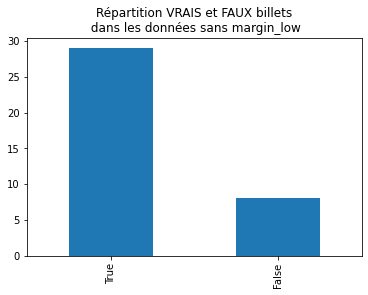

In [27]:
print(billets[billets.margin_low.isna()==True]['is_genuine'].value_counts())
billets[billets.margin_low.isna()==True]['is_genuine'].value_counts().plot.bar()
plt.title('Répartition VRAIS et FAUX billets\n dans les données sans margin_low')
plt.show()

True     0.783784
False    0.216216
Name: is_genuine, dtype: float64


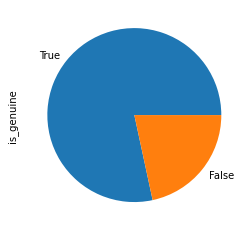

In [28]:
print(billets[billets.margin_low.isna()==True]['is_genuine'].value_counts(normalize=True))
billets[billets.margin_low.isna()==True]['is_genuine'].value_counts(normalize=True).plot.pie()
plt.show()

## 3.2 Préparer dataframe avant lineaire regression

### 3.2.1 Remplacer les données de booleen de is_genuine par 1 (true billet) et 0 (false billet)

In [29]:
# Remplacer valeur booléen de is_genuine par 1 (True) et 0 (False)
billets['is_genuine'].replace({True:1,False:0},inplace=True)
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

### 3.2.2 Séparer dataset selon margin_low disponible ou non
    dataset avec margin low 1463 lignes x 7 colonnes
    dataset sans margin low 37 lignes x 7 colonnes

In [30]:
#Data set avec margin_low
datasetSANSvaleurvide=billets[billets['margin_low'].isna()==False]

#Data set sans margin_low
datasetAVECvaleurvide=billets[billets['margin_low'].isna()==True]

# information de Data set avec margin_low
display('Information de Datasets Sans Valeur manquante',datasetSANSvaleurvide.info())
print('---------------------------------------------------------')
#Information de Data set sans margin_low
display('Information de Datasets Avec Valeur manquante',datasetAVECvaleurvide.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   int64  
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 91.4 KB


'Information de Datasets Sans Valeur manquante'

None

---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     int64  
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.3 KB


'Information de Datasets Avec Valeur manquante'

None

### 3.2.3 Test Assumptions Régression Linéaire

#### Linéarité

    Valeur Moyenne de Résidue est proche de 0
    R Carré: 0.6168760755671029
    Valeur Moyenne de Résidue -1.444883553579151e-16

In [265]:

# Définir les variables et le target pour le test Assumptions Régression Linéaire
xLinearTest=datasetSANSvaleurvide[['is_genuine','diagonal', 'height_left', 'height_right','margin_up', 'length']]
yLinearTest=datasetSANSvaleurvide['margin_low']


#Importer régression linéaire
from sklearn.linear_model import LinearRegression
reg_test = LinearRegression()
reg_test.fit(xLinearTest,yLinearTest)
ypredLinearTest = reg_test.predict(xLinearTest)


#Calculer R2
print("R Carré: {}".format(r2_score(yLinearTest,ypredLinearTest)))


#Calculer Résidue en mettant y réel, y prédiction, résidue dans une dataframe
LinearTest = pd.DataFrame({'Réalité': yLinearTest, 'Prediction': ypredLinearTest})

LinearTest['Residue'] = abs(LinearTest['Réalité']) - abs(LinearTest['Prediction'])



#Calculer la valeur moyenne de Résidue
print("Valeur Moyenne de Résidue {}".format(np.mean(LinearTest['Residue'])))

display(LinearTest.head())

R Carré: 0.6168760755671029
Valeur Moyenne de Résidue -1.444883553579151e-16


Réalité  Prediction   Residue
0     4.52    4.210681  0.309319
1     3.77    4.115999 -0.345999
2     4.40    4.137766  0.262234
3     3.62    4.134463 -0.514463
4     4.04    4.031004  0.008996

#### Prédiction vs Réalité
    Nous voyons via la graphique la prédiction ne suit pas la ligne diagonale.
    Il rassemble qu'il donne une valeur moyenne par classes

<Figure size 864x432 with 0 Axes>

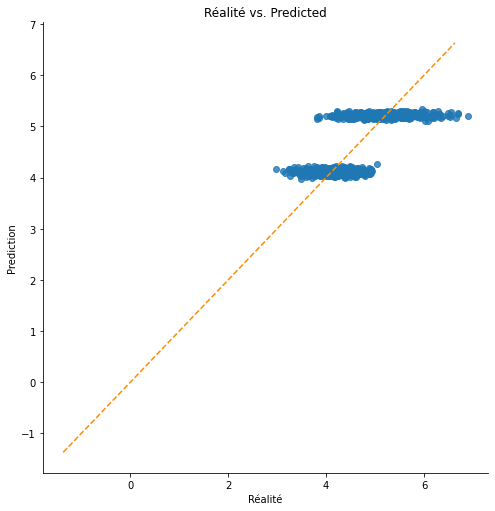

In [267]:

#Comparer Prédiction et la réalité
plt.figure(figsize=(12, 6))
sns.lmplot(x='Réalité', y='Prediction', data=LinearTest, fit_reg=False, size=7)      

# Créer ligne diagonale
line_coords = np.arange(LinearTest.min().min(), LinearTest.max().max())
plt.plot(line_coords, line_coords,
             color='darkorange', linestyle='--')

plt.title('Réalité vs. Predicted')
plt.show()

#### Homoscedasticity
    p-value', 1.0981448737814192e-31 < 0.05
    Résidue est heteroscedastique


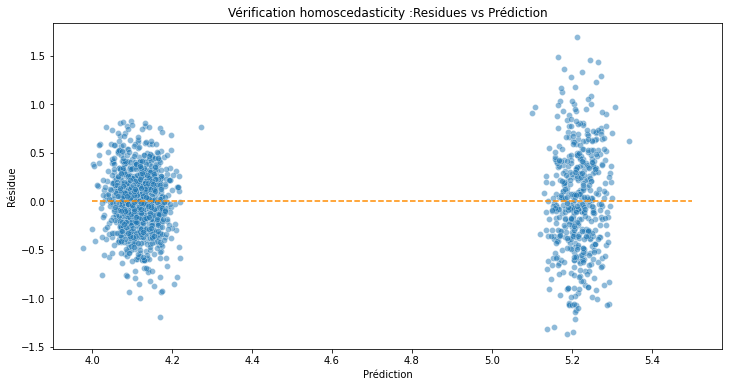

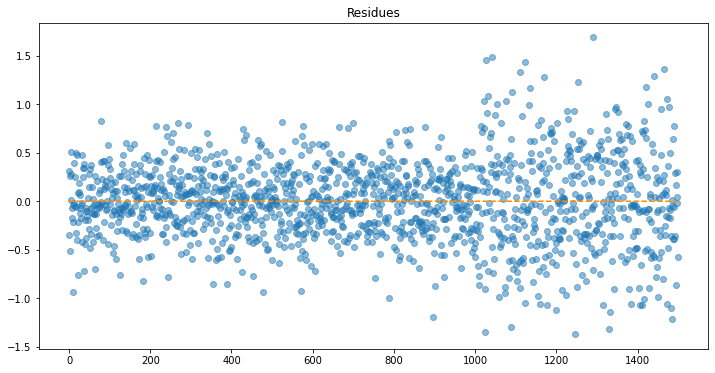

In [268]:

#Visualiser les résidues en fonction de prédiction par graphique
plt.subplots(figsize=(12, 6))
p = sns.scatterplot(LinearTest['Prediction'],LinearTest['Residue'],alpha=0.5)
plt.xlabel('Prédiction')
plt.ylabel('Résidue')
p = sns.lineplot([4,5.5],[0,0],color='darkorange', linestyle='--')
p = plt.title('Vérification homoscedasticity :Residues vs Prédiction')
plt.show()

#Visualiser les positions de résidues selon les index
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111) 
plt.scatter(x=LinearTest.index, y=LinearTest.Residue, alpha=0.5)
plt.plot(np.repeat(0, LinearTest.index.max()), color='darkorange', linestyle='--')
plt.title('Residues')
plt.show()


#####     Vérifier Hereroscedasticité Goldfeld Quandt Test

    H0: Résidue est homoscedastique
    H1: Résidue est heteroscedastique.
    
##### P-value < 0.05 donc nous  rejetter H0, Résidue est heteroscedastique

In [269]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
Nom = ['F statistic', 'p-value']
testgoldfeld = sms.het_goldfeldquandt(LinearTest.Residue, xLinearTest)
lzip(Nom, testgoldfeld)

[('F statistic', 2.408724406277588), ('p-value', 1.0981448737814192e-31)]

#### Normalité Résidue
    P-value de test Distribution Normale Anderson-Darling: 3.9857722331535204e-05 < 0.05
    La distribution de résidues est une distribution normale

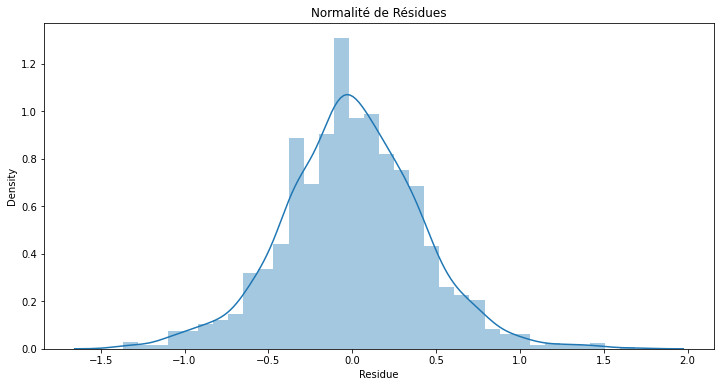

In [270]:
plt.subplots(figsize=(12, 6))
sns.distplot(LinearTest.Residue,kde=True)
plt.title('Normalité de Résidues')
plt.show()

##### Anderson-Darling test pour tester distribution Normale
    H0:La distribution de résidues n'est pas une distribution normale
    H1: La distribution de résidues est une distribution normale
##### P-value < 0.05, on rejette hypothèse 0, la distribution des résidues est une distribution normale

In [271]:
from statsmodels.stats.diagnostic import normal_ad
p_value = normal_ad(LinearTest['Residue'])[1]
print('P-value de test Distribution Normale Anderson-Darling:',p_value)

P-value de test Distribution Normale Anderson-Darling: 3.9857722331535204e-05


#### Autocorrélation

##### Tester Autocorrélation avec ljungbox
    H0: Autocorrélation est absente
    H1: Autocorrélation est présente
##### P-value > 0.05, donc nous ne rejette pas la hypothèse 0, l'Autocorrélation est absent

In [283]:
from statsmodels.stats import diagnostic as diag
ljungbox=diag.acorr_ljungbox(LinearTest['Residue'] , lags = 40)
min(ljungbox['lb_pvalue'])

0.05809403513532395

#### MultiCollinéarité

    Tous les facteurs inflations de la variance sont > 10, il y a une collinéarité élevé,
    il y faut bien consiérer de enlever certain variable avec une haut vaeur de facteur ou pénaliser les variables avec haut corrélations.
    


Calculer Variance Facteur Inflation
is_genuine: 13.897077620730618
diagonal: 171285.35846317228
height_left: 118586.7715307572
height_right: 113601.44450804252
margin_up: 297.9518962919934
length: 54001.883366637325


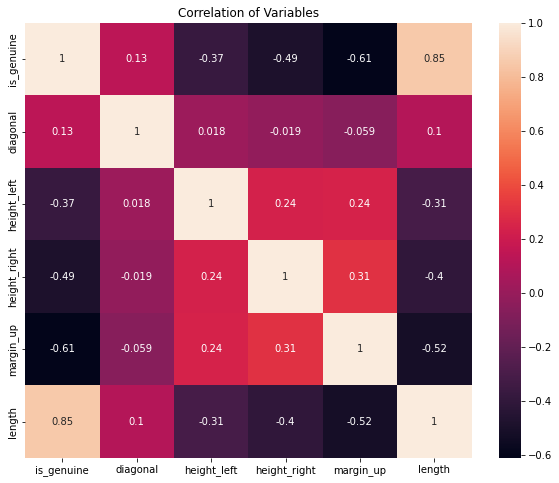

In [285]:


print('Facteur Inflation de la variance')
VIF = [variance_inflation_factor(xLinearTest, i) for i in range(xLinearTest.shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(xLinearTest.columns[idx], vif))
    


from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.figure(figsize = (10,8))
sns.heatmap(pd.DataFrame(xLinearTest, columns=xLinearTest.columns).corr(), annot=True)
plt.title('Correlation of Variables')
plt.show()



## 3.3 Utiliser dataframe avec l'information de margin_low pour trouver la meilleure lineaire regression 
    définir Margin_low est traget
    Séparer la dataframe en target et variables avec 25% et 75%
    

In [31]:

variableSansvaleurvide=datasetSANSvaleurvide.drop('margin_low',axis=1)
tragetSansvaleurvide=datasetSANSvaleurvide['margin_low']

### 3.3.1 Séparer les variables en trainset et testset
    25% testset (traget et variable)
    75% trainset  (traget et variable)
    random_state=123 (fixer la sélection des échantillons)

In [32]:
from sklearn.model_selection import train_test_split
x_trainSV, x_testSV, y_trainSV, y_testSV = train_test_split(variableSansvaleurvide, 
                                                    tragetSansvaleurvide, 
                                                    test_size = 0.25, random_state=123)
#Vérifier la dimension de variable transet, variable testset, traget transet, traget testset, 
print(x_trainSV.shape)
print(x_testSV.shape)
print(y_trainSV.shape)
print(y_testSV.shape)

(1097, 6)
(366, 6)
(1097,)
(366,)


### 3.3.2 Centrée et réduit les données avec StandardScaler avant regression lineaire

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#Fit_transformer Variable trainset
scaler.fit(x_trainSV)
x_trainScaled = scaler.transform(x_trainSV)

#Transformer Variable testset
x_testScaled = scaler.transform(x_testSV)

### 3.3.3 Sélectionner la meilleure lineaire regression

#### 3.3.3.1 Entrainner regression lineaire simple
    
    Moyen Cross Validation Score R2: 
        0.6044666641491554
    Ecart type Cross Validation Score R2: 
        0.023590248473825636
    
    
    Intercept de lrSimple: 
        4.488705560619873 
    
    les coefficients de variable dans lrSimple: 
        [('is_genuine', -0.5368047726985943), 
        ('diagonal', -0.0026960939695143717), 
        ('height_left', 0.014920944342142368), 
        ('height_right', 0.013255767207406743), 
        ('margin_up', -0.058575365310506264), 
        ('length', -0.00955602769512119)]

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

#Importer et entrainer linéaire regression basique avec variable trainset centrée réduit et traget trainset
lrSimple = LinearRegression().fit(x_trainScaled, y_trainSV)

#Evaluer model basique avec cross validation (5 paritions de données)
lrSimpleCVScore = cross_val_score(LinearRegression(),
                             x_trainScaled,
                             y_trainSV,
                             cv=5,
                             scoring='r2')
#Calculer moyenne de score R2 de model en cross validation
MoyenlrSimpleCVScore=np.mean(lrSimpleCVScore)

#Calculer écart type de score R2 de model en cross validation
stdlrSimpleCVScore=np.std(lrSimpleCVScore)

In [35]:
#Imprimer moyenne et écart type de score R2 de model en cross validation
print('MoyenlrSimpleCVScore:',MoyenlrSimpleCVScore)
print('stdlrSimpleCVScore:',stdlrSimpleCVScore)

MoyenlrSimpleCVScore: 0.6044666641491554
stdlrSimpleCVScore: 0.023590248473825636


In [36]:
#Définir nom des colonnes des variable comme variable feature_names
feature_names = variableSansvaleurvide.columns

##### Affichier Intercept et les coéfficients des variables de model basique

Intercept de lrSimple: 4.488705560619873 
les coefficients de variable dans lrSimple: [('is_genuine', -0.5368047726985943), ('diagonal', -0.0026960939695143717), ('height_left', 0.014920944342142368), ('height_right', 0.013255767207406743), ('margin_up', -0.058575365310506264), ('length', -0.00955602769512119)]


NomVariable  Coéfficient
0    is_genuine    -0.536805
1      diagonal    -0.002696
2   height_left     0.014921
3  height_right     0.013256
4     margin_up    -0.058575
5        length    -0.009556
6     intercept     4.488706

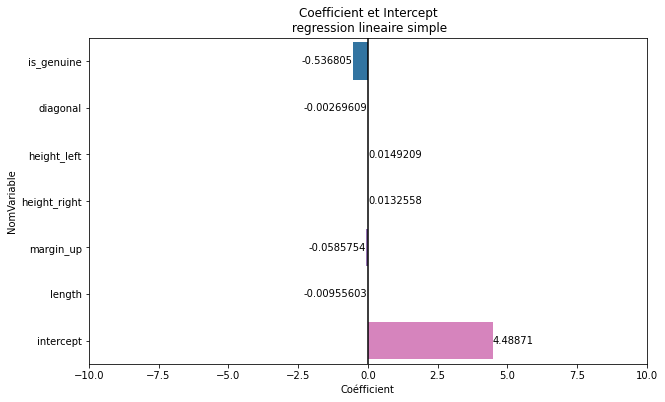

In [37]:
# Imprimer coeffcient et intercept de model linéaire regression basique

print('Intercept de lrSimple:',lrSimple.intercept_,
      '\nles coefficients de variable dans lrSimple:',
      list(zip(feature_names, lrSimple.coef_)))

# Mettre les coeffcients des variables et intercept dans une dataframe
lrSimpleCoef=pd.DataFrame(list(zip(feature_names, lrSimple.coef_))).rename(columns={0:'NomVariable',1:'Coéfficient'})

lrSimpleIntercept = {'NomVariable':'intercept',
               'Coéfficient':lrSimple.intercept_}

lrSimpleCoef = lrSimpleCoef.append(lrSimpleIntercept, ignore_index=True)

display(lrSimpleCoef)

#Visualiser les coeffcients des variables et intercept avec barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='NomVariable',x='Coéfficient',data=lrSimpleCoef,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-10,10)
plt.axvline(x=0.0,color='k')
plt.title('Coefficient et Intercept\n regression lineaire simple')
plt.show()

##### Calculer MAE, MSE, RMSE,R2 de model basique
    lrSimple_MAE 0.8941681174627396
    lrSimple_MSE 0.9673835077064107
    lrSimple_RMSE 0.9835565605019422
    lrSimple_R2 -1.293848833883755

In [38]:
from sklearn.metrics import r2_score

ypred_lrSimple=lrSimple.predict(x_testSV)
lrSimple_MAE=metrics.mean_absolute_error(y_testSV, ypred_lrSimple)
lrSimple_MSE=metrics.mean_squared_error(y_testSV, ypred_lrSimple)
lrSimple_RMSE=np.sqrt(metrics.mean_squared_error(y_testSV, ypred_lrSimple))
lrSimple_R2=r2_score(y_testSV, ypred_lrSimple)
print('lrSimple_MAE',lrSimple_MAE)
print('lrSimple_MSE',lrSimple_MSE)
print('lrSimple_RMSE',lrSimple_RMSE)
print('lrSimple_R2',lrSimple_R2)

lrSimple_MAE 0.8941681174627396
lrSimple_MSE 0.9673835077064107
lrSimple_RMSE 0.9835565605019422
lrSimple_R2 -1.293848833883755


##### Comparer prédiction de traget et traget réel de model basique par viasualisation
    y prédiction est bien distingué en 2 groupes comme nous avons vu la corrélation forte entre margin_low et le traget is_genuine

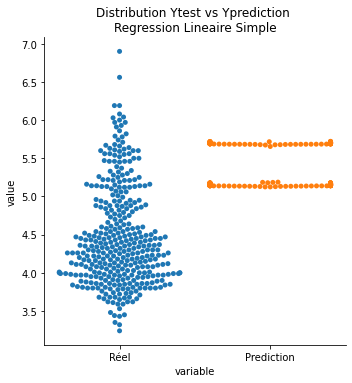

In [39]:
dfSP = pd.DataFrame({'Réel': y_testSV, 'Prediction': ypred_lrSimple})
dfSP=pd.melt(dfSP,value_vars =['Réel','Prediction'])

sns.catplot(data=dfSP, x="variable", y="value", kind="swarm")
plt.title('Distribution Ytest vs Yprediction \nRegression Lineaire Simple')
plt.show()

##### Comparer prédiction de traget et traget réel de model basique par variable via viasualisation
    y prédiction est bien distingué en 2 groupes comme nous avons vu la corrélation forte entre margin_low et le traget is_genuine

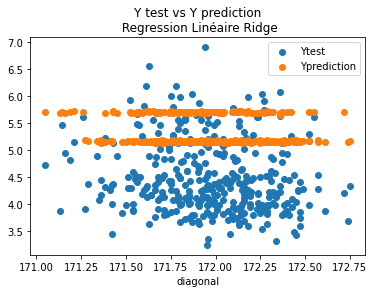

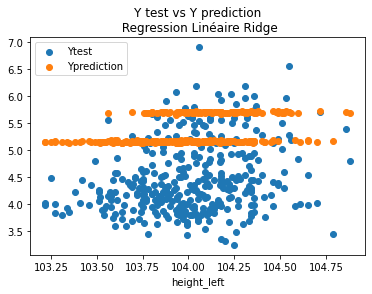

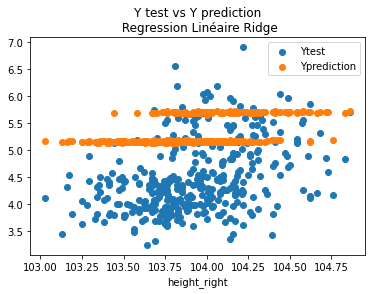

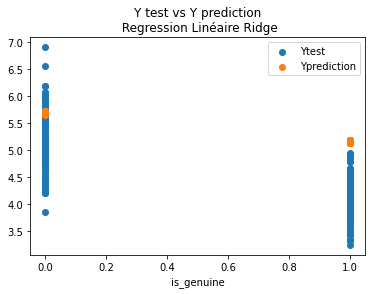

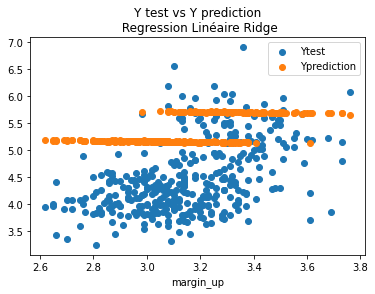

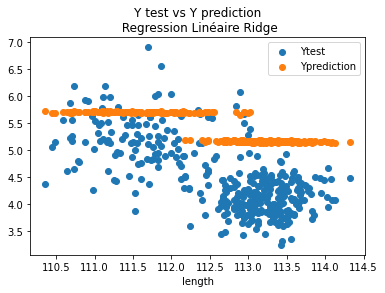

In [40]:
for i in ['diagonal', 'height_left', 'height_right', 'is_genuine','margin_up', 'length']:
    plt.scatter(y=y_testSV,x=x_testSV[i],label="Ytest")
    plt.scatter(y=ypred_lrSimple,x=x_testSV[i],label="Yprediction")
    plt.xlabel(i)
    plt.legend()
    plt.title('Y test vs Y prediction\n Regression Linéaire Ridge')
    plt.show()

#### 3.3.3.2 Model Regression Linéaire Ridge
    
    Best Params:  {'alpha': 1}
    
    Moyenne Cross validation score R2: 0.6044845197678004
    Ecart type Cross validation score R2: 0.023467419378890884
    
    Intercept de lrSimple: 4.488705560619873 
    
    les coefficients de variable dans lrSimple: 
        [('is_genuine', -0.5345302448408201), 
        ('diagonal', -0.0027975767081693534), 
        ('height_left', 0.015097043479520164), 
        ('height_right', 0.013569526517346962), 
        ('margin_up', -0.05802744079930742), 
        ('length', -0.010993968520628528)]
        
        
    Ridge_MAE 0.7845524566628516
    Ridge_MSE 0.7669205678521888
    Ridge_RMSE 0.8757400115629003
    Ridge_R2 -0.8185133778227554

##### Trouver la meilleure alpha de regression linéaire Ridge
    Best Params:  {'alpha': 1}

In [41]:
from sklearn.linear_model import Ridge

#Importer Linéaire regression Ridge
lr_ridge = Ridge(random_state=123)

#Définir le liste des alpha à évaluer
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

#Trouver la meilleure alpha avec GridSearchCV
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lr_ridge, param_grid=param_grid, scoring='r2', cv=5)
grid_result = grid.fit(x_trainScaled, y_trainSV)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.6044845197678004
Best Params:  {'alpha': 1}


##### Appliquer le model régression linéaire ridge avec la meilleure paramétre
    Moyenlr_ridge_bestCVScore 0.6044845197678004
    stdlr_ridge_bestCVScore 0.023467419378890884

In [42]:
#Apploquer la régression linéaire Ridge avec le meilleur Alpha trouvé et fixer la sélection des échantillons avec random_state=123
lr_ridge_best = Ridge(alpha=1,random_state=123).fit(x_trainScaled, y_trainSV)

#Evaluer model Regression linéaire ridge avec la cross validation
lr_ridge_bestCVScore = cross_val_score(Ridge(alpha=1,random_state=123),
                             x_trainScaled,
                             y_trainSV,
                             cv=5,
                             scoring='r2')
Moyenlr_ridge_bestCVScore=np.mean(lr_ridge_bestCVScore)
stdlr_ridge_bestCVScore=np.std(lr_ridge_bestCVScore)

#Imprimer la moyenne et l'écart type de score cross validation de model régression linéaire ridge
print('Moyenlr_ridge_bestCVScore',Moyenlr_ridge_bestCVScore)
print('stdlr_ridge_bestCVScore',stdlr_ridge_bestCVScore)

Moyenlr_ridge_bestCVScore 0.6044845197678004
stdlr_ridge_bestCVScore 0.023467419378890884


##### Affichier et Visualiser les coéfficients des variables et l'intercept de model régression linéaire Ridge
    
    Intercept de lrSimple: 4.488705560619873 
    les coefficients de variable dans lrSimple: [('is_genuine', -0.5345302448408201), ('diagonal', -0.0027975767081693534), ('height_left', 0.015097043479520164), ('height_right', 0.013569526517346962), ('margin_up', -0.05802744079930742), ('length', -0.010993968520628528)]

Intercept de Ridge: 4.488705560619873 
les coefficients de variable dans Ridge: [('is_genuine', -0.5345302448408201), ('diagonal', -0.0027975767081693534), ('height_left', 0.015097043479520164), ('height_right', 0.013569526517346962), ('margin_up', -0.05802744079930742), ('length', -0.010993968520628528)]


NomVariable  Coéfficient
0    is_genuine    -0.534530
1      diagonal    -0.002798
2   height_left     0.015097
3  height_right     0.013570
4     margin_up    -0.058027
5        length    -0.010994
6     intercept     4.488706

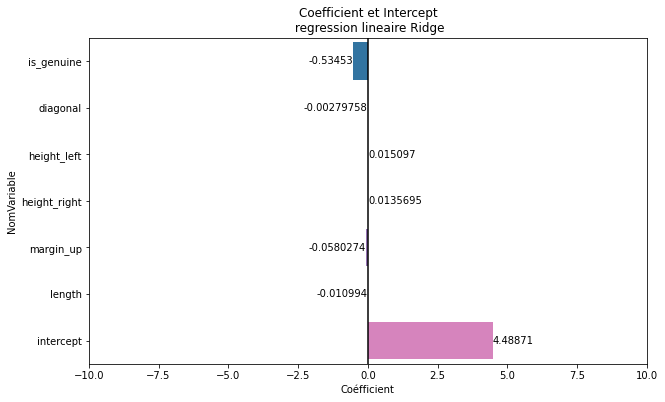

In [43]:
print('Intercept de Ridge:',lr_ridge_best.intercept_,
      '\nles coefficients de variable dans Ridge:',
      list(zip(feature_names, lr_ridge_best.coef_)))

lrRidgeCoef=pd.DataFrame(list(zip(feature_names, lr_ridge_best.coef_))).rename(columns={0:'NomVariable',1:'Coéfficient'})


lrRidgeIntercept = {'NomVariable':'intercept',
               'Coéfficient':lr_ridge_best.intercept_}

lrRidgeCoef = lrRidgeCoef.append(lrRidgeIntercept, ignore_index=True)

display(lrRidgeCoef)


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='NomVariable',x='Coéfficient',data=lrRidgeCoef,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-10,10)
plt.axvline(x=0.0,color='k')
plt.title('Coefficient et Intercept\n regression lineaire Ridge')
plt.show()

##### Calculer MAE,MSE,RMSE, et R2 de model Ridge

In [44]:
ypred_lrRidge=lr_ridge_best.predict(x_testSV)

Ridge_MAE=metrics.mean_absolute_error(y_testSV, ypred_lrRidge)
Ridge_MSE=metrics.mean_squared_error(y_testSV, ypred_lrRidge)
Ridge_RMSE=np.sqrt(metrics.mean_squared_error(y_testSV, ypred_lrRidge))
Ridge_R2=r2_score(y_testSV, ypred_lrRidge)

print('Ridge_MAE',Ridge_MAE)
print('Ridge_MSE',Ridge_MSE)
print('Ridge_RMSE',Ridge_RMSE)
print('Ridge_R2',Ridge_R2)

Ridge_MAE 0.7845524566628516
Ridge_MSE 0.7669205678521888
Ridge_RMSE 0.8757400115629003
Ridge_R2 -0.8185133778227554


##### Comparer et visualiser ytest et la préduction de régression linéaire ridge

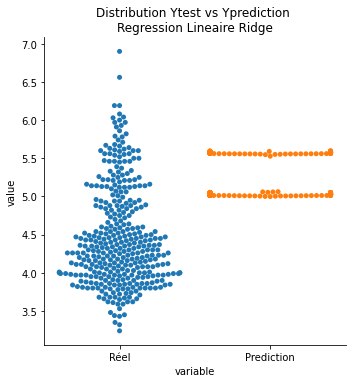

In [45]:
dfRG = pd.DataFrame({'Réel': y_testSV, 'Prediction': ypred_lrRidge})
dfRG=pd.melt(dfRG,value_vars =['Réel','Prediction'])

sns.catplot(data=dfRG, x="variable", y="value", kind="swarm")
plt.title('Distribution Ytest vs Yprediction \nRegression Lineaire Ridge')
plt.show()

##### Comparer et visualiser ytest et la préduction de régression linéaire ridge par variable

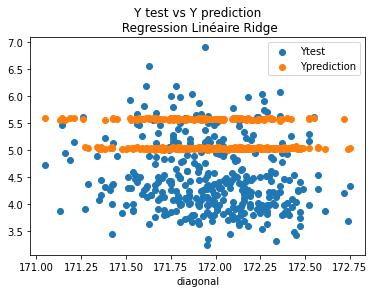

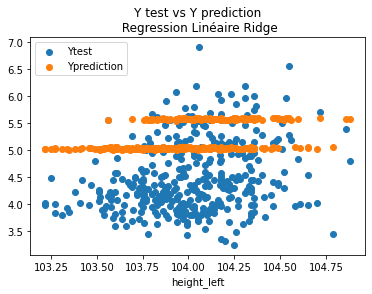

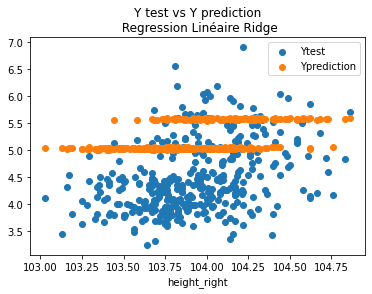

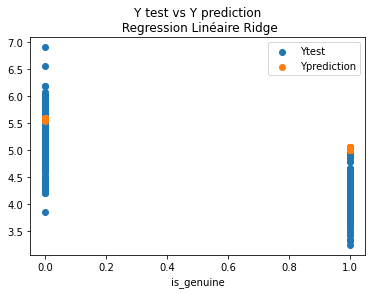

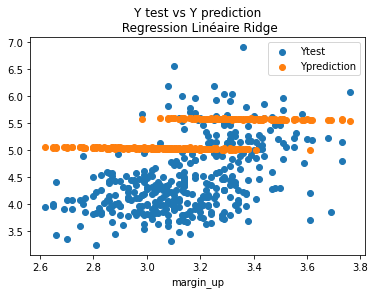

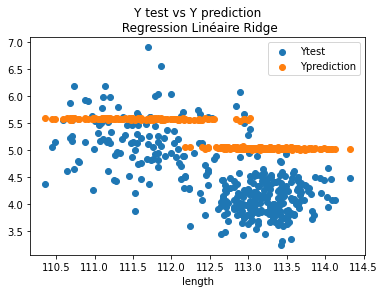

In [46]:
for i in ['diagonal', 'height_left', 'height_right', 'is_genuine','margin_up', 'length']:
    plt.scatter(y=y_testSV,x=x_testSV[i],label="Ytest")
    plt.scatter(y=ypred_lrRidge,x=x_testSV[i],label="Yprediction")
    plt.xlabel(i)
    plt.legend()
    plt.title('Y test vs Y prediction\n Regression Linéaire Ridge')
    plt.show()

#### 3.3.3.3 Entrainner regression lineaire lasso
    Best Params:  {'alpha': 0.001}
    
    Evaluation cross validation Lasso de trainset:
    
    Moyenne Cross Validation Score 0.6045758980421962
    Ecart type cross validation score 0.02298679850859879
    
    
    Intercept de lrSimple: 
        4.488705560619873 
    
    les coefficients de variable dans lrSimple:
    
        [('is_genuine', -0.5354373346970203), 
        ('diagonal', -0.0017569126199492178), 
        ('height_left', 0.014141515192041144), 
        ('height_right', 0.012629110195711054), 
        ('margin_up', -0.05605275202007291), 
        ('length', -0.009012104150668563)]
    
    
    Evaluation de prédiction Lasso:
        Lasso_MAE 0.9720112670153676
        Lasso_MSE 1.1224996292763625
        Lasso_RMSE 1.0594808300655385
        Lasso_R2 -1.6616584272304613
    

##### Identifier le meilleur alpha de Régression Linéaire Lasso
    Best Params:  {'alpha': 0.001}

In [47]:
from sklearn.linear_model import Lasso
lr_lasso = Lasso(random_state=123)

alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lr_lasso, param_grid=param_grid, scoring='r2', cv=5)
grid_result = grid.fit(x_trainScaled, y_trainSV)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.6045758980421962
Best Params:  {'alpha': 0.001}


##### Appliquer Regression Linéaire Lasso 
        Moyenne Cross Validation Score 0.6045758980421962
        Ecart type cross validation score 0.02298679850859879

In [48]:

#Appliquer model Lasso avec le meilleur Alpha 0.001 et fixer la sélection de échantillons avec random_state=123
lr_lasso_best = Lasso(alpha=0.001,random_state=123).fit(x_trainScaled, y_trainSV)

#Evaluer model Lasso avec cross validation score
lr_lasso_bestCVScore = cross_val_score(Lasso(alpha=0.001,random_state=123),
                             x_trainScaled,
                             y_trainSV,
                             cv=5,
                             scoring='r2')
Moyenlr_lasso_bestCVScore=np.mean(lr_lasso_bestCVScore)
stdlr_lasso_bestCVScore=np.std(lr_lasso_bestCVScore)

#Imprimer Moyenne et Ecart type de cross validation score R2 de model Lasso
print('Moyenlr_lasso_bestCVScore',Moyenlr_lasso_bestCVScore)
print('stdlr_lasso_bestCVScore',stdlr_lasso_bestCVScore)

Moyenlr_lasso_bestCVScore 0.6045758980421962
stdlr_lasso_bestCVScore 0.02298679850859879


##### Affichier et visualiser les coéfficients des variables et l'intercept de model Lasso

Intercept de lrSimple: 4.488705560619873 
les coefficients de variable dans lrSimple: [('is_genuine', -0.5354373346970203), ('diagonal', -0.0017569126199492178), ('height_left', 0.014141515192041144), ('height_right', 0.012629110195711054), ('margin_up', -0.05605275202007291), ('length', -0.009012104150668563)]


NomVariable  Coéfficient
0    is_genuine    -0.535437
1      diagonal    -0.001757
2   height_left     0.014142
3  height_right     0.012629
4     margin_up    -0.056053
5        length    -0.009012
6     intercept     4.488706

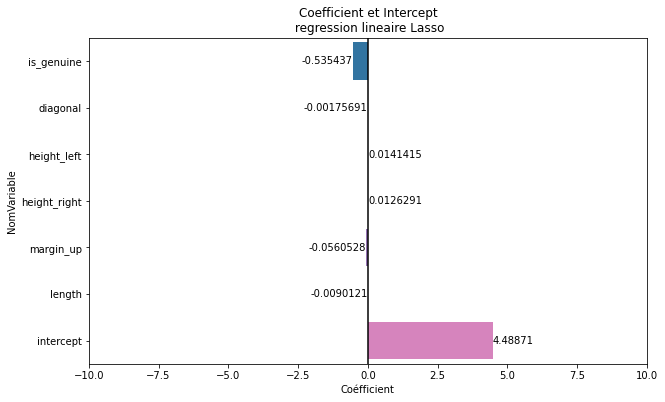

In [49]:
#Imprimer les coéfficients et l'intercept de model Lasso
print('Intercept de lrSimple:',lr_lasso_best.intercept_,
      '\nles coefficients de variable dans lrSimple:',
      list(zip(feature_names, lr_lasso_best.coef_)))

#Mettre les coéfficients et l'intercept dans une dataframe
lrLassoCoef=pd.DataFrame(list(zip(feature_names, lr_lasso_best.coef_))).rename(columns={0:'NomVariable',1:'Coéfficient'})

lrLassoIntercept = {'NomVariable':'intercept',
               'Coéfficient':lr_lasso_best.intercept_}

lrLassoCoef = lrLassoCoef.append(lrLassoIntercept, ignore_index=True)

display(lrLassoCoef)

#Visualiser avec barplot les coéfficients et l'intercept
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='NomVariable',x='Coéfficient',data=lrLassoCoef,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-10,10)
plt.axvline(x=0.0,color='k')
plt.title('Coefficient et Intercept\n regression lineaire Lasso')
plt.show()

##### Prédire traget avec testset et Calculer les scores de évaluation Lasso

In [50]:
#Prédiction de traget de testset avec lasso
ypred_lrLasso=lr_lasso_best.predict(x_testSV)

#calculer les scores de évaluation
Lasso_MAE=metrics.mean_absolute_error(y_testSV, ypred_lrLasso)
Lasso_MSE=metrics.mean_squared_error(y_testSV, ypred_lrLasso)
Lasso_RMSE=np.sqrt(metrics.mean_squared_error(y_testSV, ypred_lrLasso))
Lasso_R2=r2_score(y_testSV, ypred_lrLasso)
print('Lasso_MAE',Lasso_MAE)
print('Lasso_MSE',Lasso_MSE)
print('Lasso_RMSE',Lasso_RMSE)
print('Lasso_R2',Lasso_R2)

Lasso_MAE 0.9720112670153676
Lasso_MSE 1.1224996292763625
Lasso_RMSE 1.0594808300655385
Lasso_R2 -1.6616584272304613


##### Comparer et Visualiser ytest et prédiction de model Lasso 

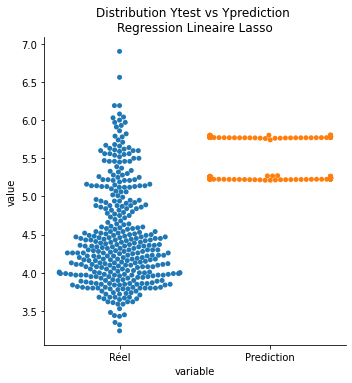

In [51]:
dfLA = pd.DataFrame({'Réel': y_testSV, 'Prediction': ypred_lrLasso})
dfLA=pd.melt(dfLA,value_vars =['Réel','Prediction'])

sns.catplot(data=dfLA, x="variable", y="value", kind="swarm")
plt.title('Distribution Ytest vs Yprediction \nRegression Lineaire Lasso')
plt.show()

##### Comparer et Visualiser ytest et prédiction de model Lasso par variable 

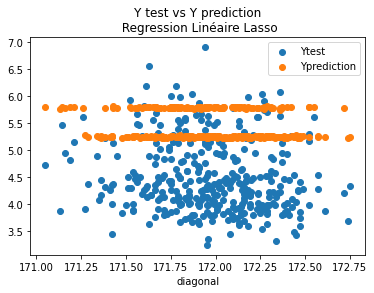

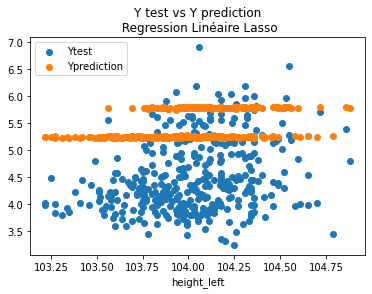

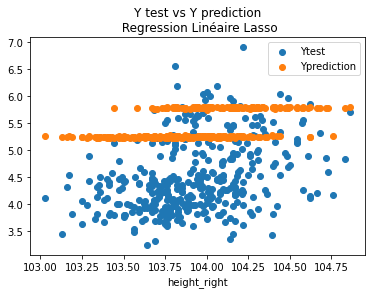

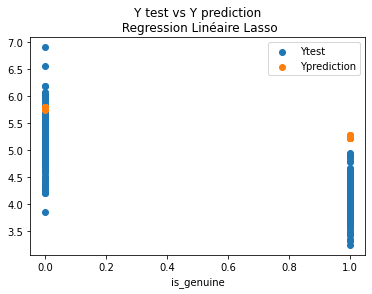

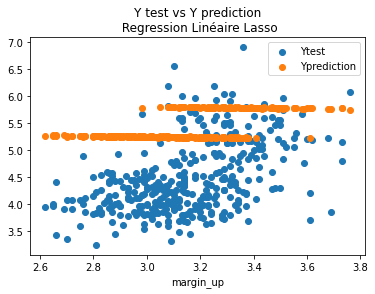

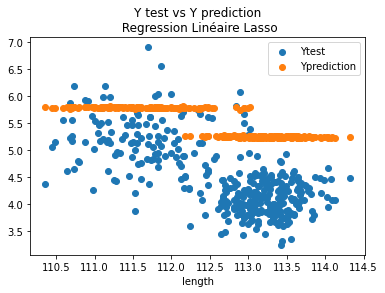

In [52]:
for i in ['diagonal', 'height_left', 'height_right', 'is_genuine','margin_up', 'length']:
    plt.scatter(y=y_testSV,x=x_testSV[i],label="Ytest")
    plt.scatter(y=ypred_lrLasso,x=x_testSV[i],label="Yprediction")
    plt.xlabel(i)
    plt.legend()
    plt.title('Y test vs Y prediction\n Regression Linéaire Lasso')
    plt.show()

####  3.3.3.4 Entrainner regression lineaire ElasticNet
    
    Best Params:  {'alpha': 0.01, 'l1_ratio': 0.5}
    
    Evaluation Train Set avec Cross Validation:
        Moyen CV score Elastic Net: 0.6046540407647156
        Ecart type CV score Elastic Net: 0.020219406326011376
    
    Coéfficients des variables et l'intercept de Elastic Net avec les meilleures paramétres:
    
        Intercept de lrSimple: 4.488705560619873 
        les coefficients de variable dans lrSimple: 
            [('is_genuine', -0.51791726763881), 
            ('diagonal', -0.0), 
            ('height_left', 0.012105442408065784), 
            ('height_right', 0.011826050869919835), 
            ('margin_up', -0.04312426534776201), 
            ('length', -0.014269859473184205)]
    
    
    Qualité de prédiction Elastic Net:
        Elasticnet_MAE 0.5435801052102807
        Elasticnet_MSE 0.39779203138809743
        Elasticnet_RMSE 0.6307075640802934
        Elasticnet_R2 0.05676003357629844

##### Identifier les meilleures paramétres model régression lineaire ElasticNet
    Les meilleures paramétres: Best Params:  {'alpha': 0.01, 'l1_ratio': 0.5}
    

In [53]:
from sklearn.linear_model import ElasticNet

lr_elastic_net = ElasticNet(random_state=123)

alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=lr_elastic_net, param_grid=param_grid, scoring='r2', cv=5)
grid_result = grid.fit(x_trainScaled, y_trainSV)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.6046540407647156
Best Params:  {'alpha': 0.01, 'l1_ratio': 0.5}


##### Appliquer les meilleures paramétres et fixer la sélection d'échantillons avec random_state=123 et Calculer CV score de model Elastic Net 

In [54]:
elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.5,random_state=123).fit(x_trainScaled, y_trainSV)
elastic_net_bestCVScore = cross_val_score(ElasticNet(alpha=0.01, l1_ratio=0.5,random_state=123),
                             x_trainScaled,
                             y_trainSV,
                             cv=5,
                             scoring='r2')
Moyenlr_elastic_net_bestCVScore=np.mean(elastic_net_bestCVScore)
stdlr_elastic_net_bestCVScore=np.std(elastic_net_bestCVScore)

print('Moyenlr_elastic_net_bestCVScore',Moyenlr_elastic_net_bestCVScore)
print('stdlr_elastic_net_bestCVScore',stdlr_elastic_net_bestCVScore)

Moyenlr_elastic_net_bestCVScore 0.6046540407647156
stdlr_elastic_net_bestCVScore 0.020219406326011376


##### Affichier et Visualiser les coéfficients des variable et l'intercept de model Elastic Net

Intercept de lrSimple: 4.488705560619873 
les coefficients de variable dans lrSimple: [('is_genuine', -0.51791726763881), ('diagonal', -0.0), ('height_left', 0.012105442408065784), ('height_right', 0.011826050869919835), ('margin_up', -0.04312426534776201), ('length', -0.014269859473184205)]


NomVariable  Coéfficient
0    is_genuine    -0.535437
1      diagonal    -0.001757
2   height_left     0.014142
3  height_right     0.012629
4     margin_up    -0.056053
5        length    -0.009012
6     intercept     4.488706

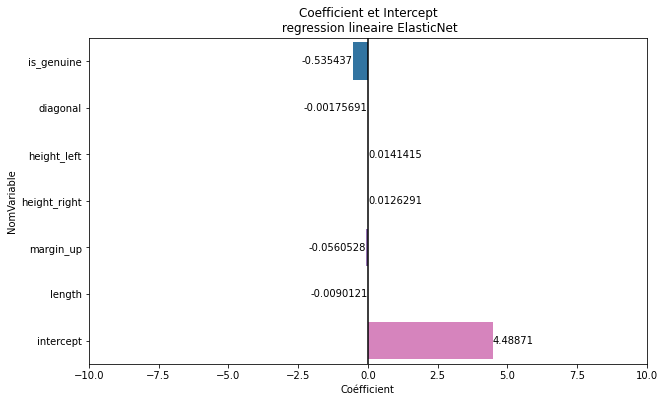

In [55]:
#Affichier l'intercept et les coéfficients
print('Intercept de lrSimple:',elastic_net.intercept_,
      '\nles coefficients de variable dans lrSimple:',
      list(zip(feature_names, elastic_net.coef_)))

#Mettre les coéfficients et l'intercept dans une dataframe
pd.DataFrame(list(zip(feature_names, elastic_net.coef_))).rename(columns={0:'NomVariable',1:'Coéfficient'})


lrElasticNetCoef=pd.DataFrame(list(zip(feature_names, lr_lasso_best.coef_))).rename(columns={0:'NomVariable',1:'Coéfficient'})

lrElasticNetIntercept = {'NomVariable':'intercept',
               'Coéfficient':elastic_net.intercept_}

lrElasticNetCoef = lrElasticNetCoef.append(lrElasticNetIntercept, ignore_index=True)

display(lrElasticNetCoef)

#Visualiser les coéfficients et l'intercept avec barplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='NomVariable',x='Coéfficient',data=lrElasticNetCoef,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.axvline(x=0.0,color='k')
plt.xlim(-10,10)
plt.title('Coefficient et Intercept\n regression lineaire ElasticNet')
plt.show()

##### Evaluer la qualité de prédiction de model Elastic Net avec MAE, MSE, RMSE,R2
    Elasticnet_MAE 0.5435801052102807
    Elasticnet_MSE 0.39779203138809743
    Elasticnet_RMSE 0.6307075640802934
    Elasticnet_R2 0.05676003357629844

In [56]:
ypred_lrElastic=elastic_net.predict(x_testSV)
Elasticnet_MAE=metrics.mean_absolute_error(y_testSV, ypred_lrElastic)
Elasticnet_MSE=metrics.mean_squared_error(y_testSV, ypred_lrElastic)
Elasticnet_RMSE=np.sqrt(metrics.mean_squared_error(y_testSV, ypred_lrElastic))
Elasticnet_R2=r2_score(y_testSV, ypred_lrElastic)
print('Elasticnet_MAE',Elasticnet_MAE)
print('Elasticnet_MSE',Elasticnet_MSE)
print('Elasticnet_RMSE',Elasticnet_RMSE)
print('Elasticnet_R2',Elasticnet_R2)

Elasticnet_MAE 0.5435801052102807
Elasticnet_MSE 0.39779203138809743
Elasticnet_RMSE 0.6307075640802934
Elasticnet_R2 0.05676003357629844


##### Comparer et Visualiser ytest et prédiction de test set

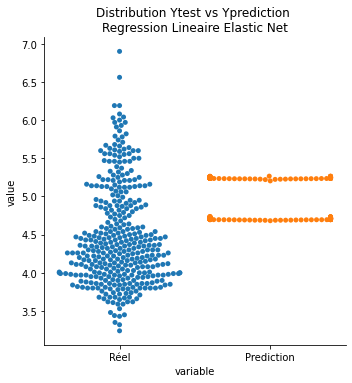

In [57]:
dfEN = pd.DataFrame({'Réel': y_testSV, 'Prediction': ypred_lrElastic})
dfEN=pd.melt(dfEN,value_vars =['Réel','Prediction'])

sns.catplot(data=dfEN, x="variable", y="value", kind="swarm")
plt.title('Distribution Ytest vs Yprediction \nRegression Lineaire Elastic Net')
plt.show()

##### Comparer et Visualiser ytest et prédiction de test set par variable

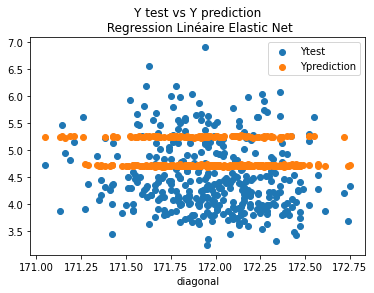

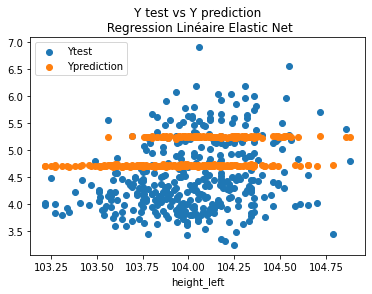

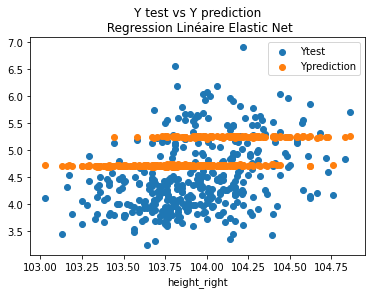

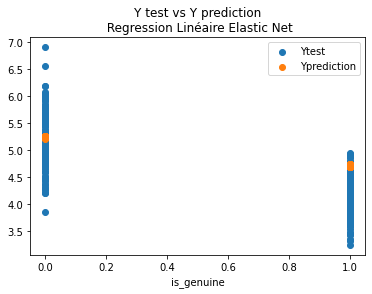

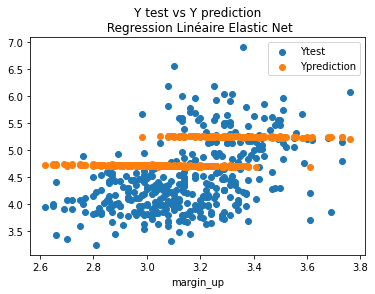

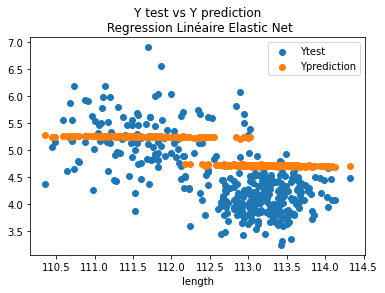

In [58]:
for i in ['diagonal', 'height_left', 'height_right', 'is_genuine','margin_up', 'length']:
    plt.scatter(y=y_testSV,x=x_testSV[i],label="Ytest")
    plt.scatter(y=ypred_lrElastic,x=x_testSV[i],label="Yprediction")
    plt.xlabel(i)
    plt.legend()
    plt.title('Y test vs Y prediction\n Regression Linéaire Elastic Net')
    plt.show()

    


#### 3.3.3.5 Choisir et Appliquer le meilleur model regression lineaire : Elastic Net avec paramétre
    
    Elastic net est sélectionné comme le model le plus performant de regression lineaire pour prédire margin_low

    Nous prédirons le margin_low avec la meilleure paramétre de Elastic net identifié via GridSearch.
    
    Evaluation train set:
        Elastic Net a le plus petit Ecart type de score cv 0.020219 
        La moyenne de CV score de Elastic Net est légère important que les autres, mais l'impact est limité comme la différence est minimum entre les models
    
    Evaluation test set:
    
        Elastic Net est le plus performant model avec l'évaluation de MAE, MSE, RMSE,R2
    
    Rappel des paramétres Elastic Net:
        ElasticNet(alpha=0.01, l1_ratio=0.5,random_state=123)
        
        Elasticnet_MAE 0.5435801052102807
        Elasticnet_MSE 0.39779203138809743
        Elasticnet_RMSE 0.6307075640802934
        Elasticnet_R2 0.05676003357629844
    

##### Synthèse des coéfficients et Intercepts des 4 models Régression Linéraire

In [59]:
CoefIntercept_models=pd.merge(
                                pd.merge(
                                    pd.merge(lrSimpleCoef,lrRidgeCoef,on='NomVariable').rename(columns={
                                        'Coéfficient_x':'lrSimpleCoef','Coéfficient_y':'lrRidgeCoef'}),
                                    lrLassoCoef,on='NomVariable'),
                                lrElasticNetCoef,on='NomVariable').rename(columns={'Coéfficient_x':'lrLassoCoef','Coéfficient_y':'lrElasticNetCoef'})

CoefIntercept_models

NomVariable  lrSimpleCoef  lrRidgeCoef  lrLassoCoef  lrElasticNetCoef
0    is_genuine     -0.536805    -0.534530    -0.535437         -0.535437
1      diagonal     -0.002696    -0.002798    -0.001757         -0.001757
2   height_left      0.014921     0.015097     0.014142          0.014142
3  height_right      0.013256     0.013570     0.012629          0.012629
4     margin_up     -0.058575    -0.058027    -0.056053         -0.056053
5        length     -0.009556    -0.010994    -0.009012         -0.009012
6     intercept      4.488706     4.488706     4.488706          4.488706

##### Elastic net est sélectionné comme le model le plus performant de regression lineaire pour prédire margin_low

    Elastic net est le model le plus performant
    
    Nous prédirons le margin_low avec la meilleure paramétre de Elastic net identifié via GridSearch.
    
    Evaluation train set:
        Elastic Net a le plus petit Ecart type de score cv 0.020219 
        La moyenne de CV score de Elastic Net est légère important que les autres, mais l'impact est limité comme la différence est minimum entre les models
    
    Evaluation test set:
    
        Elastic Net est le plus performant model avec l'évaluation de MAE, MSE, RMSE,R2

In [60]:
score_models = pd.DataFrame({
 'LrSimple':[lrSimple_MAE,lrSimple_MSE,lrSimple_RMSE,lrSimple_R2,
            MoyenlrSimpleCVScore,stdlrSimpleCVScore],
 'Ridge':[Ridge_MAE,Ridge_MSE,Ridge_RMSE,Ridge_R2,
         Moyenlr_ridge_bestCVScore,stdlr_ridge_bestCVScore],
 'Lasso':[Lasso_MAE,Lasso_MSE,Lasso_RMSE,Lasso_R2,
         Moyenlr_lasso_bestCVScore,stdlr_lasso_bestCVScore],
 'ElasticNet':[Elasticnet_MAE,Elasticnet_MSE,Elasticnet_RMSE,Elasticnet_R2,
               Moyenlr_elastic_net_bestCVScore,stdlr_elastic_net_bestCVScore]},
 index=['MAE','MSE','RMSE','R2','MoyenneCVScore','StdCVScore'])

score_models=score_models.reset_index().rename(columns={'index':'TypeDeScore'})
score_models

TypeDeScore  LrSimple     Ridge     Lasso  ElasticNet
0             MAE  0.894168  0.784552  0.972011    0.543580
1             MSE  0.967384  0.766921  1.122500    0.397792
2            RMSE  0.983557  0.875740  1.059481    0.630708
3              R2 -1.293849 -0.818513 -1.661658    0.056760
4  MoyenneCVScore  0.604467  0.604485  0.604576    0.604654
5      StdCVScore  0.023590  0.023467  0.022987    0.020219

##### Visualiser la Comparaison les scores d'évaluation de qualité de prédiction de test set entre les models

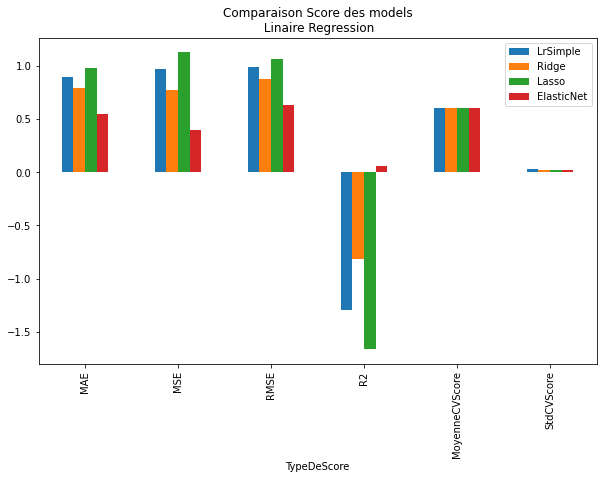

In [61]:
score_models.plot(x="TypeDeScore", y=["LrSimple", "Ridge","Lasso", "ElasticNet"], kind="bar",figsize=(10,6))
plt.title('Comparaison Score des models\n Linaire Regression')
plt.show()

##### Prédiction de margin_low manquante avec model Elastic Net

In [62]:
#Entrainement de Model de Elastic Net avec x_trainScaled, y_trainSV
lr_final = ElasticNet(alpha=0.01, l1_ratio=0.5,random_state=123).fit(x_trainScaled, y_trainSV)

#Evaluer la cross validation score de model
lr_final_bestCVScore = cross_val_score(ElasticNet(alpha=0.01, l1_ratio=0.5,random_state=123),
                             x_trainScaled,
                             y_trainSV,
                             cv=5,
                             scoring='r2')

Moyenlr_final_bestCVScore=np.mean(lr_final_bestCVScore)
stdlr_final_bestCVScore=np.std(lr_final_bestCVScore)

#Imprimer le score cross validation de train set
print('LR Final CV score Moyen',Moyenlr_final_bestCVScore)
print('LR Final Ecart type',stdlr_final_bestCVScore)

LR Final CV score Moyen 0.6046540407647156
LR Final Ecart type 0.020219406326011376


In [63]:
#Transformer les variables des données avec margin_low manquante via StandardScaler
variableAvecvaleurvide=datasetAVECvaleurvide.drop('margin_low',axis=1)
LRXtest = scaler.transform(variableAvecvaleurvide)

In [64]:

#Prédire margin_low manquante
ypred_lrFinal=lr_final.predict(LRXtest)

In [65]:
# Affichier les 37 prédictions de margin_low manquante
ypred_lrFinal

array([4.07898633, 4.12821821, 4.14902966, 4.00712737, 4.16038592,
       4.07826459, 4.08333025, 4.12622425, 4.09542657, 4.08534902,
       4.13272639, 4.16193007, 4.13925585, 4.06205496, 4.1745771 ,
       4.21218894, 4.13234012, 4.11972961, 4.1016915 , 4.10552574,
       4.09983275, 4.1652946 , 4.16400117, 4.12214129, 4.11565052,
       4.17813576, 4.11763851, 4.1205847 , 4.14043234, 5.25057858,
       5.24460625, 5.2676526 , 5.29651009, 5.19430344, 5.19920779,
       5.19461941, 5.24627454])

##### Remplir valeur vide de margin_low avec la prédiction de meilleur model regression lineaire

In [66]:
datasetAVECvaleurvide['margin_low']=ypred_lrFinal
#Vérifier résultat de remplissage
datasetAVECvaleurvide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     int64  
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    37 non-null     float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 2.3 KB


##### Concatener 2 datasets après l'ajout de la prédiction de magin_low

In [67]:
billets=pd.concat([datasetSANSvaleurvide,datasetAVECvaleurvide])
#Vérifier la dataframe finale, il n'y a plus de valeur manquante
billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


# 4 Vérifier outliers des variables
    sns outliers identifiés (dimension des données de outliers indique 0 lignes de données disponibles)

## 4.1 Sans outlier identifié dans chaque variable 'diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length'
    la dimension des dataframe qui stock les outliers pour chaque variable est 0 ligne X 7 colonnes

In [68]:
q1=[]
q3=[]
iqr=[]
seuil_Haut=[]
seuil_Bas=[]

for i in ['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']:
    Q1 = np.percentile(billets[str(i)],25) 
    Q3 = np.percentile(billets[str(i)],75)
    IQR = Q3 - Q1 
    seuilHaut = Q3+1.5*IQR
    seuilBas = Q1-1.5*IQR
    q1.append(Q1)
    q3.append(Q3)
    iqr.append(IQR)
    seuil_Haut.append(seuilHaut)
    seuil_Bas.append(seuilBas)
    print('outliers de Colonne',i,':\n',billets[(billets[str(i)]>=seuilHaut)&(billets[str(i)]<=seuilBas)].shape)  

outliers de Colonne diagonal :
 (0, 7)
outliers de Colonne height_left :
 (0, 7)
outliers de Colonne height_right :
 (0, 7)
outliers de Colonne margin_low :
 (0, 7)
outliers de Colonne margin_up :
 (0, 7)
outliers de Colonne length :
 (0, 7)


## 4.2 Affichier les critères pour identifier les outiliers

In [69]:
OutlierCritere = pd.DataFrame({
 'Q1':q1,
 'Q3':q3,
 'IQR':iqr,
 'seuilHaut':seuil_Haut,
 'seuilBas':seuil_Bas,},
 index=['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'])
OutlierCritere=OutlierCritere.reset_index().rename(columns={'index':'Variable'})
OutlierCritere

Variable        Q1      Q3     IQR  seuilHaut   seuilBas
0      diagonal  171.7500  172.17  0.4200  172.80000  171.12000
1   height_left  103.8200  104.23  0.4100  104.84500  103.20500
2  height_right  103.7100  104.15  0.4400  104.81000  103.05000
3    margin_low    4.0275    4.87  0.8425    6.13375    2.76375
4     margin_up    2.9900    3.31  0.3200    3.79000    2.51000
5        length  112.0300  113.34  1.3100  115.30500  110.06500

# 5. Interpreter les données avec ACP

## 5.1 Centrée et Réduit avec StandardScaler avant ACP

In [70]:
xACP=billets.drop('is_genuine',axis=1)

scaler=StandardScaler()
xACPscaled=scaler.fit_transform(xACP)

xACP_scaled = pd.DataFrame(xACPscaled, columns=xACP.columns)
xACP_scaled.head(2)

diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.056174  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.080881  -0.696799  0.471666

## 5.2 Entrainer ACP

In [71]:
from sklearn import decomposition
acp_initial=decomposition.PCA()
df_initial_acp=acp_initial.fit(xACPscaled)
score_initial_acp=acp_initial.transform(xACPscaled)

## 5.3 Identifier le nombre de composants pricipaux qui pourra expliquer 95% des informations.

    5 COMPOSANTS POURRONT EXPLIQUER 95% des Informations originales

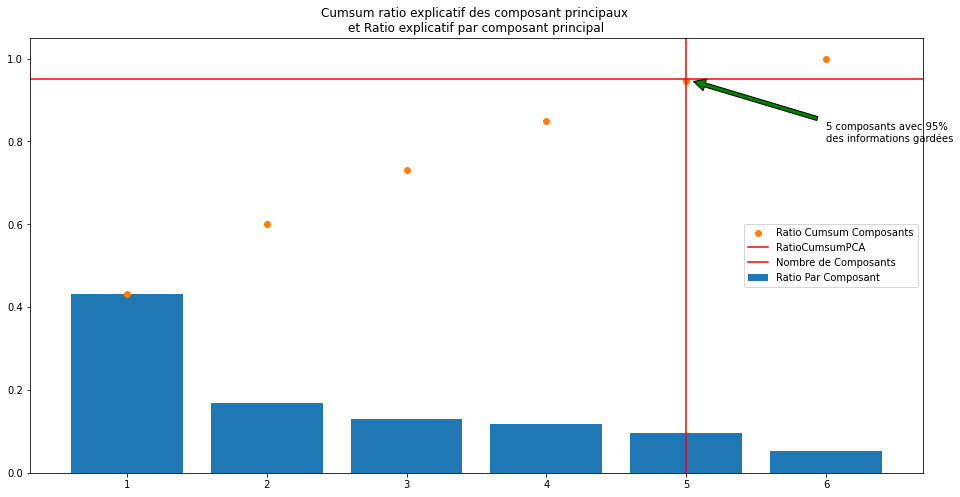

In [72]:
plt.figure(figsize=(16,8))
plt.bar(range(1,7),acp_initial.explained_variance_ratio_,
        label ='Ratio Par Composant')

plt.scatter(range(1,7),acp_initial.explained_variance_ratio_.cumsum(), 
            marker='o',label='Ratio Cumsum Composants')

plt.axhline(0.95, label ='RatioCumsumPCA', color ='r')
plt.axvline(5, label ='Nombre de Composants', color ='r')

plt.annotate('5 composants avec 95% \ndes informations gardées', xy =(5, 0.95),
                xytext =(6, 0.8), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

plt.title('Cumsum ratio explicatif des composant principaux \net Ratio explicatif par composant principal')
plt.legend()
plt.show()

## 5.4 Visualiser les relations entre les variables via CP1 et CP2 de ACP.

    Length a une corrélation négative avec CP1
    margin_low, margin_up, heigth_right, heigth_left ont une corrélation positive avec CP1
    
    
    diagonal a une corrélation positive avec CP2 et qui n'ont quasiment pas de lien avec CP1
    
    
    Comme nous avons trouvé que il y a une différence significant entre VRAIS BILLET et FAUX BILLET sur length
    et une différence également sur margin_low, margin_up, heigth_right, heigth_left,
    nous penson que CP1 sera pertinente pour distinguer le VRAIS et FAUX BILLET.

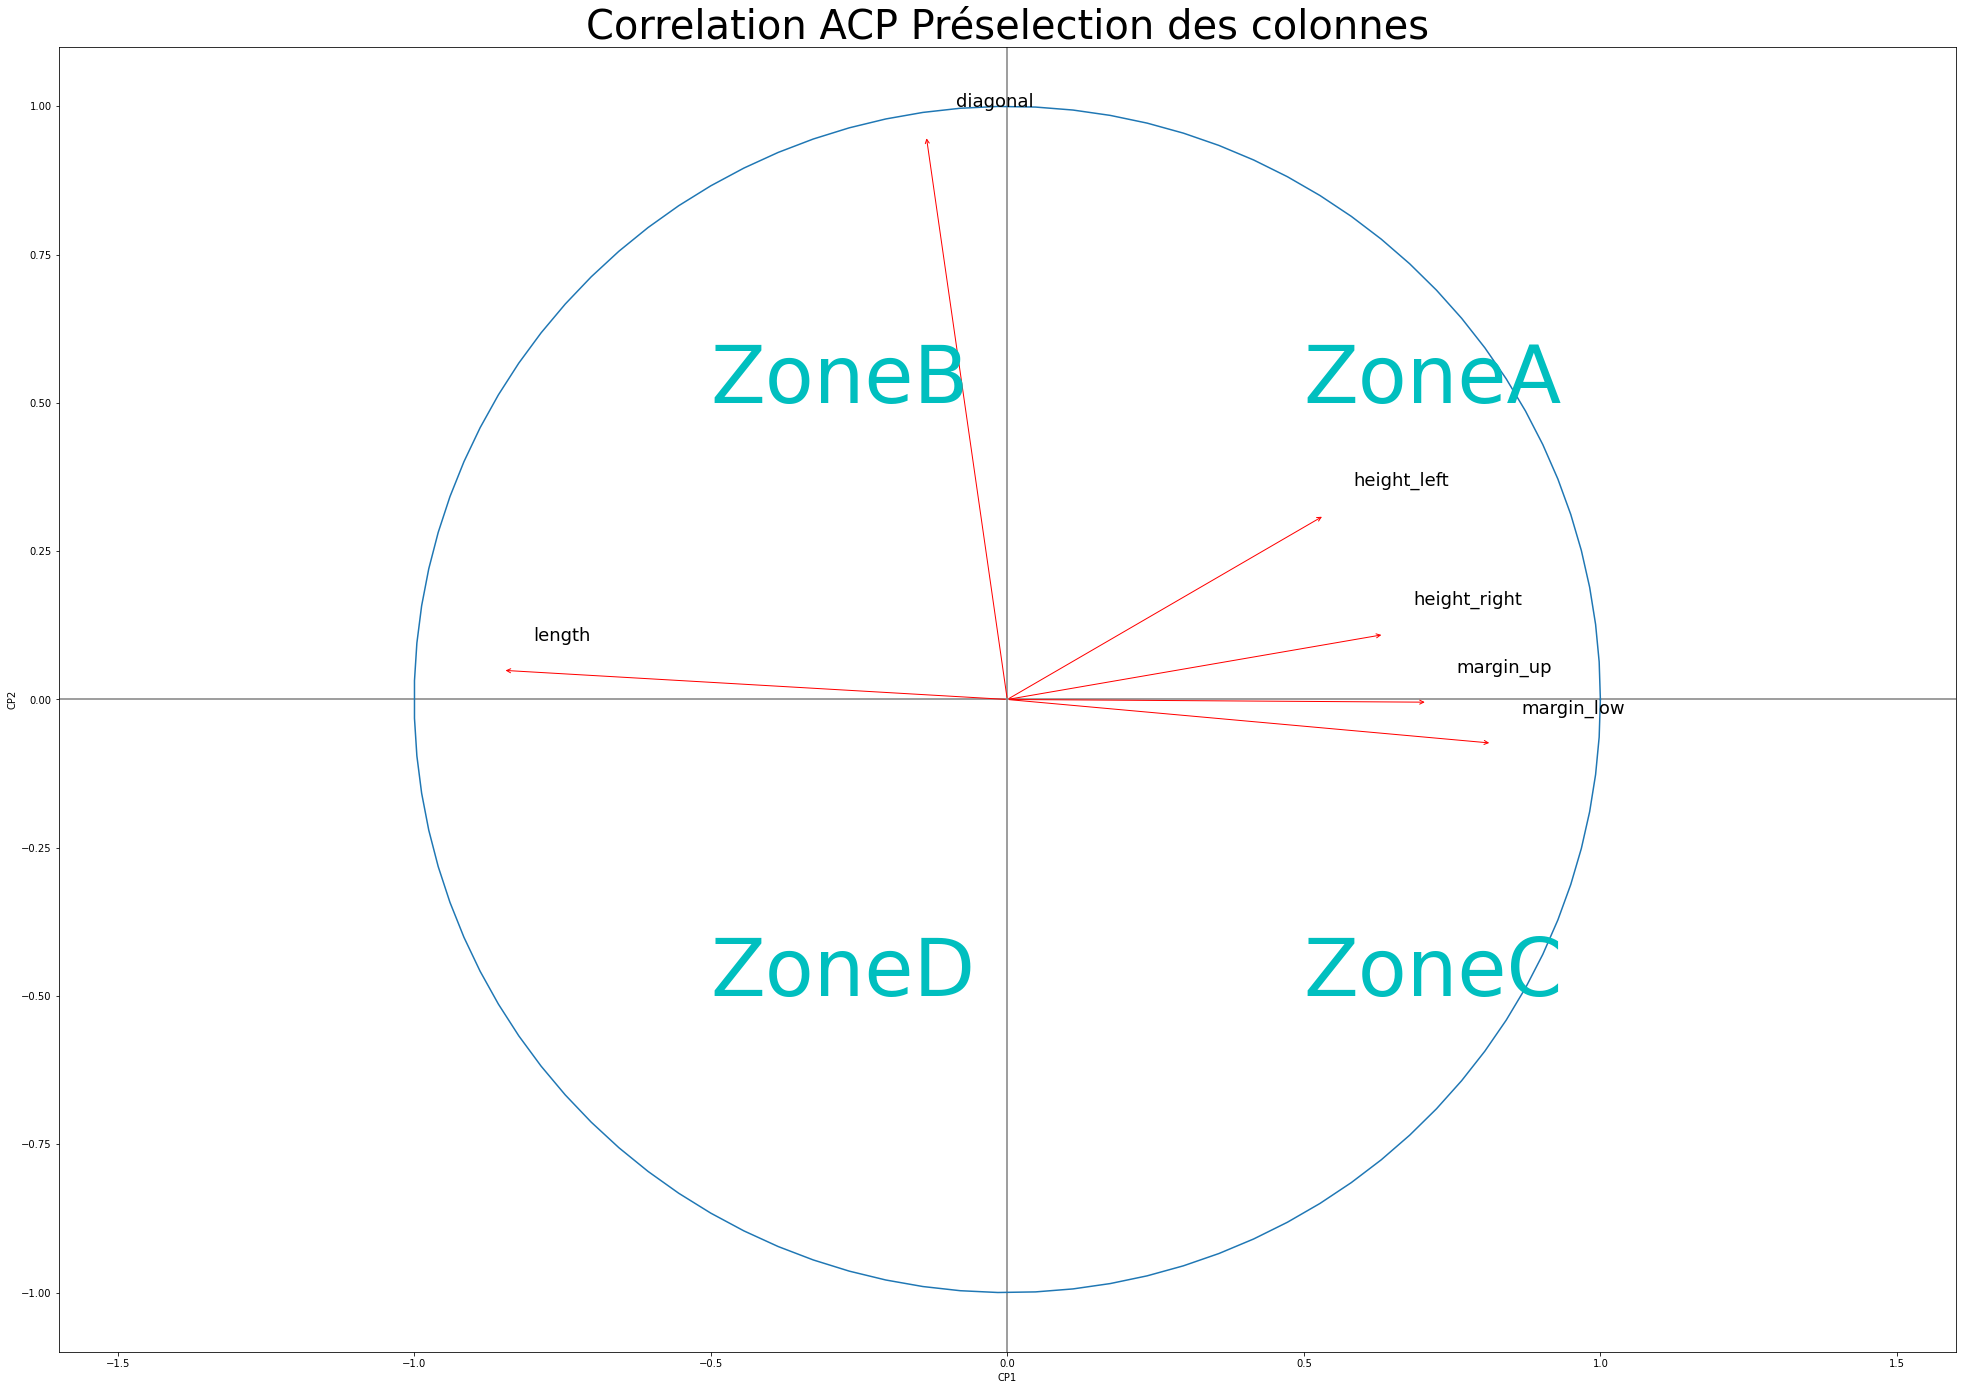

In [73]:
fig, ax = plt.subplots(figsize=(34, 24))

for i in range(xACP_scaled.shape[1]):
    x = np.corrcoef(score_initial_acp[:,0],xACP_scaled[xACP_scaled.columns[i]])[0,1]
    y = np.corrcoef(score_initial_acp[:,1],xACP_scaled[xACP_scaled.columns[i]])[0,1]
    ax.annotate("", xy= (x,y), xytext=(0, 0),arrowprops=dict(arrowstyle="->",color="r"))
    ax.annotate(xACP_scaled.columns[i], (x+0.05,y+0.05), size=18)


ax.set_title('Correlation ACP Préselection des colonnes',fontsize=40)

plt.xlabel('CP1')
plt.ylabel('CP2')

plt.annotate('ZoneA',(0.50,0.50),size=80,color='c')
plt.annotate('ZoneB',(-0.50,0.50),size=80,color='c')
plt.annotate('ZoneC',(0.50,-0.50),size=80,color='c')
plt.annotate('ZoneD',(-0.50,-0.50),size=80,color='c')

ax.axhline(y=0, color="grey", linestyle="-")
ax.axvline(x=0, color="grey", linestyle="-")

sphere = np.linspace(0, 2 * np.pi, 100)

plt.plot(np.cos(sphere), np.sin(sphere))
plt.axis('equal')
plt.show()

## 5.5 Visualiser les individus avec CP1 et CP2 en identifiant la relation entre les individus et CP1 CP2.

    VRAIS BILLET se sont situent côté gauche de CP1 
        length plus grand
        margin_low, margin_up, heigth_right, heigth_left sont plus petit
        
    FAUX BILLET se sont situent côté droite de CP1 
        length plus petit
         margin_low, margin_up, heigth_right, heigth_left sont plus grand
         
    VRAIS et FAUX billets sont centrée sur CP1, il sera difficile de les distingué avec CP2

In [74]:
def biplot(score,coef,labels=None):
 
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title('Biplot of PCA')
    cp1 = score[:,0]
    cp2 = score[:,1]
    label=billets['is_genuine']

    n = coef.shape[0]
    scalecp1 = 1.0/(cp1.max() - cp1.min())
    scalecp2 = 1.0/(cp2.max() - cp2.min())
    
    
    
    sns.scatterplot(cp1 * scalecp1,
                cp2 * scalecp2,
                s=100, 
                hue=label)
    plt.axhline(y=0, color="grey", linestyle="-")
    plt.axvline(x=0, color="grey", linestyle="-")
    plt.annotate('ZoneA',(0.50,0.40),size=20,color='c')
    plt.annotate('ZoneB',(-0.20,0.40),size=20,color='c')
    plt.annotate('ZoneC',(0.50,-0.40),size=20,color='c')
    plt.annotate('ZoneD',(-0.20,-0.40),size=20,color='c')
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  width = 0.001,
                  alpha = 0.5)
        plt.text(coef[i,0]*1, 
                 coef[i,1]*1, 
                 labels[i], 
                 color = 'r', 
                 ha = 'center', 
                 va = 'center',
                fontsize=20)
 
    plt.xlabel("CP{}".format(1))
    plt.ylabel("CP{}".format(2))    

 
    plt.show()

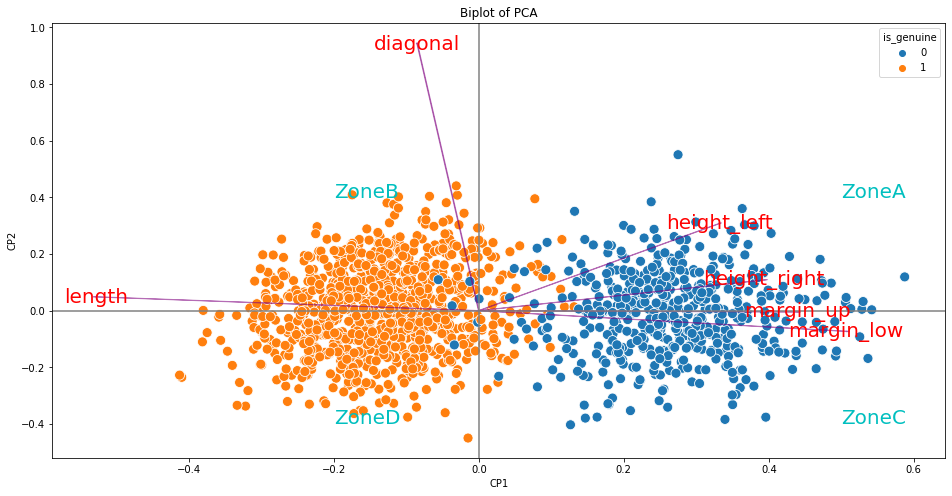

In [75]:
biplot(score_initial_acp, 
       np.transpose(acp_initial.components_), 
       list(xACP_scaled.columns))

# 6. Identifier FAUX BILLET avec Algorithme Kmeans
    
    Nous essaions 2 approches:
        1. Kmeans avec les données avec la réduction de dimension par ACP
        2. Kmeans sur les données sans réduction de dimension via ACP
        
    Nous trouvons que les 2 approches retournent le même niveau de qualité de prédiction, mais les centroïdes ne sont pas la même

## 6.1 Approche 1  Kmeans avec les données dont sa dimension réduit par ACP

### 6.1.1 Entrainner ACP avec 5 CPs

In [76]:
model_acp5=decomposition.PCA(n_components=5)
df_acp5=model_acp5.fit(xACPscaled)
score_acp5=model_acp5.transform(xACPscaled)

In [77]:
score_acp5.shape

(1500, 5)

### 6.1.2 Attacher 5 composants principaux à l'index de chaque billet

In [78]:
df_acp = pd.DataFrame(data = score_acp5,index=xACP_scaled.index,
                    columns = ['PC 1', 'PC 2','PC 3', 'PC 4','PC 5'])
 
df_acp.head(2)

PC 1      PC 2      PC 3      PC 4      PC 5
0  1.647271  0.746490  2.393757  3.186039  0.305261
1 -2.019937 -2.206676 -1.002712  0.071047  0.036654

### 6.1.3 Vérifier le poids de chaque variable dans chaque ACP

In [79]:
model_acp5.components_
acpcomposant = model_acp5.components_
NombreComposant = model_acp5.n_features_
ListeComposant = ["PC"+str(i) for i in list(range(1, NombreComposant+1))]
ComposantVariable = pd.DataFrame.from_dict(dict(zip(ListeComposant, acpcomposant)))
ComposantVariable['Variable'] = xACP_scaled.columns.values
ComposantVariable = ComposantVariable.set_index('Variable')
ComposantVariable

PC1       PC2       PC3       PC4       PC5
Variable                                                      
diagonal     -0.084810  0.941383 -0.286819 -0.102673 -0.117207
height_left   0.331317  0.307136  0.884808 -0.047240  0.103662
height_right  0.393791  0.108436 -0.166321  0.866360  0.234333
margin_low    0.506731 -0.072897 -0.106576 -0.090208 -0.570448
margin_up     0.439261 -0.004522 -0.270979 -0.443946  0.709898
length       -0.527482  0.048715  0.149664  0.177260  0.302058

### 6.1.4 Visualiser le poids de chaque variable dans chaque composant principal

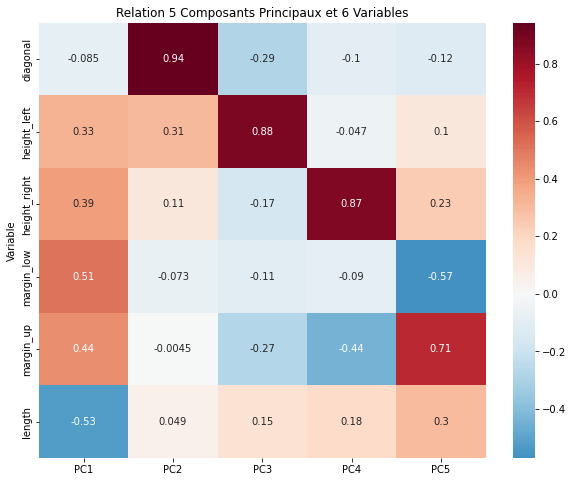

In [80]:
plt.figure(figsize=(10,8))
sns.heatmap(ComposantVariable,annot=True,center = 0, cmap = 'RdBu_r')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title('Relation 5 Composants Principaux et 6 Variables')
plt.show()

### 6.1.5 Appliquer Kmeans avec 2 clusters sur données ACP de 5 CPs

    Il existe 2 catégories de billet VRAIS ou FAUX, donc on applique directement le cluster 2 pour KMEANS sans passé par l'évaluation de Elbow ou Silhouette

#### 6.1.5.1 Entrainer Kmeans + ACP avec 2 cluster

In [81]:
from sklearn.cluster import KMeans
#Entrainer Kmeans avec 2 clusters et les données réduits (5 CPs) par ACP
kmeans_ACP=KMeans(n_clusters=2, init ='k-means++',random_state=123)
kmeans_ACP.fit(score_acp5)

KMeans(n_clusters=2, random_state=123)

#### 6.1.5.2Affichier les controïdes de ACP

In [82]:
kmeans_ACP.cluster_centers_

array([[ 2.06718277, -0.07436365, -0.09123053, -0.0865438 , -0.13920458],
       [-1.0212377 ,  0.03673742,  0.04507006,  0.0427547 ,  0.06877039]])

#### 6.1.5.3 Attacher CP1  CP2 et Etiquette Kmeans sur la dataframe

In [83]:
billets['Composant1']=score_acp5[:,0]
billets['Composant2']=score_acp5[:,1]
billets['pcaKmeansCluster']=kmeans_ACP.labels_
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.46       103.36        103.66        3.77       2.99   
2           1    172.69       104.48        103.50        4.40       2.94   
3           1    171.36       103.91        103.94        3.62       3.01   
4           1    171.73       104.28        103.46        4.04       3.48   

   length  Composant1  Composant2  pcaKmeansCluster  
0  112.83    1.647271    0.746490                 0  
1  113.09   -2.019937   -2.206676                 1  
2  113.16   -0.968963    2.619602                 1  
3  113.51   -1.375964   -1.818037                 1  
4  112.54    0.150033   -0.566421                 1

In [84]:
billetsKA=billets.copy()
billetsKA.loc[billetsKA["is_genuine"] == 1, "is_genuine"] = 'VRAIS BILLET'
billetsKA.loc[billetsKA["is_genuine"] == 0, "is_genuine"] = 'FAUX BILLET'

billetsKA.loc[billetsKA["pcaKmeansCluster"] == 1, "pcaKmeansCluster"] = 'PRED VRAIS BILLET'
billetsKA.loc[billetsKA["pcaKmeansCluster"] == 0, "pcaKmeansCluster"] = 'PRED FAUX BILLET'

print('pcaKmeansCluster valeur:',billetsKA.pcaKmeansCluster.unique())
print('is_genuine valeur:',billetsKA.is_genuine.unique())

pcaKmeansCluster valeur: ['PRED FAUX BILLET' 'PRED VRAIS BILLET']
is_genuine valeur: ['VRAIS BILLET' 'FAUX BILLET']


#### 6.1.5.4 Affichier les caractères de chaque cluster de prédiction par la moyen de chaque variable

In [85]:
caracterekmeanAvecACP=billetsKA.groupby('pcaKmeansCluster')['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length'].mean()
display(caracterekmeanAvecACP)

diagonal  height_left  height_right  margin_low  \
pcaKmeansCluster                                                       
PRED FAUX BILLET   171.899153   104.200383    104.152520    5.221884   
PRED VRAIS BILLET  171.987729   103.945129    103.805588    4.117896   

                   margin_up      length  
pcaKmeansCluster                          
PRED FAUX BILLET    3.351734  111.630847  
PRED VRAIS BILLET   3.052540  113.196066

#### 6.1.5.5 Nombre de faux billet et true billet prédit par Kmeans

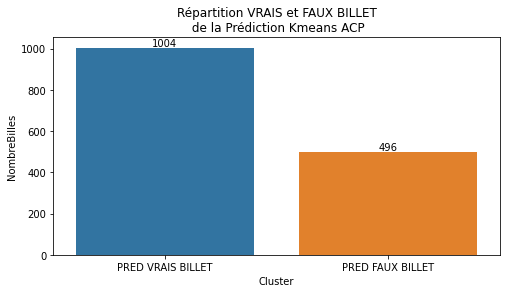

In [86]:
predictionKmeans=billetsKA['pcaKmeansCluster'].value_counts().reset_index().rename(columns={'index':'Cluster','pcaKmeansCluster':'NombreBilles'})


fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(x='Cluster',y='NombreBilles',data=predictionKmeans)
ax.bar_label(ax.containers[0])
plt.title('Répartition VRAIS et FAUX BILLET\n de la Prédiction Kmeans ACP')

plt.show()

#### 6.1.5.6 Matrice de confusion et performance Kmeans +ACP

In [87]:
#Groupby selon étiquette kmeans et étiquette origine
resultKmeans=pd.DataFrame(billets.groupby(['pcaKmeansCluster','is_genuine',]
                            ).size()).reset_index().rename(columns={0:'NombreBillets'})
#Renommer l'étiquette Kmeans
resultKmeans=resultKmeans.pivot(index='is_genuine', 
                   columns='pcaKmeansCluster', 
                   values='NombreBillets').reset_index().rename(columns={0:'Pred_FAUXbillet',1:'Pred_VRAISbillet'})

#renomer l'étiquette originale
resultKmeans['is_genuine'] = resultKmeans['is_genuine'].replace([0, 1], ['FAUXbillet', 'VRAISbillet'])
resultKmeans


pcaKmeansCluster   is_genuine  Pred_FAUXbillet  Pred_VRAISbillet
0                  FAUXbillet              486                14
1                 VRAISbillet               10               990

##### Matrice de Confusion Kmeans + ACP de 5 CPs

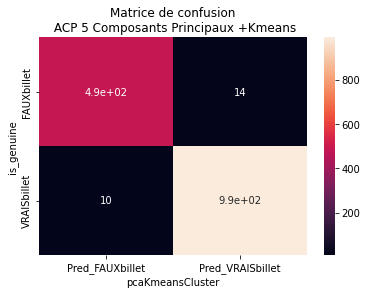

In [88]:
resultKmeans=resultKmeans.set_index('is_genuine')

sns.heatmap(resultKmeans,annot=True)
plt.title('Matrice de confusion\n ACP 5 Composants Principaux +Kmeans')
plt.show()

##### Evaluation de model Kmeans + ACP de 5 CPs

In [89]:
print(classification_report(billets['is_genuine'],billets['pcaKmeansCluster']))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       500
           1       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



##### Performance Kmeans détail:
    
    FAUX BILLET Recall Score 0.972 est le score que nous devons améliorer pour maximiser l'identification de faux billet
    
        Precision Score de Kmeans 0.9829472432849249
        Recall Score de Kmeans 0.981
        F1 Score de Kmeans 0.9819637832768198
        Accuracy Score de Kmeans 0.984
        Kmeans VRAIS BILLET Précision Score 0.9860557768924303
        Kmeans VRAIS BILLET Recall Score 0.99
        Kmeans FAUX BILLET Précision Score 0.9798387096774194
        
        Kmeans FAUX BILLET Recall Score 0.972


In [90]:
KmeansReport=classification_report(billets['is_genuine'],billets['pcaKmeansCluster'],output_dict=True)

Kmeans_precision =  KmeansReport['macro avg']['precision'] 
print('Precision Score de Kmeans',Kmeans_precision)

Kmeans_recall = KmeansReport['macro avg']['recall']    
print('Recall Score de Kmeans',Kmeans_recall)

Kmeans_f1 = KmeansReport['macro avg']['f1-score']
print('F1 Score de Kmeans',Kmeans_f1)

Kmeans_accuracy = KmeansReport['accuracy']
print('Accuracy Score de Kmeans',Kmeans_accuracy)


KmeansVRAISBILLET_precision=KmeansReport['1']['precision']
print('Kmeans VRAIS BILLET Précision Score',KmeansVRAISBILLET_precision)

KmeansVRAISBILLET_recall=KmeansReport['1']['recall']
print('Kmeans VRAIS BILLET Recall Score',KmeansVRAISBILLET_recall)

KmeansFAUXBILLET_precision=KmeansReport['0']['precision']
print('Kmeans FAUX BILLET Précision Score',KmeansFAUXBILLET_precision)

KmeansFAUXBILLET_recall=KmeansReport['0']['recall']
print('Kmeans FAUX BILLET Recall Score',KmeansFAUXBILLET_recall)

Precision Score de Kmeans 0.9829472432849249
Recall Score de Kmeans 0.981
F1 Score de Kmeans 0.9819637832768198
Accuracy Score de Kmeans 0.984
Kmeans VRAIS BILLET Précision Score 0.9860557768924303
Kmeans VRAIS BILLET Recall Score 0.99
Kmeans FAUX BILLET Précision Score 0.9798387096774194
Kmeans FAUX BILLET Recall Score 0.972


#### 6.1.5.7 Visualiser les individus avec CP1  CP2 et Etiquette Kmeans

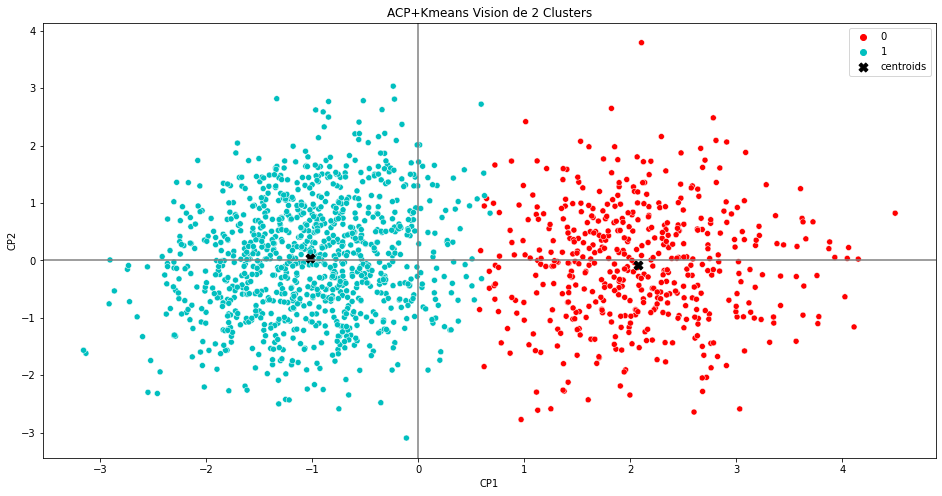

In [91]:
yax=billets['Composant1']
xax=billets['Composant2']

plt.figure(figsize=(16,8))

#Affichier les individues avec CP1 et CP2
sns.scatterplot(x=billets['Composant1'],
                y=billets['Composant2'],
                hue=billets['pcaKmeansCluster'],
               palette=['r','c'])

#Ajouter les centroïdes dans graphique
plt.scatter(kmeans_ACP.cluster_centers_[:,0], kmeans_ACP.cluster_centers_[:,1], 
            marker="X", c="k", s=80, label="centroids")

plt.axhline(y=0, color="grey", linestyle="-")
plt.axvline(x=0, color="grey", linestyle="-")
plt.annotate('ZoneA',(10,10),size=20,color='c')
plt.annotate('ZoneB',(-2.5,10),size=20,color='c')
plt.annotate('ZoneC',(10,-5),size=20,color='c')
plt.annotate('ZoneD',(-2.5,-7.5),size=20,color='c')



plt.legend()



plt.xlabel('CP1')
plt.ylabel('CP2')
plt.title('ACP+Kmeans Vision de 2 Clusters')
plt.show()

## 6.2 Approche 2 Kmeans SANS ACP

### 6.2.1 Reformumer dataset des variables

In [92]:
#Sélectionner les variables
x_kmeansimple=billets[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]
x_kmeansimple.head(1)

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83

### 6.2.2 Normaliser les données variables avec StandardScaler

In [93]:
#Normaliser les variables
scaler=StandardScaler()
xAll_scaled=scaler.fit_transform(x_kmeansimple)

### 6.2.3 Entrainner Kmeans sans ACP

In [94]:
#Entrainner Kmeans avec 2 clusters et fixer les échantillons avec random_state 123
kmeans_Simple=KMeans(n_clusters=2, init ='k-means++',random_state=123)
kmeans_Simple.fit(xAll_scaled)
billets['KmeansCluster']=kmeans_Simple.labels_

### 6.2.4 Affichier les centroïdes de 2 clusters

In [95]:
#Affichier les contraïdes de 2 clusters Kmeans
kmeans_Simple.cluster_centers_

array([[-0.19432338,  0.57071311,  0.71336493,  1.12028047,  0.86417597,
        -1.20083284],
       [ 0.09600039, -0.28194592, -0.35241933, -0.55344533, -0.42692359,
         0.59324013]])

### 6.2.5 Vérifier les caractères de 2 clusters avec les valeurs moyennes des variables

In [96]:
#Vérifier les caractères de kmeans sans ACP avec les valeurs moyennes des variables
caracterekmeanSansACP=billets.groupby('KmeansCluster')['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length'].mean()
caracterekmeanSansACP=caracterekmeanSansACP.reset_index()
#Renommer l'étiquette KmeansCluster
caracterekmeanSansACP.loc[caracterekmeanSansACP["KmeansCluster"] == 0, "KmeansCluster"] = 'PRED FAUX BILLET'
caracterekmeanSansACP.loc[caracterekmeanSansACP["KmeansCluster"] == 1, "KmeansCluster"] = 'PRED VRAIS BILLET'
display(caracterekmeanSansACP)

KmeansCluster    diagonal  height_left  height_right  margin_low  \
0   PRED FAUX BILLET  171.899153   104.200383    104.152520    5.221884   
1  PRED VRAIS BILLET  171.987729   103.945129    103.805588    4.117896   

   margin_up      length  
0   3.351734  111.630847  
1   3.052540  113.196066

### 6.2.6 Matrice de confusion Kmeans sans ACP

In [97]:
#Groupby 'KmeansCluster','is_genuine' 
KmeanSimple=pd.DataFrame(billets.groupby(['KmeansCluster','is_genuine']
                            ).size()).reset_index().rename(columns={0:'NombreBillets'})

#Tableau de matrice et renommer étiquette Kmeans sans ACP
KmeanSimple=KmeanSimple.pivot(index='is_genuine', 
                   columns='KmeansCluster', 
                   values='NombreBillets').reset_index().rename(columns=
                                                                {0:'PRED FAUX Billet',1:'PRED VRAIS Billet'})

#renommer étiquette Originale
KmeanSimple['is_genuine'] = KmeanSimple['is_genuine'].replace([0, 1], 
                                                                            ['FAUX billet', 'VRAIS billet'])

KmeanSimple

KmeansCluster    is_genuine  PRED FAUX Billet  PRED VRAIS Billet
0               FAUX billet               486                 14
1              VRAIS billet                10                990

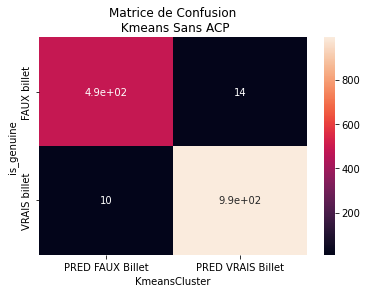

In [98]:
KmeanSimple=KmeanSimple.set_index('is_genuine')
sns.heatmap(KmeanSimple,annot=True)
plt.title('Matrice de Confusion\n Kmeans Sans ACP')
plt.show()

### 6.2.7 Performance de Kmeans sans ACP

In [99]:
#Affichier tous les socres de Kmeans ACP
print(classification_report(billets['is_genuine'],billets['KmeansCluster']))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       500
           1       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [100]:
#Extraction des scores Kmeans sans ACP pour la comparaison des models

Kmeans2Report=classification_report(billets['is_genuine'],billets['pcaKmeansCluster'],output_dict=True)

Kmeans2_precision =  Kmeans2Report['macro avg']['precision'] 
print('Precision Score de Kmeans SANS ACP',Kmeans2_precision)

Kmeans2_recall = Kmeans2Report['macro avg']['recall']    
print('Recall Score de Kmeans SANS ACP',Kmeans2_recall)

Kmeans2_f1 = Kmeans2Report['macro avg']['f1-score']
print('F1 Score de Kmeans SANS ACP',Kmeans2_f1)

Kmeans2_accuracy = Kmeans2Report['accuracy']
print('Accuracy Score de Kmeans SANS ACP',Kmeans2_accuracy)


Kmeans2VRAISBILLET_precision=Kmeans2Report['1']['precision']
print('Kmeans SANS ACP VRAIS BILLET Précision Score',Kmeans2VRAISBILLET_precision)

Kmeans2VRAISBILLET_recall=Kmeans2Report['1']['recall']
print('Kmeans SANS ACP VRAIS BILLET Recall Score',Kmeans2VRAISBILLET_recall)

Kmeans2FAUXBILLET_precision=Kmeans2Report['0']['precision']
print('Kmeans SANS ACP FAUX BILLET Précision Score',Kmeans2FAUXBILLET_precision)

Kmeans2FAUXBILLET_recall=Kmeans2Report['0']['recall']
print('Kmeans SANS ACP FAUX BILLET Recall Score',Kmeans2FAUXBILLET_recall)

Precision Score de Kmeans SANS ACP 0.9829472432849249
Recall Score de Kmeans SANS ACP 0.981
F1 Score de Kmeans SANS ACP 0.9819637832768198
Accuracy Score de Kmeans SANS ACP 0.984
Kmeans SANS ACP VRAIS BILLET Précision Score 0.9860557768924303
Kmeans SANS ACP VRAIS BILLET Recall Score 0.99
Kmeans SANS ACP FAUX BILLET Précision Score 0.9798387096774194
Kmeans SANS ACP FAUX BILLET Recall Score 0.972


### 6.2.8 Projecter le résultat Kmeans en 2D avec ACP

#### Entrainner ACP avec 2 clusters

In [101]:
model_acpproje=decomposition.PCA(n_components=2)
df_acpproje=model_acpproje.fit(xAll_scaled)
score_acpproje=model_acpproje.transform(xAll_scaled)

#### Ajouter CP1 et CP2 dans les données initiales

In [102]:
billets['ACPproj1']=score_acpproje[:,0]
billets['ACPproj2']=score_acpproje[:,1]

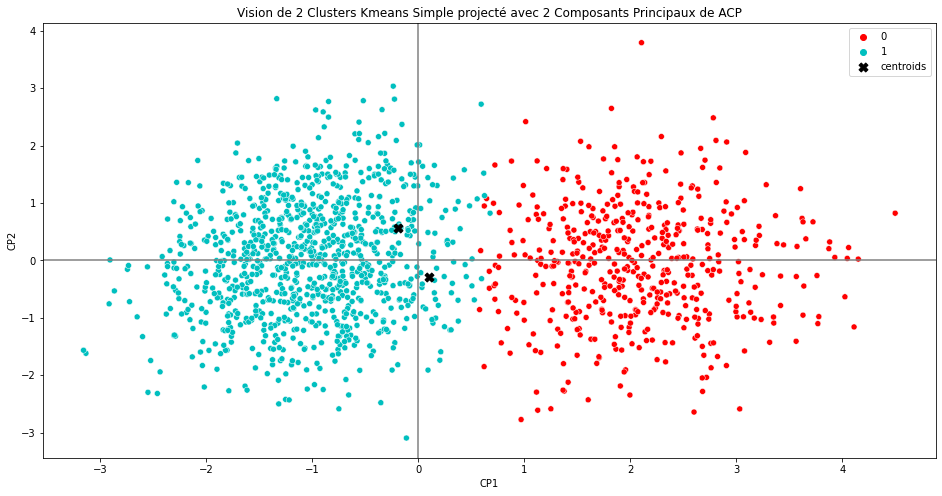

In [103]:

yax=billets['ACPproj1']
xax=billets['ACPproj2']

plt.figure(figsize=(16,8))

#Affichier les individues avec CP1 ET CP2
sns.scatterplot(x=billets['ACPproj1'],
                y=billets['ACPproj2'],
                hue=billets['KmeansCluster'],
               palette=['r','c'])

#Ajouter 2 centroïdes à graphique
plt.scatter(kmeans_Simple.cluster_centers_[:,0], kmeans_Simple.cluster_centers_[:,1], 
            marker="X", c="k", s=80, label="centroids")

plt.axhline(y=0, color="grey", linestyle="-")
plt.axvline(x=0, color="grey", linestyle="-")
plt.annotate('ZoneA',(10,10),size=20,color='c')
plt.annotate('ZoneB',(-2.5,10),size=20,color='c')
plt.annotate('ZoneC',(10,-5),size=20,color='c')
plt.annotate('ZoneD',(-2.5,-7.5),size=20,color='c')



plt.legend()



plt.xlabel('CP1')
plt.ylabel('CP2')
plt.title('Vision de 2 Clusters Kmeans Simple projecté avec 2 Composants Principaux de ACP')
plt.show()

###  6.2.9  Comparaison Kmeans sans ACP et avec ACP

#### Avec les données disponibles les 2 méthodes kmeans retourne la même prédiction

In [104]:
Comp2Kmeans=pd.DataFrame(billets.groupby(['pcaKmeansCluster','KmeansCluster']
                            ).size()).reset_index().rename(columns={0:'NombreBillets'})

Comp2Kmeans

pcaKmeansCluster  KmeansCluster  NombreBillets
0                 0              0            496
1                 1              1           1004

#### Comparaison de 2 centroïdes de 2 méthodes Kmeans: les centroïdes de 2 méthodes ne sont pas la même

    Il y a un risque de l'écarte de prédiction entre les 2 méthodes avec l'augmentation des données

In [105]:
pd.DataFrame({'KmeansSansACP Centroïde Cluster 0':kmeans_Simple.cluster_centers_[:,0],
             'KmeansACP Centroïde Cluster 0':kmeans_ACP.cluster_centers_[:,0],
             'KmeansSansACP Centroïde Cluster 1':kmeans_Simple.cluster_centers_[:,1],
             'KmeansACP Centroïde Cluster 1':kmeans_ACP.cluster_centers_[:,1]})


KmeansSansACP Centroïde Cluster 0  KmeansACP Centroïde Cluster 0  \
0                          -0.194323                       2.067183   
1                           0.096000                      -1.021238   

   KmeansSansACP Centroïde Cluster 1  KmeansACP Centroïde Cluster 1  
0                           0.570713                      -0.074364  
1                          -0.281946                       0.036737

# 7. Logistique Regression

    Nous applique logistique régression en 2 manières:
    
        1. Appliquer Logistique Régression avec X_train Normalisé 
            -avec une model de base, 
            -puis évaluer le model avec cross validation
            -Utiliser GridesearchCV pour identifier la meilleure model
            -Appliquer la meilleure model et comparer avec le model de base

        2. Appliquer Logistique Régression avec X_train NON NNormalisé 
            -avec une model de base, 
            -puis évaluer le model avec cross validation
            -Utiliser GridesearchCV pour identifier la meilleure model
            -Appliquer la meilleure model et comparer avec le model de base
            
      
      Nous trouvons que:
          Le model de base est plus performant quand nous utilisons les données non normalisé.
          Mais GridsearchCV a pu optimiser les 2 approches avec les hyperparamétres et enfin réalisé le même niveau de qualité de prédiction dans les 2 cas.
      
         

## 7.1 Préparation des données

### 7.1.1 Encoder is_genuine avant regression logistique

In [106]:
encoder=LabelEncoder()
encoder.fit(billets['is_genuine'])
encoder.transform(billets['is_genuine'])

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

### 7.1.2 Séparer les variables et le traget (is_genuine)

In [107]:
y=billets['is_genuine']
x=billets[['diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length']]

In [108]:
print('dimension des variables:',x.shape)
print('dimension de target:',y.shape)

dimension des variables: (1500, 6)
dimension de target: (1500,)


### 7.1.3 Visualiser les individues par variables

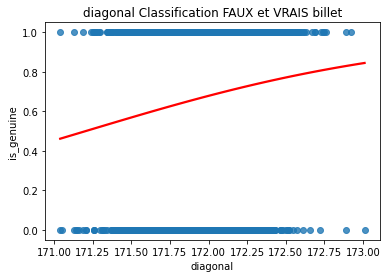

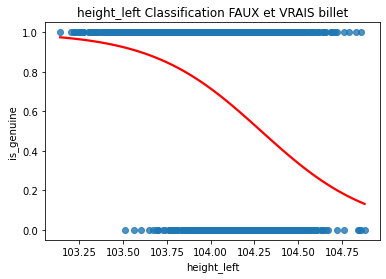

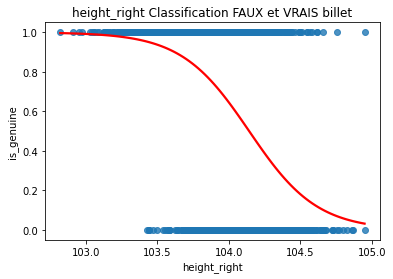

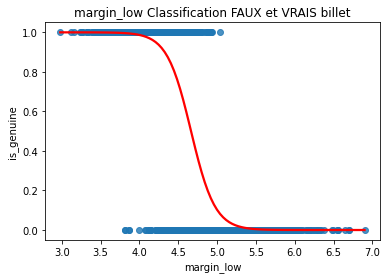

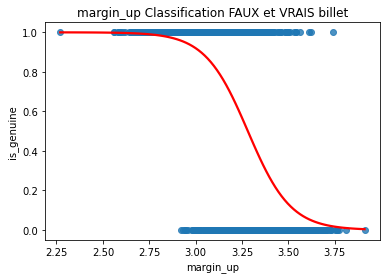

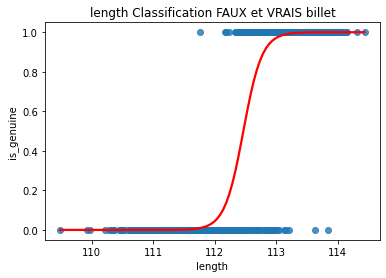

In [109]:
for i in ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']:
    sns.regplot(x[i],y=billets['is_genuine'],logistic= True,line_kws={'color': 'red'},ci=None)
    plt.title(i+' Classification FAUX et VRAIS billet')
    plt.show()

### 7.1.4 Séparer dataset en train et test set avant regression logistique avec la répartition de 70% et 30%

In [110]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=123)

#Vérifier la dimension de 4 datasets (x_train,y_train,x_test,y_test) après la séparation
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1050, 6)
(1050,)
(450, 6)
(450,)


## 7.2 Sélectionner la meilleure paramétre logistique regression avec les données normalisées

### 7.2.1 Normaliser les données x_train et x_test via StandardScaler

In [111]:
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

### 7.2.2 Regression Logistique de Base avec données normalisées
    Comme il y a une unéquilibre entre FAUX Billets (33%) et VRAIS billets (66%),
    nous définission FAUX billet 0.33 et VRAIS billet 0.66 avec la paramétre de logistique regression :
    class_weight={0:0.33,1:0.66}

#### Trainset Accuracy Score est 0.9895238095238095

In [112]:
#Importer model logistique régression, fixer les échantillons avec random_state 123, 
#et class_weight 0.33,0.66 selon la répartition de FAUX et VRAIS billets
logisticRegBasic=LogisticRegression(class_weight={0:0.33,1:0.66},random_state=123)
logisticRegBasic.fit(x_train_scaled,y_train)
#Calculer accuracy Score
logRegBasicscore_train=logisticRegBasic.score(x_train_scaled,y_train)
print('logistique Regression Basic score_train:',logRegBasicscore_train)

logistique Regression Basic score_train: 0.9895238095238095


#### Coéfficients des Variables et l'Intercept de Model Basic de Regression Logistique

In [113]:
feature_names=x.columns
LogRegBasicCoefIntercept=pd.DataFrame(list(zip(feature_names,logisticRegBasic.coef_[0])),
                                      columns=['Variable','Coéfficient Logistique Regression'])
new_row = {'Variable':'intercept', 
           'Coéfficient Logistique Regression':logisticRegBasic.intercept_[0]}

LogRegBasicCoefIntercept = LogRegBasicCoefIntercept.append(new_row, ignore_index=True)
LogRegBasicCoefIntercept

Variable  Coéfficient Logistique Regression
0      diagonal                           0.107526
1   height_left                          -0.379210
2  height_right                          -0.603010
3    margin_low                          -2.302771
4     margin_up                          -1.367149
5        length                           2.897571
6     intercept                           2.200926

#### Visualiser les coéfficients et l'intercept de model basique avec barplot

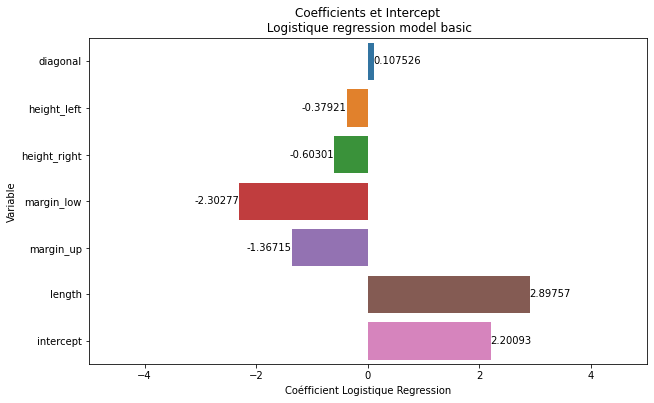

In [114]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='Variable',x='Coéfficient Logistique Regression',data=LogRegBasicCoefIntercept,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-5,5)

plt.title('Coefficients et Intercept\n Logistique regression model basic')
plt.show()

#### Trainset Accuracy Score est 0.9888888888888889

In [115]:
y_BasicPredict=logisticRegBasic.predict(x_test_scaled)
logRegBasicscore_test=logisticRegBasic.score(x_test_scaled,y_test)
print('logRegBasic score_test:',logRegBasicscore_test)

logRegBasic score_test: 0.9888888888888889


#### Visualiser la comparaison de prédiction et réalité de test set

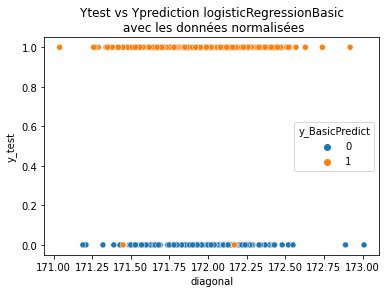

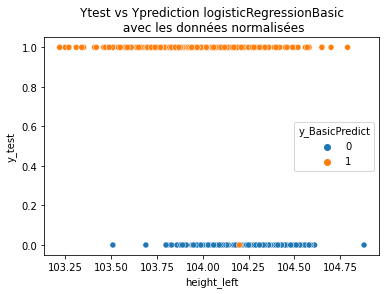

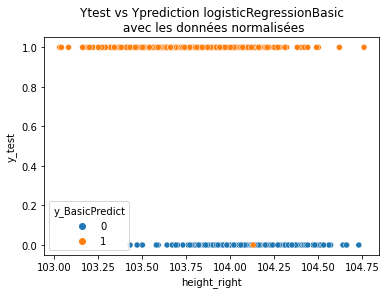

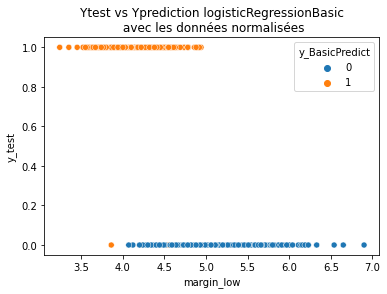

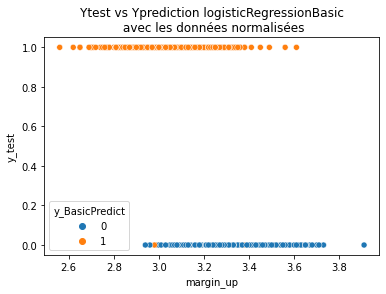

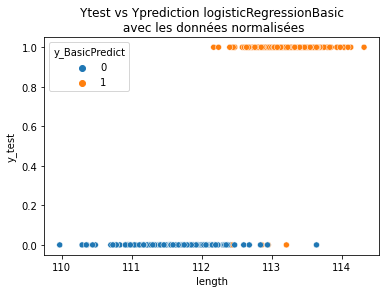

In [116]:
#Mettre les variables, étiquette de prédiction, étiquette de traget réelle dans une dataframe 
dflogisticRegBasic=x_test[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]
dflogisticRegBasic['y_BasicPredict']=y_BasicPredict
dflogisticRegBasic['y_test']=y_test

#Visualiser la comparaison de étiquette réelle et l'étiquette de prédiction 
#de test set de prédiction par chaque variable
for i in ['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']:
    sns.scatterplot(x = i, y = 'y_test', hue = 'y_BasicPredict', data = dflogisticRegBasic)
    plt.title('Ytest vs Yprediction logisticRegressionBasic\n avec les données normalisées')
    plt.show()

#### Dans le TestSet, 4 FAUX Billets sont prédit en VRAIS Billets soit 2.7% d'erreur de prédiction dans les faux billets, 0 VRAIS Billets sont prédit en FAUX Billet
    L'objectif de projet est de préfèrer d'améliorer le score rappel(recall) pour éviter mal prédiction de FAUX billet,
    nous devons utiliser les paramétrers pour augmenter le score de rappel(recall) pour l'améliorer la performance de l'algorithme.

#### Matrice de Confusion Model basique

In [117]:
LogRegBasic_matrice_confusion=metrics.confusion_matrix(y_test,y_BasicPredict)
print(LogRegBasic_matrice_confusion)

[[141   5]
 [  0 304]]


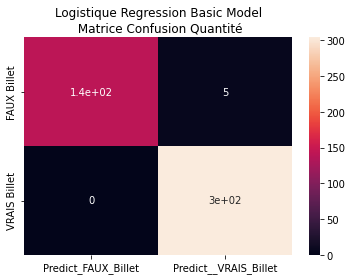

In [118]:
sns.heatmap(LogRegBasic_matrice_confusion,
            xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Basic Model\n Matrice Confusion Quantité')
plt.show()

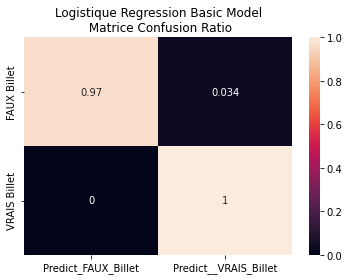

In [119]:
LogRegBasic_MatriceRatio=LogRegBasic_matrice_confusion/LogRegBasic_matrice_confusion.sum(axis=1).reshape(-1,1)
sns.heatmap(LogRegBasic_MatriceRatio,xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Basic Model\n Matrice Confusion Ratio')
plt.show()

#### Evaluation de Model basique

In [120]:
print(classification_report(y_test,y_BasicPredict))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       146
           1       0.98      1.00      0.99       304

    accuracy                           0.99       450
   macro avg       0.99      0.98      0.99       450
weighted avg       0.99      0.99      0.99       450



In [121]:
#Extraction les scores de tableau classification report

LogRegBasicReport=classification_report(y_test,y_BasicPredict,output_dict=True)

LogRegBasic_precision =  LogRegBasicReport['macro avg']['precision'] 
print('Precision Score de Basic Model',LogRegBasic_precision)

LogRegBasic_recall = LogRegBasicReport['macro avg']['recall']    
print('Recall Score de Basic Model',LogRegBasic_recall)

LogRegBasic_f1 = LogRegBasicReport['macro avg']['f1-score']
print('F1 Score de Basic Model',LogRegBasic_f1)

LogRegBasic_accuracy = LogRegBasicReport['accuracy']
print('Accuracy Score de Basic Model',LogRegBasic_accuracy)

Precision Score de Basic Model 0.9919093851132685
Recall Score de Basic Model 0.9828767123287672
F1 Score de Basic Model 0.9872108951804969
Accuracy Score de Basic Model 0.9888888888888889


In [122]:
LogRegBasicVRAISBILLET_precision=LogRegBasicReport['1']['precision']

print('VRAIS BILLET Précision Score',LogRegBasicVRAISBILLET_precision)
LogRegBasicVRAISBILLET_recall=LogRegBasicReport['1']['recall']
print('VRAIS BILLET Recall Score',LogRegBasicVRAISBILLET_recall)

LogRegBasicFAUXBILLET_precision=LogRegBasicReport['0']['precision']
print('FAUX BILLET Précision Score',LogRegBasicFAUXBILLET_precision)
LogRegBasicFAUXBILLET_recall=LogRegBasicReport['0']['recall']
print('FAUX BILLET Recall Score',LogRegBasicFAUXBILLET_recall)



VRAIS BILLET Précision Score 0.9838187702265372
VRAIS BILLET Recall Score 1.0
FAUX BILLET Précision Score 1.0
FAUX BILLET Recall Score 0.9657534246575342


In [123]:
from sklearn.metrics import log_loss

ypred_propaBasicTrain=logisticRegBasic.predict_proba(x_train_scaled)
LogRegBasic_trainlogloss=log_loss(y_train,ypred_propaBasicTrain)
print('Train set Log Loss de model basic de logistique regression:',LogRegBasic_trainlogloss)

ypred_propaBasicTest=logisticRegBasic.predict_proba(x_test_scaled)
LogRegBasic_testlogloss=log_loss(y_test,ypred_propaBasicTest)
print('Test set Log Loss de model basic de logistique regression:',LogRegBasic_testlogloss)

Train set Log Loss de model basic de logistique regression: 0.03957139870059086
Test set Log Loss de model basic de logistique regression: 0.031907233237382204


#### Visualisation de graphique AUC pour voir le niveau de overfitting de model basique

In [124]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_BasicPredict)

0.982876712328767

Espace sous AUC-ROC TrainSet: 0.9986362750827976
Espace sous AUC-ROC TestSet: 0.9999098774333093


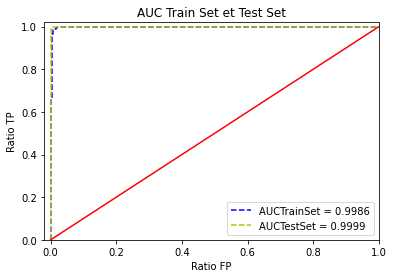

In [125]:
from sklearn.metrics import roc_auc_score, roc_curve

fprTrain, tprTrain,thresholdsTrain = metrics.roc_curve(y_train,ypred_propaBasicTrain[:,1])
roc_aucTrain = metrics.auc(fprTrain, tprTrain)

print('Espace sous AUC-ROC TrainSet:', 
      roc_auc_score(y_train,ypred_propaBasicTrain[:,1]))


fprTest, tprTest,thresholdsTest = metrics.roc_curve(y_test,ypred_propaBasicTest[:,1])
roc_aucTest = metrics.auc(fprTest, tprTest)


print('Espace sous AUC-ROC TestSet:', 
      roc_auc_score(y_test,ypred_propaBasicTest[:,1]))


plt.title('AUC Train Set et Test Set')
plt.plot(fprTrain, tprTrain, 'b--', label = 'AUCTrainSet = %0.4f' % roc_aucTrain)
plt.plot(fprTest, tprTest, 'y--', label = 'AUCTestSet = %0.4f' % roc_aucTest)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.ylabel('Ratio TP')
plt.xlabel('Ratio FP')
plt.show()

### 7.2.3 Cross Validation pour vérifier la performance de model sur train set

#### Comparaison des Scores avec ou sans cross validation

    Accuracy, Précision sont moins performant quand nous appliquons le cross validation avec le model basique
    Il y a une lèger amélioration à F1 et score de rappel.


Accuracy-----------------------------------------------------------------------------

Model Basique:

    Accuracy Score de Basic Model 0.9895238095238095
    
Cross Validation:
    
    Model Basique Logistique regression Accuracy Score: [0.99047619 0.99047619 0.99047619 0.9952381  0.97619048] 
    Model Basique Logistique regression Accuracy Score Moyen: 0.9885714285714287
    
F1 Score-----------------------------------------------------------------------------

Model Basique:
    
    F1 Score de Basic Model    0.9872108951804969

Cross Validation:
    
    Model Basique Logistique regression F1 Score: [0.9929078  0.99285714 0.99285714 0.99641577 0.98207885] 
    Model Basique Logistique regression F1 Score Moyen: 0.9914233421577279

Précision-----------------------------------------------------------------------------

Model Basique:
    
    Precision Score de Basic Model 0.9919093851132685
    
Cross Validation:    
    
    Model Basique Logistique regression precision Score: [0.98591549 0.9858156  0.9858156  0.99285714 0.97857143] 
    Model Basique Logistique regression precision Score Moyen: 0.9857950540120154 

Rappel-----------------------------------------------------------------------------

Model Basique:

    Recall Score de Basic Model 0.9828767123287672
    
Cross Validation:    
    
    Model Basique Logistique regression recall Score: [1.         1.         1.         1.         0.98561151] 
    Model Basique Logistique regression recall Score Moyen: 0.9971223021582734 



In [126]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

#découpage de dataset
kf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

#Model
LogRegBasicCVmodel = LogisticRegression(class_weight={0:0.33,1:0.66},random_state=123)
LogRegBasicCVmodel.fit(x_train_scaled,y_train)

#CrossValidation Accuracy Score
LogRegBasicCVscore_Accuracy=cross_val_score(LogRegBasicCVmodel, x_train_scaled,y_train, scoring='accuracy', cv=kf, n_jobs=-1)
LogRegBasicCVAccuracyMoy=np.mean(LogRegBasicCVscore_Accuracy)
LogRegBasicCVAccuracyStd=np.std(LogRegBasicCVscore_Accuracy)

print('Accuracy-----------------------------------------------------------------------------')
print('Model Basique Logistique regression Accuracy Score:',LogRegBasicCVscore_Accuracy,'\n',
     'Model Basique Logistique regression Accuracy Score Moyen:',LogRegBasicCVAccuracyMoy,'\n',
     'Model Basique Logistique regression Accuracy Score Ecart Type:',LogRegBasicCVAccuracyStd)

#CrossValidation F1 Score
LogRegBasicCVscore_F1=cross_val_score(LogRegBasicCVmodel, x_train_scaled,y_train, scoring='f1', cv=kf, n_jobs=-1)
LogRegBasicCVF1Moy=np.mean(LogRegBasicCVscore_F1)
LogRegBasicCVF1Std=np.std(LogRegBasicCVscore_F1)

print('F1 Score-----------------------------------------------------------------------------')
print('Model Basique Logistique regression F1 Score:',LogRegBasicCVscore_F1,'\n',
     'Model Basique Logistique regression F1 Score Moyen:',LogRegBasicCVF1Moy,'\n',
     'Model Basique Logistique regression F1 Score Ecart Type:',LogRegBasicCVF1Std)


#CrossValidation Précision Score
LogRegBasicCVscore_precision=cross_val_score(LogRegBasicCVmodel, x_train_scaled,y_train, scoring='precision', cv=kf, n_jobs=-1)
LogRegBasicCVPrecisionMoy=np.mean(LogRegBasicCVscore_precision)
LogRegBasicCVPrecisionStd=np.std(LogRegBasicCVscore_precision)

print('Précision-----------------------------------------------------------------------------')
print('Model Basique Logistique regression precision Score:',LogRegBasicCVscore_precision,'\n',
     'Model Basique Logistique regression precision Score Moyen:',LogRegBasicCVPrecisionMoy,'\n',
     'Model Basique Logistique regression precision Score Ecart Type:',LogRegBasicCVPrecisionStd)


#CrossValidation RecallScore
LogRegBasicCVscore_recall=cross_val_score(LogRegBasicCVmodel, x_train_scaled,y_train, scoring='recall', cv=kf, n_jobs=-1)
LogRegBasicCVRecallMoy=np.mean(LogRegBasicCVscore_recall)
LogRegBasicCVRecallStd=np.std(LogRegBasicCVscore_recall)

print('Rappel-----------------------------------------------------------------------------')
print('Model Basique Logistique regression recall Score:',LogRegBasicCVscore_recall,'\n',
     'Model Basique Logistique regression recall Score Moyen:',LogRegBasicCVRecallMoy,'\n',
     'Model Basique Logistique regression recall Score Ecart Type:',LogRegBasicCVRecallStd)

Accuracy-----------------------------------------------------------------------------
Model Basique Logistique regression Accuracy Score: [0.99047619 0.99047619 0.99047619 0.9952381  0.97619048] 
 Model Basique Logistique regression Accuracy Score Moyen: 0.9885714285714287 
 Model Basique Logistique regression Accuracy Score Ecart Type: 0.0064593618886907515
F1 Score-----------------------------------------------------------------------------
Model Basique Logistique regression F1 Score: [0.9929078  0.99285714 0.99285714 0.99641577 0.98207885] 
 Model Basique Logistique regression F1 Score Moyen: 0.9914233421577279 
 Model Basique Logistique regression F1 Score Ecart Type: 0.004869476497126514
Précision-----------------------------------------------------------------------------
Model Basique Logistique regression precision Score: [0.98591549 0.9858156  0.9858156  0.99285714 0.97857143] 
 Model Basique Logistique regression precision Score Moyen: 0.9857950540120154 
 Model Basique Logi

### 7.2.4 Identifier les meilleures paramétres avec GridSearchCV 

    Avec score 'f1_sample' et 'recall_sample' et cross validation 5 folds,
    LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,max_iter=100, penalty='l2', solver='lbfgs')


    
    L'erreur de prédiction de faux billet est amélioré avec GridSearchCV quand nous utilisons les données normalisées.

    Model Kmeans Avec ACP:
        FAUX BILLET Recall Score NONScaled 0.972

    Model Kmeans Sans ACP:
        FAUX BILLET Recall Score NONScaled  0.972

    ModelBasic avec données normalisées:
        FAUX BILLET Recall Score NONScaled  0.9657534246575342
    
    Model GridSearchCV avec données normalisées:
        FAUX BILLET Recall Score NONScaled 0.9794520547945206

In [127]:
#Définir le model basique avec class_weight={0:0.33,1:0.66},random_state=123
logisticRegSansScaled_GridSearchCV=LogisticRegression(class_weight={0:0.33,1:0.66},random_state=123)

In [128]:
#Définir les paramétres à évaluer avec GridSearchCV
param_grid = [    
    {'penalty' : ['l2','none'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['lbfgs','newton-cg','newton-cholesky','sag'],
    'max_iter' : [100, 1000,2500, 5000]
    },
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['saga'],
    'max_iter' : [100, 1000,2500, 5000]
    },
        {'penalty' : ['l1', 'l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['liblinear'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [129]:
#Créer les listes vides pour stocker les scores et les paramétres
estimators=[]
params=[]
GridSearchCVFAUXBILLET_recalls=[]
GridSearchCVFAUXBILLET_precisions=[]
GridSearchCVVRAISBILLET_recalls=[]
GridSearchCVVRAISBILLET_precisions=[]
GridSearchCVf1s=[]
GridSearchCVaccuracys=[]
trainloglossGridSearchCV=[]
testloglossGridSearchCV=[]

#Définir les différentes types de score à évaluer dans GridsearchCV
scorings=['neg_log_loss','roc_auc','accuracy','f1','f1_micro',
          'f1_macro','f1_weighted','f1_samples','precision',
          'recall','recall_micro','recall_macro','recall_weighted','recall_samples']


#Créer le boucle par score type
for score in scorings:

    #Utiliser kford pour séparer le train set en 5 paritions
    kf=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
    
    #Appliquer GridSearchCV sur le model de base avec les paramétres, score type, cv 5
    LR_GridSearchCV = GridSearchCV(logisticRegSansScaled_GridSearchCV, 
                                     param_grid = param_grid, scoring = score,
                                     cv = kf, verbose=True, n_jobs=-1)
    
    LR_GridSearchCV.fit(x_train_scaled,y_train)
    
    #Stocker les paramétres et estimators dans les variables 
    estimator=LR_GridSearchCV.best_estimator_
    param=LR_GridSearchCV.best_params_
    
    #Ajouter les paramétres et estimators dans listes prévues
    estimators.append(estimator)
    params.append(param)
    
    #Prédiction de test set
    yp=LR_GridSearchCV.predict(x_test_scaled)
    
    #Calculer la propabilité de trainset et logloss
    GridSearchCVypropapropatrain=LR_GridSearchCV.predict_proba(x_train_scaled)
    GridSearchCV_trainlogloss=log_loss(y_train,GridSearchCVypropapropatrain)
    
    #Calculer la propabilité de testset et logloss
    GridSearchCVypropatest=LR_GridSearchCV.predict_proba(x_test_scaled)
    GridSearchCV_testlogloss=log_loss(y_test,GridSearchCVypropatest)
    
    #Ajouter les logloss dans les listes prévues
    trainloglossGridSearchCV.append(GridSearchCV_trainlogloss)
    testloglossGridSearchCV.append(GridSearchCV_testlogloss)
    
    
    
    # stocker le rapport de classification dans variable
    GridSearchCVReport=classification_report(y_test,yp,output_dict=True)
    
    #Stocker Fauxbillet recall
    GridSearchCVFAUXBILLET_recall=GridSearchCVReport['0']['recall']
    GridSearchCVFAUXBILLET_recalls.append(GridSearchCVFAUXBILLET_recall)
    
    #Stocker Fauxbillet precision
    GridSearchCVFAUXBILLET_precision=GridSearchCVReport['0']['precision']
    GridSearchCVFAUXBILLET_precisions.append(GridSearchCVFAUXBILLET_precision)
    
    #Stocker vrais billet recall
    GridSearchCVVRAISBILLET_recall=GridSearchCVReport['1']['recall']
    GridSearchCVVRAISBILLET_recalls.append(GridSearchCVVRAISBILLET_recall)
    
    #Stocker vrais billet precision
    GridSearchCVVRAISBILLET_precision=GridSearchCVReport['1']['precision']
    GridSearchCVVRAISBILLET_precisions.append(GridSearchCVVRAISBILLET_precision)
    
    #Stocker f1 score
    GridSearchCVf1 = GridSearchCVReport['macro avg']['f1-score']
    GridSearchCVf1s.append(GridSearchCVf1)
    
    #Stocker accuracy score
    GridSearchCVaccuracy = GridSearchCVReport['accuracy']
    GridSearchCVaccuracys.append(GridSearchCVaccuracy)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits


#### Stocker et Affichier les résultats de tous les itérations via GridSearchCV pour les comparer 

In [130]:
resumeGridSearchCV=pd.DataFrame(list(zip(scorings,estimators,params,
                      GridSearchCVFAUXBILLET_recalls,GridSearchCVFAUXBILLET_precisions,
                     GridSearchCVVRAISBILLET_recalls,GridSearchCVVRAISBILLET_precisions,
                     GridSearchCVf1s,GridSearchCVaccuracys,
                    trainloglossGridSearchCV,testloglossGridSearchCV)
                 ),columns=['scorings','estimators','params',
           'GridSearchCVFAUXBILLET_recalls','GridSearchCVFAUXBILLET_precisions',
            'GridSearchCVVRAISBILLET_recalls','GridSearchCVVRAISBILLET_precisions',
            'GridSearchCVf1s','GridSearchCVaccuracys',
            'trainloglossGridSearchCV','testloglossGridSearchCV']).sort_values('GridSearchCVFAUXBILLET_recalls',ascending=False)
resumeGridSearchCV

scorings                                         estimators  \
0      neg_log_loss  LogisticRegression(C=10, class_weight={0: 0.33...   
2          accuracy  LogisticRegression(C=10, class_weight={0: 0.33...   
3                f1  LogisticRegression(C=10, class_weight={0: 0.33...   
4          f1_micro  LogisticRegression(C=10, class_weight={0: 0.33...   
5          f1_macro  LogisticRegression(C=10, class_weight={0: 0.33...   
6       f1_weighted  LogisticRegression(C=10, class_weight={0: 0.33...   
7        f1_samples  LogisticRegression(C=100, class_weight={0: 0.3...   
8         precision  LogisticRegression(C=10, class_weight={0: 0.33...   
10     recall_micro  LogisticRegression(C=10, class_weight={0: 0.33...   
11     recall_macro  LogisticRegression(C=10, class_weight={0: 0.33...   
12  recall_weighted  LogisticRegression(C=10, class_weight={0: 0.33...   
13   recall_samples  LogisticRegression(C=100, class_weight={0: 0.3...   
1           roc_auc  LogisticRegression(C=0.1, class_weight={0: 0.3...   
9            recall  LogisticRegression(C=0.01, class_weight={0: 0....   

                                               params  \
0   {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...   
2   {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
3   {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
4   {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
5   {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
6   {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
7   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
8   {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
10  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
11  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
12  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...   
13  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
1   {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '...   
9   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...   

    GridSearchCVFAUXBILLET_recalls  GridSearchCVFAUXBILLET_precisions  \
0                         0.979452                                1.0   
2                         0.979452                                1.0   
3                         0.979452                                1.0   
4                         0.979452                                1.0   
5                         0.979452                                1.0   
6                         0.979452                                1.0   
7                         0.979452                                1.0   
8                         0.979452                                1.0   
10                        0.979452                                1.0   
11                        0.979452                                1.0   
12                        0.979452                                1.0   
13                        0.979452                                1.0   
1                         0.945205                                1.0   
9                         0.835616                                1.0   

    GridSearchCVVRAISBILLET_recalls  GridSearchCVVRAISBILLET_precisions  \
0                               1.0                            0.990228   
2                               1.0                            0.990228   
3                               1.0                            0.990228   
4                               1.0                            0.990228   
5                               1.0                            0.990228   
6                               1.0                            0.990228   
7                               1.0                            0.990228   
8                               1.0                            0.990228   
10                              1.0                            0.990228   
11                              1.0                            0.990228   
12                              1.0                            0.990228   
13                              1.0             

In [131]:
resumeGridSearchCV.GridSearchCVFAUXBILLET_recalls.max()

0.9794520547945206

In [132]:
resumeGridSearchCV.testloglossGridSearchCV.min()

0.022771612993845985

In [133]:
modelselect=resumeGridSearchCV[(resumeGridSearchCV.GridSearchCVFAUXBILLET_recalls==0.9794520547945206)&(resumeGridSearchCV.testloglossGridSearchCV==0.022771612993845985)]
modelselect

scorings                                         estimators  \
7       f1_samples  LogisticRegression(C=100, class_weight={0: 0.3...   
13  recall_samples  LogisticRegression(C=100, class_weight={0: 0.3...   

                                               params  \
7   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
13  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   

    GridSearchCVFAUXBILLET_recalls  GridSearchCVFAUXBILLET_precisions  \
7                         0.979452                                1.0   
13                        0.979452                                1.0   

    GridSearchCVVRAISBILLET_recalls  GridSearchCVVRAISBILLET_precisions  \
7                               1.0                            0.990228   
13                              1.0                            0.990228   

    GridSearchCVf1s  GridSearchCVaccuracys  trainloglossGridSearchCV  \
7          0.992355               0.993333                  0.031918   
13         0.992355               0.993333                  0.031918   

    testloglossGridSearchCV  
7                  0.022772  
13                 0.022772

In [134]:
modelselect.estimators.unique()

array([LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123),
       LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123)],
      dtype=object)

In [135]:
modelselect.params.values

array([{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'},
       {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}],
      dtype=object)

#### La meilleure hyperparamétres identifié avec les données normalisés

    Avec score 'f1_sample' et 'recall_sample' et cross validation 5 folds, le meilleur model identifié est 
    LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,max_iter=100, penalty='l2', solver='lbfgs')
    
    
        
    L'erreur de prédiction de faux billet est amélioré avec GridSearchCV quand nous utilisons les données normalisées.
    
    Model Kmeans Avec ACP:
        FAUX BILLET Recall Score NONScaled 0.972
    
    Mpdel Kmeans Sans ACP:
        FAUX BILLET Recall Score NONScaled  0.972
    
    ModelBasic avec données normalisées:
        FAUX BILLET Recall Score NONScaled  0.9657534246575342
        
    Model GridSearchCV avec données normalisées:
        FAUX BILLET Recall Score NONScaled 0.9794520547945206


In [136]:
#Identifier le faux billet recall score maximum obtenu
resumeGridSearchCV['GridSearchCVFAUXBILLET_recalls'].unique().max()

0.9794520547945206

In [137]:
#Identifier le faux billet testset logloss minimum obtenu
resumeGridSearchCV['testloglossGridSearchCV'].unique().min()

0.022771612993845985

In [138]:
#Affichier les models avec le maximum de faux billet recall score, et minimum de test logloss
modelIdentifie1=resumeGridSearchCV[resumeGridSearchCV['testloglossGridSearchCV']==0.022771612993845985]
modelIdentifie1

scorings                                         estimators  \
7       f1_samples  LogisticRegression(C=100, class_weight={0: 0.3...   
13  recall_samples  LogisticRegression(C=100, class_weight={0: 0.3...   

                                               params  \
7   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
13  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   

    GridSearchCVFAUXBILLET_recalls  GridSearchCVFAUXBILLET_precisions  \
7                         0.979452                                1.0   
13                        0.979452                                1.0   

    GridSearchCVVRAISBILLET_recalls  GridSearchCVVRAISBILLET_precisions  \
7                               1.0                            0.990228   
13                              1.0                            0.990228   

    GridSearchCVf1s  GridSearchCVaccuracys  trainloglossGridSearchCV  \
7          0.992355               0.993333                  0.031918   
13         0.992355               0.993333                  0.031918   

    testloglossGridSearchCV  
7                  0.022772  
13                 0.022772

In [139]:
#Affichier les estimators de meilleur model
modelIdentifie1['estimators'].unique()

array([LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123),
       LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123)],
      dtype=object)

In [140]:
#Affichier les params de meilleur model
modelIdentifie1['params'].tolist()

[{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}]

In [141]:
modelIdentifie1.GridSearchCVFAUXBILLET_recalls.tolist()

[0.9794520547945206, 0.9794520547945206]

### 7.2.5 Appliquer la meilleure hyperparamétré (donnés normalisé) à régression logistique

##### Importer meilleur model et calculer Accuracy Socre
    Best Model avec donnée normalisé train accuracy score: 0.9914285714285714
    Best Model avec donnée normalisé test accuracy score: 0.9888888888888889

In [142]:
lrdNorm=LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,max_iter=100, penalty='l2', solver='lbfgs')
lrdNorm.fit(x_train_scaled,y_train)

lrdNorm_trainaccuracy=lrdNorm.score(x_train_scaled,y_train)
print('Best Model avec donnée normalisé train accuracy score:',lrdNorm_trainaccuracy)

lrdNorm_predict=lrdNorm.predict(x_test_scaled)
lrdNorm_testaccuracy=logisticRegBasic.score(x_test_scaled,y_test)
print('Best Model avec donnée normalisé test accuracy score:',lrdNorm_testaccuracy)


Best Model avec donnée normalisé train accuracy score: 0.9914285714285714
Best Model avec donnée normalisé test accuracy score: 0.9888888888888889


##### Coefficients des variable et Intercept

Variable  Coéfficient Logistique Regression
0      diagonal                          -0.239751
1   height_left                          -0.288137
2  height_right                          -0.776824
3    margin_low                          -3.969814
4     margin_up                          -1.857084
5        length                           4.814069
6     intercept                           2.611895

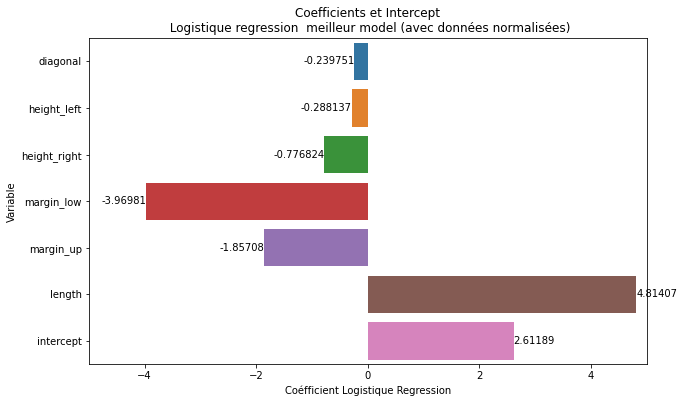

In [143]:
feature_names=x.columns

lrdNormCoefIntercept=pd.DataFrame(list(zip(feature_names,lrdNorm.coef_[0])),
                                      columns=['Variable','Coéfficient Logistique Regression'])
new_row = {'Variable':'intercept', 
           'Coéfficient Logistique Regression':lrdNorm.intercept_[0]}

lrdNormCoefIntercept = lrdNormCoefIntercept.append(new_row, ignore_index=True)

display(lrdNormCoefIntercept)


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='Variable',x='Coéfficient Logistique Regression',data=lrdNormCoefIntercept,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-5,5)

plt.title('Coefficients et Intercept\n Logistique regression  meilleur model (avec données normalisées)')
plt.show()

Best Model Matrice confusion [[143   3]
 [  0 304]]


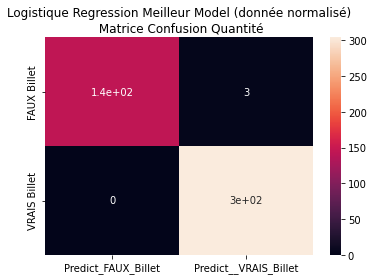

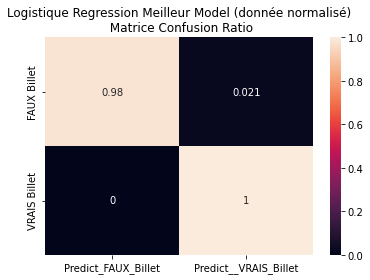

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       146
           1       0.99      1.00      1.00       304

    accuracy                           0.99       450
   macro avg       1.00      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

Precision Score de Meilleur Model (donnée normalisé) 0.995114006514658
Recall Score de Meilleur Model (donnée normalisé) 0.9897260273972603
F1 Score de Meilleur Model (donnée normalisé) 0.9923546967646208
Accuracy Score de Meilleur Model (donnée normalisé) 0.9933333333333333
VRAIS BILLET Précision Score 0.990228013029316
VRAIS BILLET Recall Score de Meilleur Model (donnée normalisé) 1.0
FAUX BILLET Précision Score de Meilleur Model (donnée normalisé) 1.0
FAUX BILLET Recall Score de Meilleur Model (donnée normalisé) 0.9794520547945206


In [144]:
lrdNorm_matriceconfusion=metrics.confusion_matrix(y_test,lrdNorm_predict)
print('Best Model Matrice confusion',lrdNorm_matriceconfusion)

sns.heatmap(lrdNorm_matriceconfusion,
            xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Meilleur Model (donnée normalisé)\n Matrice Confusion Quantité')
plt.show()

lrdNorm_MatriceRatio=lrdNorm_matriceconfusion/lrdNorm_matriceconfusion.sum(axis=1).reshape(-1,1)
sns.heatmap(lrdNorm_MatriceRatio,xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Meilleur Model (donnée normalisé)\n Matrice Confusion Ratio')
plt.show()

print(classification_report(y_test,lrdNorm_predict))

#Extraction les scores de tableau classification report

lrdNormReport=classification_report(y_test,lrdNorm_predict,output_dict=True)

lrdNorm_precision =  lrdNormReport['macro avg']['precision'] 
print('Precision Score de Meilleur Model (donnée normalisé)',lrdNorm_precision)

lrdNorm_recall = lrdNormReport['macro avg']['recall']    
print('Recall Score de Meilleur Model (donnée normalisé)',lrdNorm_recall)

lrdNorm_f1 = lrdNormReport['macro avg']['f1-score']
print('F1 Score de Meilleur Model (donnée normalisé)',lrdNorm_f1)

lrdNorm_accuracy = lrdNormReport['accuracy']
print('Accuracy Score de Meilleur Model (donnée normalisé)',lrdNorm_accuracy)

lrdNormVRAISBILLET_precision=lrdNormReport['1']['precision']
print('VRAIS BILLET Précision Score',lrdNormVRAISBILLET_precision)

lrdNormVRAISBILLET_recall=lrdNormReport['1']['recall']
print('VRAIS BILLET Recall Score de Meilleur Model (donnée normalisé)',lrdNormVRAISBILLET_recall)

lrdNormFAUXBILLET_precision=lrdNormReport['0']['precision']
print('FAUX BILLET Précision Score de Meilleur Model (donnée normalisé)',lrdNormFAUXBILLET_precision)

lrdNormFAUXBILLET_recall=lrdNormReport['0']['recall']
print('FAUX BILLET Recall Score de Meilleur Model (donnée normalisé)',lrdNormFAUXBILLET_recall)


##### LogLoss de meilleur model (donnée normalisé)

    Train set Log Loss de Meilleur Model (donnée normalisé): 0.03191779479818798
    Test set Log Loss de Meilleur Model (donnée normalisé): 0.022771612993845985

In [145]:
lrdNormPropaTrain=lrdNorm.predict_proba(x_train_scaled)
lrdNorm_trainlogloss=log_loss(y_train,lrdNormPropaTrain)
print('Train set Log Loss de Meilleur Model (donnée normalisé):',lrdNorm_trainlogloss)

lrdNormPropaTest=lrdNorm.predict_proba(x_test_scaled)
lrdNorm_testlogloss=log_loss(y_test,lrdNormPropaTest)
print('Test set Log Loss de Meilleur Model (donnée normalisé):',lrdNorm_testlogloss)

Train set Log Loss de Meilleur Model (donnée normalisé): 0.03191779479818798
Test set Log Loss de Meilleur Model (donnée normalisé): 0.022771612993845985


##### ROC AUC Score
    roc_auc_score de Meilleur Model (donnée normalisé)  0.982876712328767
    Espace sous AUC-ROC TrainSet de Meilleur Model (donnée normalisé): 0.9984292811221508
    Espace sous AUC-ROC TestSet de Meilleur Model (donnée normalisé): 0.9997521629416005


roc_auc_score de Meilleur Model (donnée normalisé)


0.982876712328767

Espace sous AUC-ROC TrainSet de Meilleur Model (donnée normalisé): 0.9984292811221508
Espace sous AUC-ROC TestSet de Meilleur Model (donnée normalisé): 0.9997521629416005


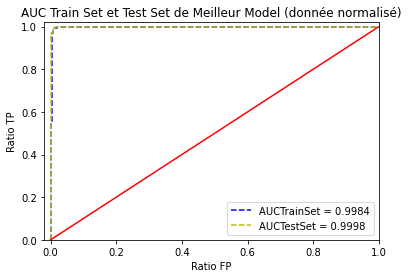

In [146]:
print('roc_auc_score de Meilleur Model (donnée normalisé)')
display(roc_auc_score(y_test,y_BasicPredict))

fprTrain, tprTrain,thresholdsTrain = metrics.roc_curve(y_train,lrdNormPropaTrain[:,1])
roc_aucTrain = metrics.auc(fprTrain, tprTrain)

print('Espace sous AUC-ROC TrainSet de Meilleur Model (donnée normalisé):', 
      roc_auc_score(y_train,lrdNormPropaTrain[:,1]))


fprTest, tprTest,thresholdsTest = metrics.roc_curve(y_test,lrdNormPropaTest[:,1])
roc_aucTest = metrics.auc(fprTest, tprTest)


print('Espace sous AUC-ROC TestSet de Meilleur Model (donnée normalisé):', 
      roc_auc_score(y_test,lrdNormPropaTest[:,1]))


plt.title('AUC Train Set et Test Set de Meilleur Model (donnée normalisé)')
plt.plot(fprTrain, tprTrain, 'b--', label = 'AUCTrainSet = %0.4f' % roc_aucTrain)
plt.plot(fprTest, tprTest, 'y--', label = 'AUCTestSet = %0.4f' % roc_aucTest)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.ylabel('Ratio TP')
plt.xlabel('Ratio FP')
plt.show()

## 7.3 Logistique Regression avec les données Variables non normalisés

### 7.3.1 Regression Logistique de Base avec les données non normalisés

#### Trainset Accuracy Score est 0.9866666666666667

In [147]:
#importer model base
logisticRegBasic_nonscaled=LogisticRegression(class_weight={0:0.33,1:0.66},random_state=123)
logisticRegBasic_nonscaled.fit(x_train,y_train)

#calculer accuracy score de train set
logRegBasicscoretrain_nonscaled=logisticRegBasic_nonscaled.score(x_train,y_train)
print('logistique Regression Basic score_train:',logRegBasicscoretrain_nonscaled)

logistique Regression Basic score_train: 0.9866666666666667


#### Coéfficients des Variable et Intercept de Model Basic de Regression Logistique

In [148]:
feature_names=x.columns
logisticRegBasic_nonscaledCoefIntercept=pd.DataFrame(list(zip(feature_names,logisticRegBasic_nonscaled.coef_[0])),
                                      columns=['Variable','Coéfficient Logistique Regression'])
new_row = {'Variable':'intercept', 
           'Coéfficient Logistique Regression':logisticRegBasic_nonscaled.intercept_[0]}

logisticRegBasic_nonscaledCoefIntercept = logisticRegBasic_nonscaledCoefIntercept.append(new_row, ignore_index=True)
logisticRegBasic_nonscaledCoefIntercept

Variable  Coéfficient Logistique Regression
0      diagonal                          -0.360246
1   height_left                          -1.177813
2  height_right                          -1.522934
3    margin_low                          -3.068667
4     margin_up                          -1.913160
5        length                           3.234424
6     intercept                          -0.018276

#### Visualiser les coéfficients des variable et l'intercept

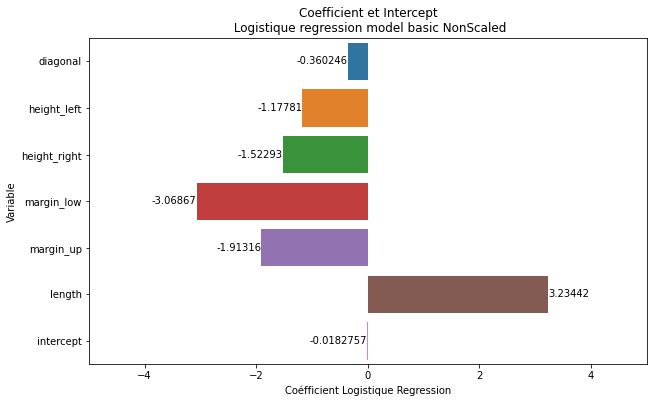

In [149]:


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='Variable',x='Coéfficient Logistique Regression',data=logisticRegBasic_nonscaledCoefIntercept,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-5,5)

plt.title('Coefficient et Intercept\n Logistique regression model basic NonScaled')
plt.show()

#### Test set Accuracy Score est 0.9911111111111112

In [150]:
#Prédiction testset
y_BasicPredictNonScaled=logisticRegBasic_nonscaled.predict(x_test)

#Calculer test set accuracy score
logisticRegBasicTest_nonscaled=logisticRegBasic_nonscaled.score(x_test,y_test)
print('logRegBasic score_test:',logisticRegBasicTest_nonscaled)

logRegBasic score_test: 0.9911111111111112


#### Visualiser la comparaison de prédiction et étiquette réelle de test set par variable

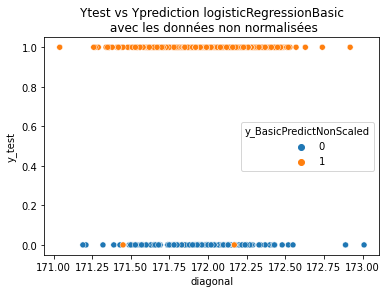

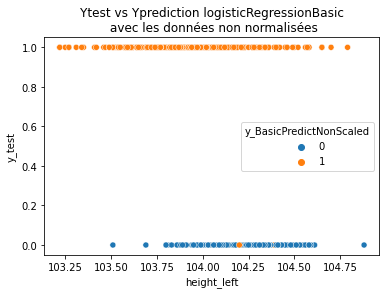

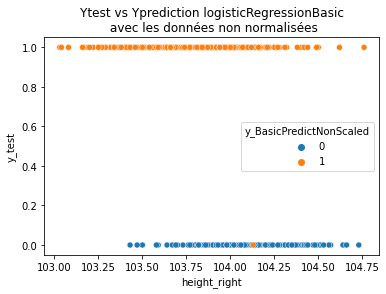

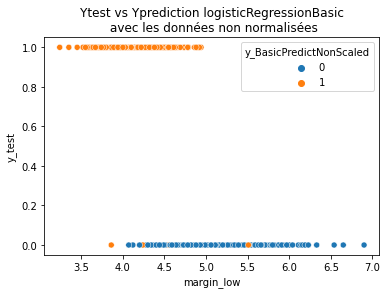

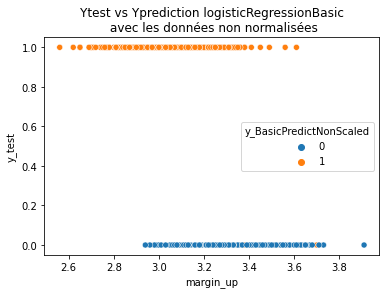

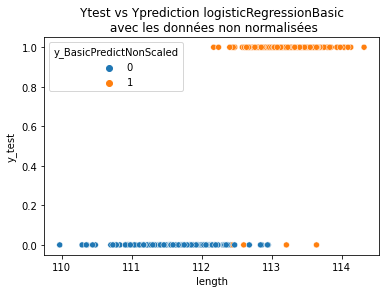

In [151]:
dflogisticRegBasic_nonscaled=x_test[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]
dflogisticRegBasic_nonscaled['y_BasicPredictNonScaled']=y_BasicPredictNonScaled
dflogisticRegBasic_nonscaled['y_test']=y_test
for i in ['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']:
    sns.scatterplot(x = i, y = 'y_test', hue = 'y_BasicPredictNonScaled', data = dflogisticRegBasic_nonscaled)
    plt.title('Ytest vs Yprediction logisticRegressionBasic\n avec les données non normalisées')
    plt.show()

#### Matrice de confusion Model basique

    Dans le TestSet, 4 FAUX Billets sont prédit en VRAIS Billets soit 2.7% d'erreur de prédiction dans les faux billets, 0 VRAIS Billets sont prédit en FAUX Billet
        L'objectif de projet est de préfèrer d'améliorer le score rappel(recall) pour éviter mal prédiction de FAUX billet,
        nous devons utiliser les paramétrers pour augmenter le score de rappel(recall) pour l'améliorer la performance de l'algorithme.

In [152]:
logisticRegBasic_nonscaled_matrice_confusion=metrics.confusion_matrix(y_test,y_BasicPredictNonScaled)
print(logisticRegBasic_nonscaled_matrice_confusion)

[[142   4]
 [  0 304]]


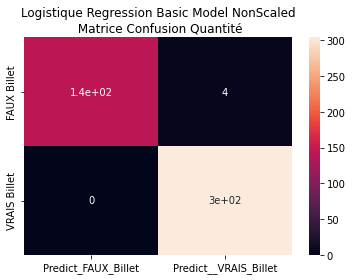

In [153]:
sns.heatmap(logisticRegBasic_nonscaled_matrice_confusion,
            xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Basic Model NonScaled\n Matrice Confusion Quantité')
plt.show()

##### Matrice de confusion en ratio

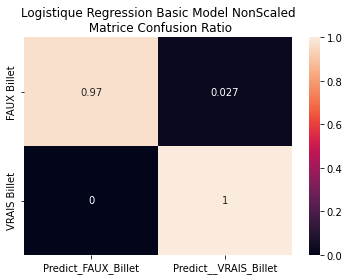

In [154]:
logisticRegBasic_nonscaled_MatriceRatio=logisticRegBasic_nonscaled_matrice_confusion/logisticRegBasic_nonscaled_matrice_confusion.sum(axis=1).reshape(-1,1)
sns.heatmap(logisticRegBasic_nonscaled_MatriceRatio,xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Basic Model NonScaled\n Matrice Confusion Ratio')
plt.show()

#### Evaluation de model basique

In [155]:
print(classification_report(y_test,y_BasicPredictNonScaled))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       146
           1       0.99      1.00      0.99       304

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [156]:
#Extraction des score de classification_report

LogRegBasicNonScaledReport=classification_report(y_test,y_BasicPredictNonScaled,output_dict=True)

LogRegBasicNonScaled_precision =  LogRegBasicNonScaledReport['macro avg']['precision'] 
print('Precision Score de Basic Model NonScaled',LogRegBasicNonScaled_precision)

LogRegBasicNonScaled_recall = LogRegBasicNonScaledReport['macro avg']['recall']    
print('Recall Score de Basic Model NonScaled',LogRegBasicNonScaled_recall)

LogRegBasicNonScaled_f1 = LogRegBasicNonScaledReport['macro avg']['f1-score']
print('F1 Score de Basic Model NonScaled',LogRegBasicNonScaled_f1)

LogRegBasicNonScaled_accuracy = LogRegBasicNonScaledReport['accuracy']
print('Accuracy Score de Basic Model NonScaled',LogRegBasicNonScaled_accuracy)

Precision Score de Basic Model NonScaled 0.9935064935064934
Recall Score de Basic Model NonScaled 0.9863013698630136
F1 Score de Basic Model NonScaled 0.9897875816993464
Accuracy Score de Basic Model NonScaled 0.9911111111111112


In [157]:
LogRegBasicVRAISBILLET_precisionNONScaled=LogRegBasicNonScaledReport['1']['precision']
print('VRAIS BILLET Précision Score NONScaled',LogRegBasicVRAISBILLET_precisionNONScaled)

LogRegBasicVRAISBILLET_recallNONScaled=LogRegBasicNonScaledReport['1']['recall']
print('VRAIS BILLET Recall Score NONScaled',LogRegBasicVRAISBILLET_recallNONScaled)

LogRegBasicFAUXBILLET_precisionNONScaled=LogRegBasicNonScaledReport['0']['precision']
print('FAUX BILLET Précision Score NONScaled',LogRegBasicFAUXBILLET_precisionNONScaled)

LogRegBasicFAUXBILLET_recallNONScaled=LogRegBasicNonScaledReport['0']['recall']
print('FAUX BILLET Recall Score NONScaled',LogRegBasicFAUXBILLET_recallNONScaled)


VRAIS BILLET Précision Score NONScaled 0.987012987012987
VRAIS BILLET Recall Score NONScaled 1.0
FAUX BILLET Précision Score NONScaled 1.0
FAUX BILLET Recall Score NONScaled 0.9726027397260274


#### Evaluer model base avec Logloss
    Train set Log Loss de model basic de logistique regression: 0.05198386317803727
    Test set Log Loss de model basic de logistique regression: 0.04887140119154596

In [158]:
from sklearn.metrics import log_loss

ypred_propaBasicTrainNonScaled=logisticRegBasic_nonscaled.predict_proba(x_train)
LogRegBasicNonScaled_trainlogloss=log_loss(y_train,ypred_propaBasicTrainNonScaled)
print('Train set Log Loss de model basic de logistique regression:',LogRegBasicNonScaled_trainlogloss)

ypred_propaBasicTestNonScaled=logisticRegBasic_nonscaled.predict_proba(x_test)
LogRegBasicNonScaled_testlogloss=log_loss(y_test,ypred_propaBasicTestNonScaled)
print('Test set Log Loss de model basic de logistique regression:',LogRegBasicNonScaled_testlogloss)

Train set Log Loss de model basic de logistique regression: 0.05198386317803727
Test set Log Loss de model basic de logistique regression: 0.04887140119154596


#### Evaluer niveau de surapprentissage avec AUC ROC
    Roc_Auc Score: 0.9863013698630136
    Espace sous AUC-ROC TrainSet NonScaled: 0.9978691798168712
    Espace sous AUC-ROC TestSet NonScaled: 0.9994592645998558

In [159]:
from sklearn.metrics import roc_auc_score
print('Roc_Auc Score:',roc_auc_score(y_test,y_BasicPredictNonScaled))

Roc_Auc Score: 0.9863013698630136


Espace sous AUC-ROC TrainSet NonScaled: 0.9978691798168712
Espace sous AUC-ROC TestSet NonScaled: 0.9994592645998558


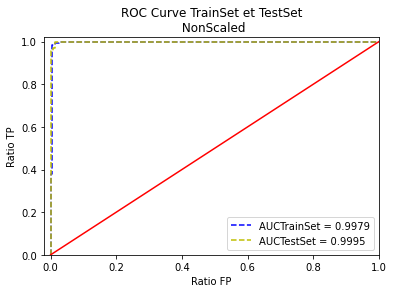

In [160]:
from sklearn.metrics import roc_auc_score, roc_curve

fprTrain, tprTrain,thresholdsTrain = metrics.roc_curve(y_train,ypred_propaBasicTrainNonScaled[:,1])
roc_aucTrain = metrics.auc(fprTrain, tprTrain)

print('Espace sous AUC-ROC TrainSet NonScaled:', 
      roc_auc_score(y_train,ypred_propaBasicTrainNonScaled[:,1]))


fprTest, tprTest,thresholdsTest = metrics.roc_curve(y_test,ypred_propaBasicTestNonScaled[:,1])
roc_aucTest = metrics.auc(fprTest, tprTest)


print('Espace sous AUC-ROC TestSet NonScaled:', 
      roc_auc_score(y_test,ypred_propaBasicTestNonScaled[:,1]))


plt.title('ROC Curve TrainSet et TestSet\n NonScaled')
plt.plot(fprTrain, tprTrain, 'b--', label = 'AUCTrainSet = %0.4f' % roc_aucTrain)
plt.plot(fprTest, tprTest, 'y--', label = 'AUCTestSet = %0.4f' % roc_aucTest)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.ylabel('Ratio TP')
plt.xlabel('Ratio FP')
plt.show()

### 7.3.2 Cross Validation Evaluer le model avec train set

#### Comparaison des Scores avec ou sans cross validation (dataset non Normalisé)


    Accuracy, F1, Précision sont moins performant quand nous appliquons le cross validation avec le model basique
    Il y a une lèger amélioration à score de rappel.

Accuracy-----------------------------------------------------------------------------

Model Basique:

    Accuracy Score de Basic Model 0.9911111111111112

Cross Validation:
    
    Model Basique Logistique regression Accuracy Score: [0.98095238 0.98095238 0.99047619 1.         0.97619048] 
    Model Basique Logistique regression Accuracy Score Moyen: 0.9857142857142858 

F1 Score-----------------------------------------------------------------------------

Model Basique:
    
    F1 Score de Basic Model 0.9897875816993464

Cross Validation:
    
    Model Basique Logistique regression F1 Score: [0.98591549 0.9858156  0.99285714 1.         0.98220641] 
    Model Basique Logistique regression F1 Score Moyen: 0.9893589288691438 

Précision-----------------------------------------------------------------------------

Model Basique:
    
    Precision Score de Basic Model 0.9935064935064934
    
Cross Validation:    
    
    Model Basique Logistique regression precision Score: [0.97222222 0.97202797 0.9858156  1.         0.97183099] 
    Model Basique Logistique regression precision Score Moyen: 0.9803793566005133 

Rappel-----------------------------------------------------------------------------

Model Basique:

    Recall Score de Basic Model 0.9863013698630136
    
Cross Validation:    
    
    Model Basique Logistique regression recall Score: [1.         1.         1.         1.         0.99280576] 
    Model Basique Logistique regression recall Score Moyen: 0.9985611510791367 



In [161]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

#découpage de dataset
kf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

#Model
LogRegBasicCVmodelNonScaled = LogisticRegression(class_weight={0:0.33,1:0.66},random_state=123)
LogRegBasicCVmodelNonScaled.fit(x_train,y_train)

#CrossValidation Accuracy Score
LogRegBasicCVscore_AccuracyNonScaled=cross_val_score(LogRegBasicCVmodelNonScaled, x_train,y_train, scoring='accuracy', cv=kf, n_jobs=-1)
LogRegBasicCVAccuracyMoyNonScaled=np.mean(LogRegBasicCVscore_AccuracyNonScaled)
LogRegBasicCVAccuracyStdNonScaled=np.std(LogRegBasicCVscore_AccuracyNonScaled)

print('Accuracy NonScaled-----------------------------------------------------------------------------')
print('Model Basique NonScaled Logistique regression Accuracy Score:',LogRegBasicCVscore_AccuracyNonScaled,'\n',
     'Model Basique NonScaled Logistique regression Accuracy Score Moyen:',LogRegBasicCVAccuracyMoyNonScaled,'\n',
     'Model Basique NonScaled Logistique regression Accuracy Score Ecart Type:',LogRegBasicCVAccuracyStdNonScaled)

#CrossValidation F1 Score
LogRegBasicCVscore_F1NonScaled=cross_val_score(LogRegBasicCVmodelNonScaled, x_train,y_train, scoring='f1', cv=kf, n_jobs=-1)
LogRegBasicCVF1MoyNonScaled=np.mean(LogRegBasicCVscore_F1NonScaled)
LogRegBasicCVF1StdNonScaled=np.std(LogRegBasicCVscore_F1NonScaled)

print('F1 Score NonScaled-----------------------------------------------------------------------------')
print('Model Basique NonScaled Logistique regression F1 Score:',LogRegBasicCVscore_F1NonScaled,'\n',
     'Model Basique NonScaled Logistique regression F1 Score Moyen:',LogRegBasicCVF1MoyNonScaled,'\n',
     'Model Basique NonScaled Logistique regression F1 Score Ecart Type:',LogRegBasicCVF1StdNonScaled)


#CrossValidation Précision Score
LogRegBasicCVscore_precisionNonScaled=cross_val_score(LogRegBasicCVmodelNonScaled, x_train,y_train, scoring='precision', cv=kf, n_jobs=-1)
LogRegBasicCVPrecisionMoyNonScaled=np.mean(LogRegBasicCVscore_precisionNonScaled)
LogRegBasicCVPrecisionStdNonScaled=np.std(LogRegBasicCVscore_precisionNonScaled)

print('Précision NonScaled-----------------------------------------------------------------------------')
print('Model Basique NonScaled Logistique regression precision Score:',LogRegBasicCVscore_precisionNonScaled,'\n',
     'Model Basique NonScaled Logistique regression precision Score Moyen:',LogRegBasicCVPrecisionMoyNonScaled,'\n',
     'Model Basique NonScaled Logistique regression precision Score Ecart Type:',LogRegBasicCVPrecisionStdNonScaled)


#CrossValidation RecallScore
LogRegBasicCVscore_recallNonScaled=cross_val_score(LogRegBasicCVmodelNonScaled, x_train,y_train, scoring='recall', cv=kf, n_jobs=-1)
LogRegBasicCVRecallMoyNonScaled=np.mean(LogRegBasicCVscore_recallNonScaled)
LogRegBasicCVRecallStdNonScaled=np.std(LogRegBasicCVscore_recallNonScaled)

print('Rappel NonScaled-----------------------------------------------------------------------------')
print('Model Basique NonScaled Logistique regression recall Score:',LogRegBasicCVscore_recallNonScaled,'\n',
     'Model Basique NonScaled Logistique regression recall Score Moyen:',LogRegBasicCVRecallMoyNonScaled,'\n',
     'Model Basique NonScaled Logistique regression recall Score Ecart Type:',LogRegBasicCVRecallStdNonScaled)

Accuracy NonScaled-----------------------------------------------------------------------------
Model Basique NonScaled Logistique regression Accuracy Score: [0.98095238 0.98095238 0.99047619 1.         0.97619048] 
 Model Basique NonScaled Logistique regression Accuracy Score Moyen: 0.9857142857142858 
 Model Basique NonScaled Logistique regression Accuracy Score Ecart Type: 0.008518354199999217
F1 Score NonScaled-----------------------------------------------------------------------------
Model Basique NonScaled Logistique regression F1 Score: [0.98591549 0.9858156  0.99285714 1.         0.98220641] 
 Model Basique NonScaled Logistique regression F1 Score Moyen: 0.9893589288691438 
 Model Basique NonScaled Logistique regression F1 Score Ecart Type: 0.0063409919403241526
Précision NonScaled-----------------------------------------------------------------------------
Model Basique NonScaled Logistique regression precision Score: [0.97222222 0.97202797 0.9858156  1.         0.97183099] 

### 7.3.3 Etudier les meilleures paramétre avec GridSearchCV 
    
    Avec score 'accuracy','f1','f1_micro','f1_macro','f1_weighted','precision','recall_micro','recall_macro','recall_weighted' 
    cross validation 5 folds,
    GrideSearchCV a identifié la meilleure paramétre est:
    LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,solver='newton-cg',max_iter=100, penalty='l2')

    Ce model amélioré a obtenu un score plus haut pour le FAUX billet recall et Les logloss de Train set et Test Set
    Recall faux billet: 0.9794520547945206

    Losslog Test Set: 0.023890322792647318

In [162]:
#Initialiser le model
LRNonScaled=LogisticRegression(class_weight={0:0.33,1:0.66},random_state=123)

In [163]:
#définir les hyperparametres
param_grid = [    
    {'penalty' : ['l2','none'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['lbfgs','newton-cg','newton-cholesky','sag'],
    'max_iter' : [100, 1000,2500, 5000]
    },
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['saga'],
    'max_iter' : [100, 1000,2500, 5000]
    },
        {'penalty' : ['l1', 'l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01],
    'solver' : ['liblinear'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [164]:
#Définir les listes vides pour socker les paramétres et les scores
estimatorsNonScaled=[]
paramsNonScaled=[]
GridSearchCVNonScaledFAUXBILLET_recalls=[]
GridSearchCVNonScaledFAUXBILLET_precisions=[]
GridSearchCVNonScaledVRAISBILLET_recalls=[]
GridSearchCVNonScaledVRAISBILLET_precisions=[]
GridSearchCVNonScaledf1s=[]
GridSearchCVNonScaledaccuracys=[]
trainloglossGridSearchCVNonScaled=[]
testloglossGridSearchCVNonScaled=[]

#Définir les types de score à appliquer
scorings=['neg_log_loss','roc_auc','accuracy','f1','f1_micro',
          'f1_macro','f1_weighted','f1_samples','precision',
          'recall','recall_micro','recall_macro','recall_weighted','recall_samples']

#Boucle en applicant le liste de hyperparamétre et des scores type
for score in scorings:

    #Kfold sépare données en 5 paritions
    kf=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)
    
    #Appliquer model à GrideSearch CV avec les paramétres prédifinies
    LR_GridSearchCVNonScaled = GridSearchCV(LRNonScaled, 
                                     param_grid = param_grid, scoring = score,
                                     cv = kf, verbose=True, n_jobs=-1)
    LR_GridSearchCVNonScaled.fit(x_train,y_train)
    estimator=LR_GridSearchCVNonScaled.best_estimator_
    param=LR_GridSearchCVNonScaled.best_params_
    estimatorsNonScaled.append(estimator)
    paramsNonScaled.append(param)
    
    
    #Prédiction de test set
    ypNonScaled=LR_GridSearchCVNonScaled.predict(x_test)
    
    #Propabilité et logloss de train set
    GridSearchCVypropapropatrainNonScaled=LR_GridSearchCVNonScaled.predict_proba(x_train)
    GridSearchCV_trainloglossNonScaled=log_loss(y_train,GridSearchCVypropapropatrainNonScaled)
    
    #Propabilité et logloss de test set
    GridSearchCVypropatestNonScaled=LR_GridSearchCVNonScaled.predict_proba(x_test)
    GridSearchCV_testloglossNonScaled=log_loss(y_test,GridSearchCVypropatestNonScaled)
    
    trainloglossGridSearchCVNonScaled.append(GridSearchCV_trainloglossNonScaled)
    testloglossGridSearchCVNonScaled.append(GridSearchCV_testloglossNonScaled)
    
    
    
    # Scores obtenus et Extraction de scores
    GridSearchCVReportNonScaled=classification_report(y_test,ypNonScaled,output_dict=True)
    
    GridSearchCVFAUXBILLET_recallNonScaled=GridSearchCVReportNonScaled['0']['recall']
    GridSearchCVNonScaledFAUXBILLET_recalls.append(GridSearchCVFAUXBILLET_recallNonScaled)
    
    GridSearchCVFAUXBILLET_precisionNonScaled=GridSearchCVReportNonScaled['0']['precision']
    GridSearchCVNonScaledFAUXBILLET_precisions.append(GridSearchCVFAUXBILLET_precisionNonScaled)
    
    GridSearchCVVRAISBILLET_recallNonScaled=GridSearchCVReportNonScaled['1']['recall']
    GridSearchCVNonScaledVRAISBILLET_recalls.append(GridSearchCVVRAISBILLET_recallNonScaled)
    
    GridSearchCVVRAISBILLET_precisionNonScaled=GridSearchCVReportNonScaled['1']['precision']
    GridSearchCVNonScaledVRAISBILLET_precisions.append(GridSearchCVVRAISBILLET_precisionNonScaled)
    
    GridSearchCVf1NonScaled = GridSearchCVReportNonScaled['macro avg']['f1-score']
    GridSearchCVNonScaledf1s.append(GridSearchCVf1NonScaled)
    
    GridSearchCVaccuracyNonScaled = GridSearchCVReportNonScaled['accuracy']
    GridSearchCVNonScaledaccuracys.append(GridSearchCVaccuracyNonScaled)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Fitting 5 folds for each of 280 candidates, totalling 1400 fits


#### Synthètiser les paramétres , les types de scores, et les scores obtenus dans une data frame

In [165]:
resumeGridSearchCVNonScaled=pd.DataFrame(list(zip(scorings,estimatorsNonScaled,paramsNonScaled,
                      GridSearchCVNonScaledFAUXBILLET_recalls,GridSearchCVNonScaledFAUXBILLET_precisions,
                     GridSearchCVNonScaledVRAISBILLET_recalls,GridSearchCVNonScaledVRAISBILLET_precisions,
                     GridSearchCVNonScaledf1s,GridSearchCVNonScaledaccuracys,
                    trainloglossGridSearchCVNonScaled,testloglossGridSearchCVNonScaled)
                 ),columns=['scorings','estimators','params',
           'GridSearchCVFAUXBILLET_recalls','GridSearchCVFAUXBILLET_precisions',
            'GridSearchCVVRAISBILLET_recalls','GridSearchCVVRAISBILLET_precisions',
            'GridSearchCVf1s','GridSearchCVaccuracys',
            'trainloglossGridSearchCV','testloglossGridSearchCV']).sort_values('GridSearchCVFAUXBILLET_recalls',ascending=False)
resumeGridSearchCVNonScaled

scorings                                         estimators  \
0      neg_log_loss  LogisticRegression(C=100, class_weight={0: 0.3...   
1           roc_auc  LogisticRegression(C=100, class_weight={0: 0.3...   
2          accuracy  LogisticRegression(C=100, class_weight={0: 0.3...   
3                f1  LogisticRegression(C=100, class_weight={0: 0.3...   
4          f1_micro  LogisticRegression(C=100, class_weight={0: 0.3...   
5          f1_macro  LogisticRegression(C=100, class_weight={0: 0.3...   
6       f1_weighted  LogisticRegression(C=100, class_weight={0: 0.3...   
7        f1_samples  LogisticRegression(C=100, class_weight={0: 0.3...   
8         precision  LogisticRegression(C=100, class_weight={0: 0.3...   
10     recall_micro  LogisticRegression(C=100, class_weight={0: 0.3...   
11     recall_macro  LogisticRegression(C=100, class_weight={0: 0.3...   
12  recall_weighted  LogisticRegression(C=100, class_weight={0: 0.3...   
13   recall_samples  LogisticRegression(C=100, class_weight={0: 0.3...   
9            recall  LogisticRegression(C=100, class_weight={0: 0.3...   

                                               params  \
0   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
1   {'C': 100, 'max_iter': 1000, 'penalty': 'l1', ...   
2   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
3   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
4   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
5   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
6   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
7   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
8   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
10  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
11  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
12  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
13  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
9   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   

    GridSearchCVFAUXBILLET_recalls  GridSearchCVFAUXBILLET_precisions  \
0                         0.979452                                1.0   
1                         0.979452                                1.0   
2                         0.979452                                1.0   
3                         0.979452                                1.0   
4                         0.979452                                1.0   
5                         0.979452                                1.0   
6                         0.979452                                1.0   
7                         0.979452                                1.0   
8                         0.979452                                1.0   
10                        0.979452                                1.0   
11                        0.979452                                1.0   
12                        0.979452                                1.0   
13                        0.979452                                1.0   
9                         0.376712                                1.0   

    GridSearchCVVRAISBILLET_recalls  GridSearchCVVRAISBILLET_precisions  \
0                               1.0                            0.990228   
1                               1.0                            0.990228   
2                               1.0                            0.990228   
3                               1.0                            0.990228   
4                               1.0                            0.990228   
5                               1.0                            0.990228   
6                               1.0                            0.990228   
7                               1.0                            0.990228   
8                               1.0                            0.990228   
10                              1.0                            0.990228   
11                              1.0                            0.990228   
12                              1.0             

#### La meilleure model identifié avec les données non normalisé

    Avec score 'accuracy','f1','f1_micro','f1_macro','f1_weighted','precision','recall_micro','recall_macro','recall_weighted' 
    cross validation 5 folds,
    LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,solver='newton-cg',max_iter=100, penalty='l2')
    
    
    
    Tous les itérations avec le même faux billet recall score et le logloss test set le plus bas ont la même paramétre régréssion logistique
    {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
    LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg')
    
    Recall faux billet: 0.9794520547945206
    
    Losslog Test Set: 0.023890322792647318
   
   
   
    
    L'erreur de prédiction de faux billet et également logloss de test set 
    sont améliorés avec GridSearchCV quand nous utilisons les données non normalisées.
    
    
    ModelBasic avec données NonScaled:
        FAUX BILLET Recall: Score 0.9726027397260274
        LogLoss Test set: 0.04887140119154596
        
        
   

In [166]:
resumeGridSearchCVNonScaled.testloglossGridSearchCV.unique().min()

0.023890322792647318

In [167]:
ModelidentifNonScaled=resumeGridSearchCVNonScaled[resumeGridSearchCVNonScaled.testloglossGridSearchCV==0.023890322792647318]
ModelidentifNonScaled

scorings                                         estimators  \
2          accuracy  LogisticRegression(C=100, class_weight={0: 0.3...   
3                f1  LogisticRegression(C=100, class_weight={0: 0.3...   
4          f1_micro  LogisticRegression(C=100, class_weight={0: 0.3...   
5          f1_macro  LogisticRegression(C=100, class_weight={0: 0.3...   
6       f1_weighted  LogisticRegression(C=100, class_weight={0: 0.3...   
8         precision  LogisticRegression(C=100, class_weight={0: 0.3...   
10     recall_micro  LogisticRegression(C=100, class_weight={0: 0.3...   
11     recall_macro  LogisticRegression(C=100, class_weight={0: 0.3...   
12  recall_weighted  LogisticRegression(C=100, class_weight={0: 0.3...   

                                               params  \
2   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
3   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
4   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
5   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
6   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
8   {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
10  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
11  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   
12  {'C': 100, 'max_iter': 100, 'penalty': 'l2', '...   

    GridSearchCVFAUXBILLET_recalls  GridSearchCVFAUXBILLET_precisions  \
2                         0.979452                                1.0   
3                         0.979452                                1.0   
4                         0.979452                                1.0   
5                         0.979452                                1.0   
6                         0.979452                                1.0   
8                         0.979452                                1.0   
10                        0.979452                                1.0   
11                        0.979452                                1.0   
12                        0.979452                                1.0   

    GridSearchCVVRAISBILLET_recalls  GridSearchCVVRAISBILLET_precisions  \
2                               1.0                            0.990228   
3                               1.0                            0.990228   
4                               1.0                            0.990228   
5                               1.0                            0.990228   
6                               1.0                            0.990228   
8                               1.0                            0.990228   
10                              1.0                            0.990228   
11                              1.0                            0.990228   
12                              1.0                            0.990228   

    GridSearchCVf1s  GridSearchCVaccuracys  trainloglossGridSearchCV  \
2          0.992355               0.993333                  0.032011   
3          0.992355               0.993333                  0.032011   
4          0.992355               0.993333                  0.032011   
5          0.992355               0.993333                  0.032011   
6          0.992355               0.993333                  0.032011   
8          0.992355               0.993333                  0.032011   
10         0.992355               0.993333                  0.032011   
11         0.992355               0.993333                  0.032011   
12         0.992355               0.993333                  0.032011   

    testloglossGridSearchCV  
2                   0.02389  
3                   0.02389  
4                   0.02389  
5                   0.02389  
6                   0.02389  
8                   0.02389  
10                  0.02389  
11                  0.02389  
12                  0.02389

##### Tous les itérations avec le même faux billet recall score et le logloss test set le plus bas ont la même paramétre régréssion logistique
    {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
    [LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg')
    
    Recall faux billet: 0.9794520547945206
    
    Losslog Test Set: 0.023890322792647318
                    
    

In [168]:
ModelidentifNonScaled.params.tolist()

[{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}]

In [169]:
ModelidentifNonScaled.estimators.tolist()

[LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,
                    solver='newton-cg'),
 LogisticRegression(C=100, class_weight={0: 0.33

In [170]:
ModelidentifNonScaled.scorings.tolist()

['accuracy',
 'f1',
 'f1_micro',
 'f1_macro',
 'f1_weighted',
 'precision',
 'recall_micro',
 'recall_macro',
 'recall_weighted']

In [171]:
ModelidentifNonScaled.GridSearchCVFAUXBILLET_recalls.tolist()

[0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206,
 0.9794520547945206]

### 7.3.4 Appliquer le meilleur model (données non normalisées) identifié à Test Set


##### Accuracy Score Régression Logistique (données non normalisées)
    Best Model avec donnée non normalisé train accuracy score: 0.9914285714285714
    Best Model avec donnée non normalisé test accuracy score: 0.9933333333333333

In [172]:
lrOriginal=LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,solver='newton-cg',max_iter=100, penalty='l2')
lrOriginal.fit(x_train,y_train)

lrOriginal_trainaccuracy=lrOriginal.score(x_train,y_train)
print('Best Model avec donnée non normalisé train accuracy score:',lrOriginal_trainaccuracy)

lrOriginal_predict=lrOriginal.predict(x_test)
lrOriginal_testaccuracy=lrOriginal.score(x_test,y_test)
print('Best Model avec donnée non normalisé test accuracy score:',lrOriginal_testaccuracy)

Best Model avec donnée non normalisé train accuracy score: 0.9914285714285714
Best Model avec donnée non normalisé test accuracy score: 0.9933333333333333


##### Coéfficients des Variables et Intercept de meilleur model Régression Logistique avec données non normalisées

Variable  Coéfficient Logistique Regression
0      diagonal                          -0.717510
1   height_left                          -0.957960
2  height_right                          -2.240281
3    margin_low                          -5.889538
4     margin_up                          -7.074771
5        length                           5.501321
6     intercept                        -112.783923

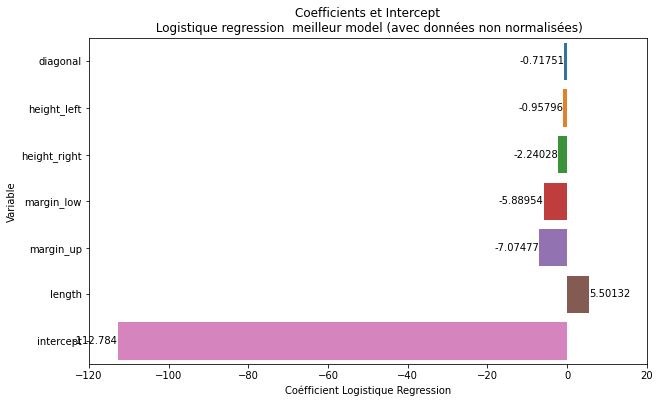

In [173]:
feature_names=x.columns

lrOriginalCoefIntercept=pd.DataFrame(list(zip(feature_names,lrOriginal.coef_[0])),
                                      columns=['Variable','Coéfficient Logistique Regression'])
new_row = {'Variable':'intercept', 
           'Coéfficient Logistique Regression':lrOriginal.intercept_[0]}

lrOriginalCoefIntercept = lrOriginalCoefIntercept.append(new_row, ignore_index=True)

display(lrOriginalCoefIntercept)


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='Variable',x='Coéfficient Logistique Regression',data=lrOriginalCoefIntercept,capsize=0.2, ax=ax)
ax.bar_label(ax.containers[0])
plt.xlim(-120,20)

plt.title('Coefficients et Intercept\n Logistique regression  meilleur model (avec données non normalisées)')
plt.show()

Best Model Matrice confusion (données non normalisées) [[143   3]
 [  0 304]]


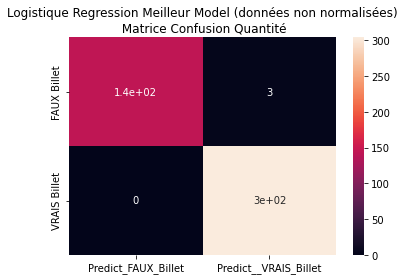

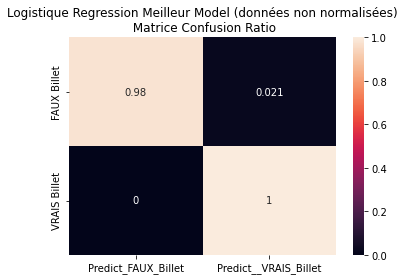

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       146
           1       0.99      1.00      1.00       304

    accuracy                           0.99       450
   macro avg       1.00      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450

Precision Score de Meilleur Model (données non normalisées) 0.995114006514658
Recall Score de Meilleur Model (données non normalisées) 0.9897260273972603
F1 Score de Meilleur Model (données non normalisées) 0.9923546967646208
Accuracy Score de Meilleur Model (données non normalisées) 0.9933333333333333
VRAIS BILLET Précision Score 0.990228013029316
VRAIS BILLET Recall Score de Meilleur Model (données non normalisées) 1.0
FAUX BILLET Précision Score de Meilleur Model (données non normalisées) 1.0
FAUX BILLET Recall Score de Meilleur Model (données non normalisées) 0.9794520547945206


In [174]:
lrOriginal_matriceconfusion=metrics.confusion_matrix(y_test,lrOriginal_predict)
print('Best Model Matrice confusion (données non normalisées)',lrOriginal_matriceconfusion)

sns.heatmap(lrOriginal_matriceconfusion,
            xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Meilleur Model (données non normalisées)\n Matrice Confusion Quantité')
plt.show()

lrOriginal_MatriceRatio=lrOriginal_matriceconfusion/lrOriginal_matriceconfusion.sum(axis=1).reshape(-1,1)
sns.heatmap(lrOriginal_MatriceRatio,xticklabels=['Predict_FAUX_Billet','Predict__VRAIS_Billet'],
            yticklabels=['FAUX Billet','VRAIS Billet'],annot=True)
plt.title('Logistique Regression Meilleur Model (données non normalisées)\n Matrice Confusion Ratio')
plt.show()

print(classification_report(y_test,lrOriginal_predict))

#Extraction les scores de tableau classification report

lrOriginalReport=classification_report(y_test,lrOriginal_predict,output_dict=True)

lrOriginal_precision =  lrOriginalReport['macro avg']['precision'] 
print('Precision Score de Meilleur Model (données non normalisées)',lrOriginal_precision)

lrOriginal_recall = lrOriginalReport['macro avg']['recall']    
print('Recall Score de Meilleur Model (données non normalisées)',lrOriginal_recall)

lrOriginal_f1 = lrOriginalReport['macro avg']['f1-score']
print('F1 Score de Meilleur Model (données non normalisées)',lrOriginal_f1)

lrOriginal_accuracy = lrOriginalReport['accuracy']
print('Accuracy Score de Meilleur Model (données non normalisées)',lrOriginal_accuracy)

lrOriginalVRAISBILLET_precision=lrOriginalReport['1']['precision']
print('VRAIS BILLET Précision Score',lrOriginalVRAISBILLET_precision)

lrOriginalVRAISBILLET_recall=lrOriginalReport['1']['recall']
print('VRAIS BILLET Recall Score de Meilleur Model (données non normalisées)',lrOriginalVRAISBILLET_recall)

lrOriginalFAUXBILLET_precision=lrOriginalReport['0']['precision']
print('FAUX BILLET Précision Score de Meilleur Model (données non normalisées)',lrOriginalFAUXBILLET_precision)

lrOriginalFAUXBILLET_recall=lrOriginalReport['0']['recall']
print('FAUX BILLET Recall Score de Meilleur Model (données non normalisées)',lrOriginalFAUXBILLET_recall)

##### LogLoss Train Set et Test Set de Meilleur Model (données non normalisés)
    Train set Log Loss de Meilleur Model (données non normalisés): 0.032010692657733555
    Test set Log Loss de Meilleur Model (données non normalisés): 0.023890322792647318
    
    Il y a un grande progression par rapport à model de base

In [175]:
lrOriginalPropaTrain=lrOriginal.predict_proba(x_train)
lrOriginal_trainlogloss=log_loss(y_train,lrOriginalPropaTrain)
print('Train set Log Loss de Meilleur Model (données non normalisés):',lrOriginal_trainlogloss)

lrOriginalPropaTest=lrOriginal.predict_proba(x_test)
lrOriginal_testlogloss=log_loss(y_test,lrOriginalPropaTest)
print('Test set Log Loss de Meilleur Model (données non normalisés):',lrOriginal_testlogloss)

Train set Log Loss de Meilleur Model (données non normalisés): 0.032010692657733555
Test set Log Loss de Meilleur Model (données non normalisés): 0.023890322792647318


##### ROC AUC Score de Meilleur Model (données non normalisés)
    roc_auc_score de Meilleur Model ((données non normalisés) 0.9897260273972603
    Espace sous AUC-ROC TrainSet de Meilleur Model ((données non normalisés): 0.9983156373790506
    Espace sous AUC-ROC TestSet de Meilleur Model ((données non normalisés): 0.9997296322999278

roc_auc_score de Meilleur Model ((données non normalisés)


0.9897260273972603

Espace sous AUC-ROC TrainSet de Meilleur Model ((données non normalisés): 0.9983156373790506
Espace sous AUC-ROC TestSet de Meilleur Model ((données non normalisés): 0.9997296322999278


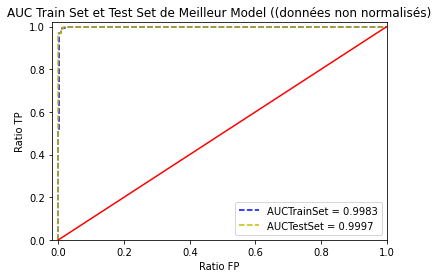

In [176]:
print('roc_auc_score de Meilleur Model ((données non normalisés)')
display(roc_auc_score(y_test,lrOriginal_predict))

fprTrain, tprTrain,thresholdsTrain = metrics.roc_curve(y_train,lrOriginalPropaTrain[:,1])
roc_aucTrain = metrics.auc(fprTrain, tprTrain)

print('Espace sous AUC-ROC TrainSet de Meilleur Model ((données non normalisés):', 
      roc_auc_score(y_train,lrOriginalPropaTrain[:,1]))


fprTest, tprTest,thresholdsTest = metrics.roc_curve(y_test,lrOriginalPropaTest[:,1])
roc_aucTest = metrics.auc(fprTest, tprTest)


print('Espace sous AUC-ROC TestSet de Meilleur Model ((données non normalisés):', 
      roc_auc_score(y_test,lrOriginalPropaTest[:,1]))


plt.title('AUC Train Set et Test Set de Meilleur Model ((données non normalisés)')
plt.plot(fprTrain, tprTrain, 'b--', label = 'AUCTrainSet = %0.4f' % roc_aucTrain)
plt.plot(fprTest, tprTest, 'y--', label = 'AUCTestSet = %0.4f' % roc_aucTest)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.ylabel('Ratio TP')
plt.xlabel('Ratio FP')
plt.show()

# 8. Application

Entréer adresse de votre fichier CSV: (Exemple d'adresse: /Users/PF/Desktop/openclassroom/P10/billets_production.csv) /Users/PF/Desktop/openclassroom/P10/billets_prod.csv
Entréer Séparateur de votre fichier CSV: ,


Démarrage de Process de prédiction
-------------------------------------------------------------------------------------------------
Prédition de fichier de production
Tableau de Prédiction(Résultat final colonne Resume_Prediction):
 


diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1   
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2   
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3   
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4   
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5   

        CP1       CP2  lrNonScaledpred_propabilité_FAUXbillet  \
0 -0.852002  0.300975                                  0.0006   
1  1.549901 -1.307262                                  0.9995   
2 -1.189817 -0.730440                                  0.0000   
3  2.194078  0.053763                                  1.0000   
4  1.666050 -0.152099                                  0.9973   

   lrNonScaledpred_propababilité_VRAISbillet lrNonScaledpred  \
0                                     0.9994           VRAIS   
1                                     0.0005            FAUX   
2                                     1.0000           VRAIS   
3                                     0.0000            FAUX   
4                                     0.0027            FAUX   

   lrScaledpred_propaFAUXbillet  lrScaledpred_propaVRAISbillet lrScaledpred  \
0                        0.0005                         0.9995        VRAIS   
1                        0.9996                         0.0004         FAUX   
2                        0.0000                         1.0000        VRAIS   
3                        1.0000                         0.0000         FAUX   
4                        0.9975                         0.0025         FAUX   

  kmeanspred kmeansACPpred Resume_Prediction  
0      VRAIS         VRAIS             VRAIS  
1       FAUX          FAUX              FAUX  
2      VRAIS         VRAIS             VRAIS  
3       FAUX          FAUX              FAUX  
4       FAUX          FAUX              FAUX

Comparaison de réelle étiquette de train set et la prédiction des nouvelles données
 


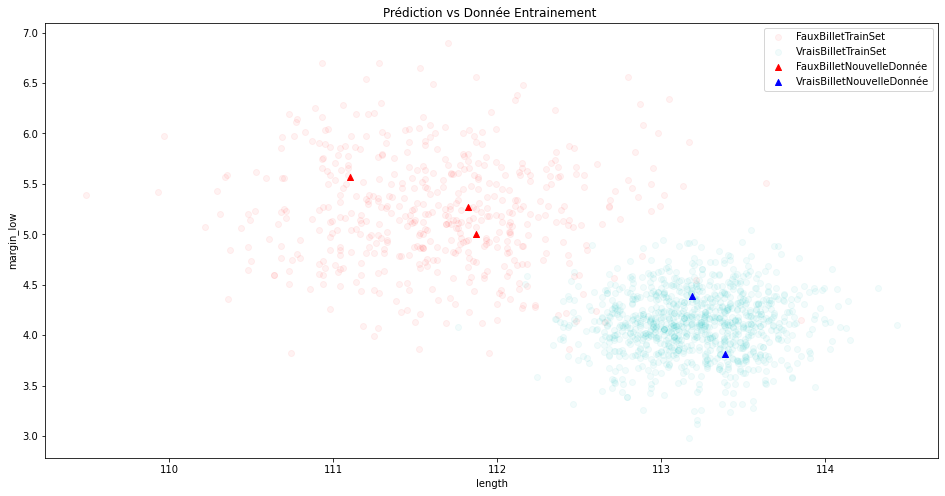

-------------------------------------------------------------------------------------------------
Visualisation de la répartition de la prédiction selon Méthodes


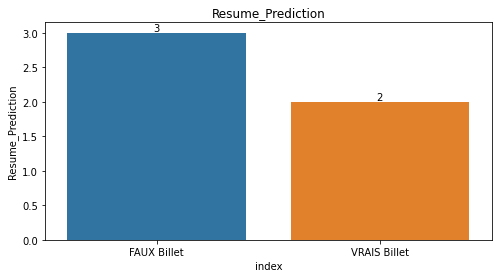

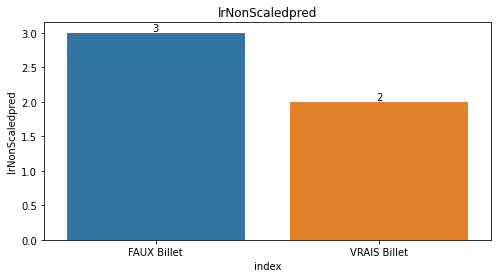

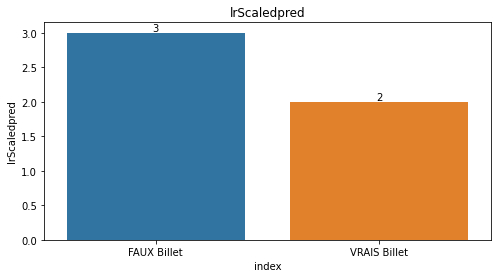

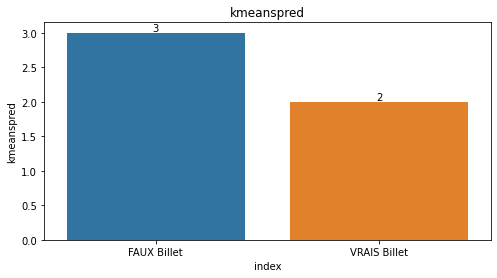

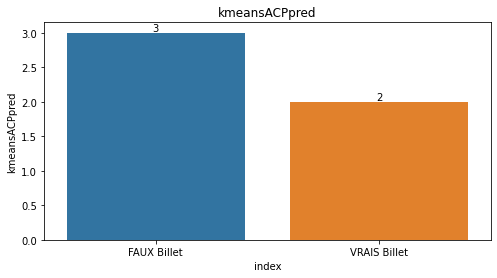

-------------------------------------------------------------------------------------------------
Visualisation Regression Logistique
 
Coefficient et Intercept de Regression Logistique
 


Variable  Coéfficient lrnonScaled  Coéfficient lrScaled
0      diagonal                 0.363021              0.102886
1   height_left                -1.427076             -0.433993
2  height_right                -2.615321             -0.890177
3    margin_low                -5.991273             -4.098114
4     margin_up                -8.955562             -2.283749
5        length                 5.683481              5.066415
6     intercept              -224.768377              2.834026

Coefficient et Intercept de Regression Logistique (Données Non Normalisés)
 


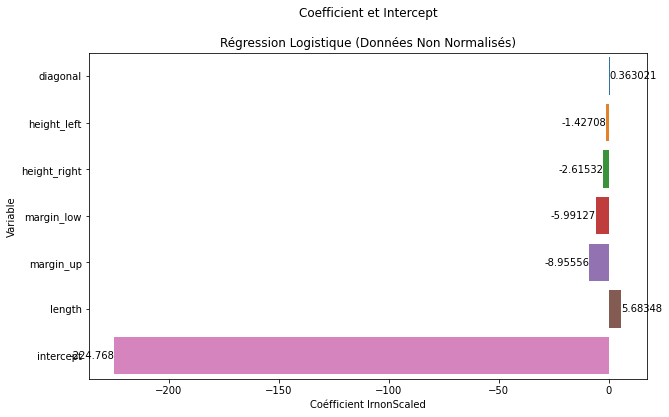

Prédiction Regression Logistique (Données Non Normalisés)
 


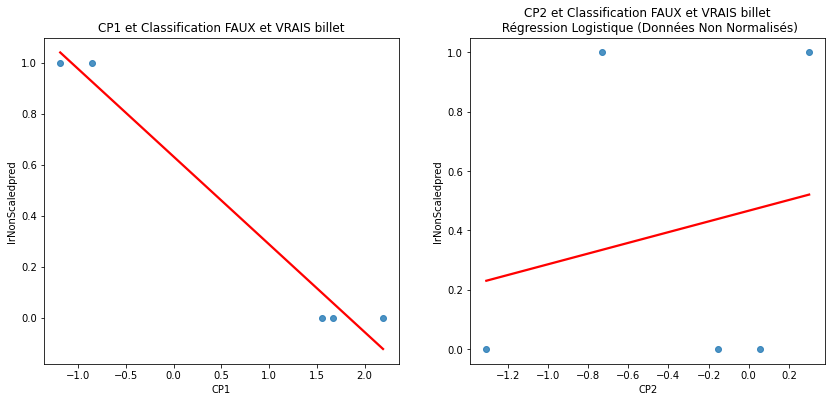

Coefficient et Intercept de Regression Logistique (Données Normalisés)
 


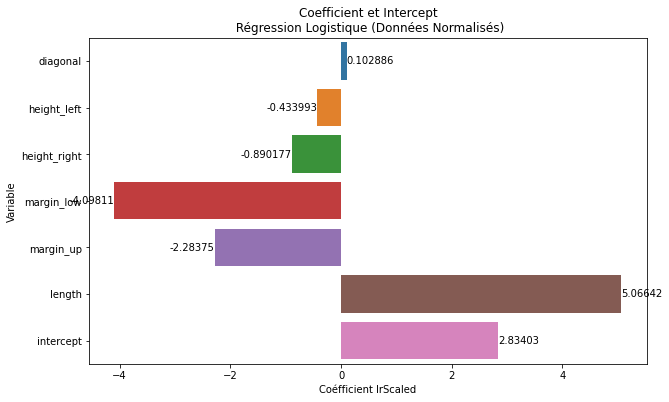

Prédiction Regression Logistique (Données Normalisés)
 


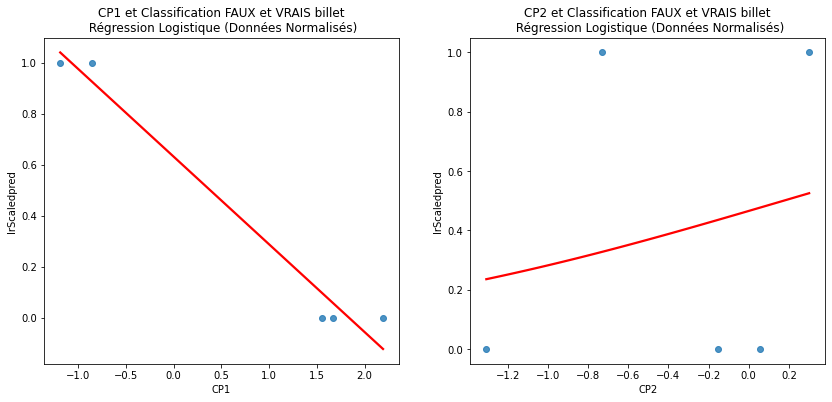

-------------------------------------------------------------------------------------------------
Visualisation Prédiction Kmeans Sans ACP
 
Caractère des clusters Kmeans Sans ACP
 


KmeansSansACP    diagonal  height_left  height_right  margin_low  \
0              0  171.899153   104.200383    104.152520    5.221884   
1              1  171.987729   103.945129    103.805588    4.117896   

   margin_up      length   Réalité       CP1       CP2  
0   3.351734  111.630847  0.020161  2.067183 -0.074364  
1   3.052540  113.196066  0.986056 -1.021238  0.036737

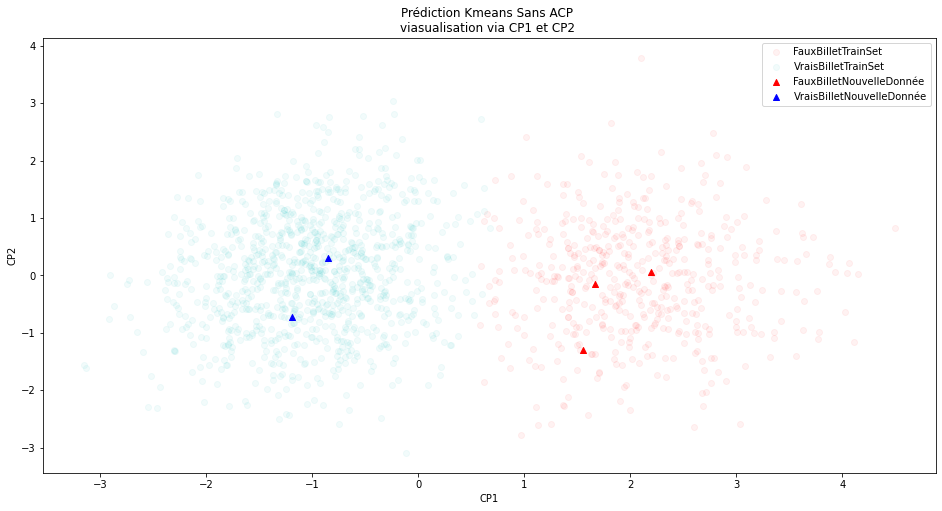

-------------------------------------------------------------------------------------------------
Visualisation Prédiction Kmeans Avec ACP
 
Caractère des clusters Kmeans Avec ACP
 


KmeansAvecACP    diagonal  height_left  height_right  margin_low  \
0              0  171.899153   104.200383    104.152520    5.221884   
1              1  171.987729   103.945129    103.805588    4.117896   

   margin_up      length  
0   3.351734  111.630847  
1   3.052540  113.196066

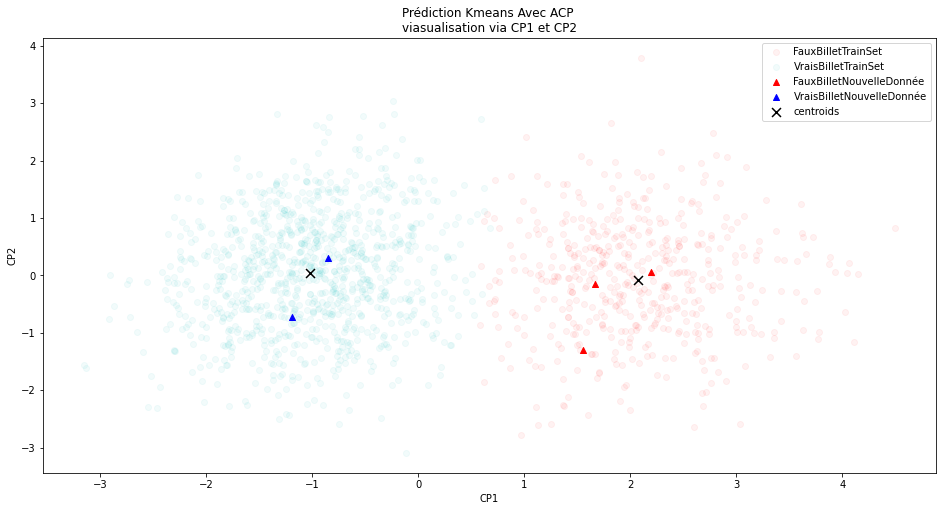

In [286]:
# input exemple: /Users/PF/Desktop/openclassroom/P10/billets_production.csv

link=input('Entréer adresse de votre fichier CSV: (Exemple d\'adresse: /Users/PF/Desktop/openclassroom/P10/billets_production.csv)')
separation=input('Entréer Séparateur de votre fichier CSV:')

#Import fichier production
billetsProd=pd.read_csv(link,sep=separation)
#billetsProd=pd.read_csv('/Users/PF/Desktop/openclassroom/P10/billets_test.csv',sep=',')

valeurcheck=billetsProd.isna().sum().reset_index().rename(columns={0:'Nombre Valeur Manquante'})
ValeurManquante=valeurcheck[valeurcheck['Nombre Valeur Manquante']>0]
if len(ValeurManquante['index'])>0:
    print('Merci de SUPPRIMER LES LIGNES concernées par les données manquantes\n ou',
              'COMPLETER LES DONNEES MANQUANTES des lignes concernées\n',
              'avant d\'utiliser l\'outil avec les données completes')
    display(ValeurManquante)
else:
    print('Démarrage de Process de prédiction')
    
    #Mettre colonne 'id' comme index
    billetsProd2=billetsProd.set_index('id')

    #Importer les données de base
    dataAppX=billets[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]
    dataAppY=billets[['is_genuine']]


    #Méthode 1 Regression Logistique avec Donnée non normalisé
    #Entrainer les données de base non normalisé avec regression logistique optimisé et prédire l'étiquette de donnée de production
    lrAPPnonScaled=LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,solver='newton-cg',max_iter=100, penalty='l2')
    lrAPPnonScaled.fit(dataAppX,dataAppY)
    lrNonScaledpred=lrAPPnonScaled.predict(billetsProd2)
    yPropalrNonScaled=lrAPPnonScaled.predict_proba(billetsProd2)



    #Méthode 2 Regression Logistique avec Donnée normalisé
    #Normalier les données de base et de production
    scaler=StandardScaler()
    dataAppX_scaled=scaler.fit_transform(dataAppX)
    billetsProd_scaled=scaler.transform(billetsProd2)


    #Entrainer les données de base normalisé avec regression logistique optimisé et prédire l'étiquette de donnée de production
    lrAPPScaled=LogisticRegression(C=100, class_weight={0: 0.33, 1: 0.66}, random_state=123,max_iter=100, penalty='l2', solver='lbfgs')
    lrAPPScaled.fit(dataAppX_scaled,dataAppY)
    lrScaledpred=lrAPPScaled.predict(billetsProd_scaled)
    yPropalrScaledpred=lrAPPScaled.predict_proba(billetsProd_scaled)

    #Méthode 3 Kmeans sans ACP
    #Entrainer les données de base normalisé avec Kmeans et prédire l'étiquette de donnée de production
    dataAppXkmeans=KMeans(n_clusters=2, init ='k-means++',random_state=123)
    dataAppXkmeans.fit(dataAppX_scaled)
    kmeanspred=dataAppXkmeans.predict(billetsProd_scaled)


    #Méthode 4 Kmeans avec ACP

    #ACP des données de base pour kmeans
    dataAppX_ACP=decomposition.PCA(n_components=5)
    modelAppX_ACP=dataAppX_ACP.fit(dataAppX_scaled)
    scoreAppX_ACP=modelAppX_ACP.transform(dataAppX_scaled)
    scorebilletsProd_ACP=modelAppX_ACP.transform(billetsProd_scaled)


    #Entrainer les données de ACP avec Kmeans et prédire l'étiquette de donnée de production
    dataAppXkmeans_ACP=KMeans(n_clusters=2, init ='k-means++',random_state=123)
    dataAppXkmeans_ACP.fit(scoreAppX_ACP)
    kmeansACPpred=dataAppXkmeans_ACP.predict(scorebilletsProd_ACP)

    #Ajouter les étiquettes de prédiction au données de production
    
    #Composant Principal
    dataAppX['Réalité']=dataAppY
    dataAppX['CP1']=scoreAppX_ACP[:,0]
    dataAppX['CP2']=scoreAppX_ACP[:,1]    
    billetsProd['CP1']=scorebilletsProd_ACP[:,0]
    billetsProd['CP2']=scorebilletsProd_ACP[:,1]
    
    
    #Régression logistique donnée non normalisé
    billetsProd['lrNonScaledpred_propabilité_FAUXbillet']=yPropalrNonScaled[:,0].round(4)
    billetsProd['lrNonScaledpred_propababilité_VRAISbillet']=yPropalrNonScaled[:,1].round(4)
    billetsProd['lrNonScaledpred']=lrNonScaledpred
    
     #Régression logistique donnée normalisé
    billetsProd['lrScaledpred_propaFAUXbillet']=yPropalrScaledpred[:,0].round(4)
    billetsProd['lrScaledpred_propaVRAISbillet']=yPropalrScaledpred[:,1].round(4)
    billetsProd['lrScaledpred']=lrScaledpred
   
    #2 kmeans
    billetsProd['kmeanspred']=kmeanspred
    billetsProd['kmeansACPpred']=kmeansACPpred

    billetsProd['Resume_Prediction'] = billetsProd.apply(lambda x: x['lrNonScaledpred'] if x['lrNonScaledpred'] ==
                     x['lrScaledpred'] == x['kmeanspred']== x['kmeansACPpred'] else 0, axis=1)

    
    print('-------------------------------------------------------------------------------------------------')
    print('Prédition de fichier de production')
    #Copier fichier résultat de prédiction
    TableauPrediction=billetsProd.copy()
    
    #Modifier les étiquettes de prédiction des différents model et de prédiction de synthèse
    TableauPrediction.loc[TableauPrediction["lrScaledpred"] == 0, "lrScaledpred"] = 'FAUX'
    TableauPrediction.loc[TableauPrediction["lrScaledpred"] == 1, "lrScaledpred"] = 'VRAIS'
    
    TableauPrediction.loc[TableauPrediction["lrNonScaledpred"] == 0, "lrNonScaledpred"] = 'FAUX'
    TableauPrediction.loc[TableauPrediction["lrNonScaledpred"] == 1, "lrNonScaledpred"] = 'VRAIS'
    
    TableauPrediction.loc[TableauPrediction["kmeanspred"] == 0, "kmeanspred"] = 'FAUX'
    TableauPrediction.loc[TableauPrediction["kmeanspred"] == 1, "kmeanspred"] = 'VRAIS'
    
    TableauPrediction.loc[TableauPrediction["kmeansACPpred"] == 0, "kmeansACPpred"] = 'FAUX'
    TableauPrediction.loc[TableauPrediction["kmeansACPpred"] == 1, "kmeansACPpred"] = 'VRAIS'
    
    TableauPrediction.loc[TableauPrediction["kmeanspred"] == 0, "kmeanspred"] = 'FAUX'
    TableauPrediction.loc[TableauPrediction["kmeanspred"] == 1, "kmeanspred"] = 'VRAIS'
    
    TableauPrediction.loc[TableauPrediction["Resume_Prediction"] == 0, "Resume_Prediction"] = 'FAUX'
    TableauPrediction.loc[TableauPrediction["Resume_Prediction"] == 1, "Resume_Prediction"] = 'VRAIS'
    
    
    #Affichier le tableau de prédiction
    print('Tableau de Prédiction(Résultat final colonne Resume_Prediction):\n ')
    display(TableauPrediction)
    
    
    #Affichier la prédiction et les étiquettes réelles de train set
    print('Comparaison de réelle étiquette de train set et la prédiction des nouvelles données\n ')
    plt.figure(figsize=(16,8))
    plt.scatter(x='length',y='margin_low',data=dataAppX[dataAppX['Réalité']==0],color='r',alpha=0.05,label='FauxBilletTrainSet')
    plt.scatter(x='length',y='margin_low',data=dataAppX[dataAppX['Réalité']==1],color='c',alpha=0.05,label='VraisBilletTrainSet')
    plt.scatter(x='length',y='margin_low',data=billetsProd[billetsProd['Resume_Prediction']==0],marker ="^",color='r',label='FauxBilletNouvelleDonnée')
    plt.scatter(x='length',y='margin_low',data=billetsProd[billetsProd['Resume_Prediction']==1],marker ="^",color='b',label='VraisBilletNouvelleDonnée')
    plt.xlabel('length')
    plt.ylabel('margin_low')
    plt.legend()
    plt.title('Prédiction vs Donnée Entrainement ')
    plt.show()
    
    print('-------------------------------------------------------------------------------------------------')
    print('Visualisation de la répartition de la prédiction selon Méthodes')
    for i in ['Resume_Prediction','lrNonScaledpred','lrScaledpred','kmeanspred','kmeansACPpred']:
        a=str(i)+'_repartition'               
        a=billetsProd[i].value_counts().reset_index()
        a['index']=a['index'].astype(str)
        a.loc[a['index']=='0','index']='FAUX Billet'
        a.loc[a['index']=='1','index']='VRAIS Billet'
        
        fig,ax1=plt.subplots(figsize=(8,4))
        sns.barplot(x='index',
                    y=i,
                    data=a,
                   capsize=0.2, 
                    ax=ax1)
        ax1.bar_label(ax1.containers[0])
        plt.title(i)
        plt.show()   
    
    
    featureNames=dataAppX.columns

    lrCoef=pd.DataFrame(
        list(
            zip(featureNames,lrAPPnonScaled.coef_[0],lrAPPScaled.coef_[0])
            ),
            columns=['Variable','Coéfficient lrnonScaled','Coéfficient lrScaled']
        )
    
    new_row = {'Variable':'intercept',
               'Coéfficient lrnonScaled':lrAPPnonScaled.intercept_[0],
               'Coéfficient lrScaled':lrAPPScaled.intercept_[0]}

    lrCoef = lrCoef.append(new_row, ignore_index=True)
    
    print('-------------------------------------------------------------------------------------------------')
    
    print('Visualisation Regression Logistique\n ')
    
    print('Coefficient et Intercept de Regression Logistique\n ')
    display(lrCoef)
    
    
    print('Coefficient et Intercept de Regression Logistique (Données Non Normalisés)\n ')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(y='Variable',x='Coéfficient lrnonScaled',data=lrCoef,capsize=0.2, ax=ax)
    ax.bar_label(ax.containers[0])
    
    plt.title('Coefficient et Intercept\n \nRégression Logistique (Données Non Normalisés)')
    plt.show()
    
    print('Prédiction Regression Logistique (Données Non Normalisés)\n ')
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    sns.regplot(billetsProd['CP1'],y=billetsProd['lrNonScaledpred'],line_kws={'color': 'red'},ci=None)
    plt.title('CP1 et Classification FAUX et VRAIS billet')
    
    plt.subplot(122)
    sns.regplot(billetsProd['CP2'],y=billetsProd['lrNonScaledpred'],line_kws={'color': 'red'},ci=None)
    plt.title('CP2 et Classification FAUX et VRAIS billet\n Régression Logistique (Données Non Normalisés)')
    plt.show() 
    

    print('Coefficient et Intercept de Regression Logistique (Données Normalisés)\n ')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(y='Variable',x='Coéfficient lrScaled',data=lrCoef,capsize=0.2, ax=ax)
    ax.bar_label(ax.containers[0])
    
    plt.title('Coefficient et Intercept\n Régression Logistique (Données Normalisés)')
    plt.show()
    
    print('Prédiction Regression Logistique (Données Normalisés)\n ')
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    sns.regplot(billetsProd['CP1'],y=billetsProd['lrScaledpred'],line_kws={'color': 'red'},ci=None)
    plt.title('CP1 et Classification FAUX et VRAIS billet\n Régression Logistique (Données Normalisés)')

    plt.subplot(122)
    sns.regplot(billetsProd['CP2'],y=billetsProd['lrScaledpred'],logistic=True,line_kws={'color': 'red'},ci=None)
    plt.title('CP2 et Classification FAUX et VRAIS billet\n Régression Logistique (Données Normalisés)')
    plt.show()
    
    
    
    print('-------------------------------------------------------------------------------------------------')
    print('Visualisation Prédiction Kmeans Sans ACP\n ')
    
    dataAppX['KmeansSansACP']=dataAppXkmeans.labels_
    CaractereKmeansSansACP=dataAppX.groupby('KmeansSansACP').mean().reset_index()
    
    print('Caractère des clusters Kmeans Sans ACP\n ')
    display(CaractereKmeansSansACP)
    plt.figure(figsize=(16,8))
    plt.scatter(x='CP1',y='CP2',data=dataAppX[dataAppX['KmeansSansACP']==0],color='r',alpha=0.05,label='FauxBilletTrainSet')
    plt.scatter(x='CP1',y='CP2',data=dataAppX[dataAppX['KmeansSansACP']==1],color='c',alpha=0.05,label='VraisBilletTrainSet')
    plt.scatter(x='CP1',y='CP2',data=billetsProd[billetsProd['kmeanspred']==0],marker ="^",color='r',label='FauxBilletNouvelleDonnée')
    plt.scatter(x='CP1',y='CP2',data=billetsProd[billetsProd['kmeanspred']==1],marker ="^",color='b',label='VraisBilletNouvelleDonnée')
    plt.xlabel('CP1')
    plt.ylabel('CP2')
    plt.legend()
    plt.title('Prédiction Kmeans Sans ACP \nviasualisation via CP1 et CP2 ')
    plt.show()

    print('-------------------------------------------------------------------------------------------------')
    print('Visualisation Prédiction Kmeans Avec ACP\n ')
    
    dataAppX['KmeansAvecACP']=dataAppXkmeans_ACP.labels_
    CaractereKmeansAvecACP=dataAppX.groupby('KmeansAvecACP')['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length'].mean().reset_index()
    
    print('Caractère des clusters Kmeans Avec ACP\n ')
    display(CaractereKmeansAvecACP)
    plt.figure(figsize=(16,8))
    plt.scatter(x='CP1',y='CP2',data=dataAppX[dataAppX['KmeansAvecACP']==0],color='r',alpha=0.05,label='FauxBilletTrainSet')
    plt.scatter(x='CP1',y='CP2',data=dataAppX[dataAppX['KmeansAvecACP']==1],color='c',alpha=0.05,label='VraisBilletTrainSet')
    plt.scatter(x='CP1',y='CP2',data=billetsProd[billetsProd['kmeansACPpred']==0],marker ="^",color='r',label='FauxBilletNouvelleDonnée')
    plt.scatter(x='CP1',y='CP2',data=billetsProd[billetsProd['kmeansACPpred']==1],marker ="^",color='b',label='VraisBilletNouvelleDonnée')
    plt.scatter(dataAppXkmeans_ACP.cluster_centers_[:,0], dataAppXkmeans_ACP.cluster_centers_[:,1], marker="x", c="k", s=80, label="centroids")
    plt.xlabel('CP1')
    plt.ylabel('CP2')
    plt.legend()
    plt.title('Prédiction Kmeans Avec ACP \nviasualisation via CP1 et CP2')
    plt.show()
